In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from typing import Tuple, Dict

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Define our materiality thresholds (in Naira)
OVERALL_MATERIALITY = 66244289
SPECIFIC_MATERIALITY = 3312214

print("✅ Libraries and Materiality Thresholds Imported/Set")

✅ Libraries and Materiality Thresholds Imported/Set


In [2]:
# Define the path to your 'final folder'
folder_path = './'  # This means "current directory" where your notebook is running

# Define the file names (assuming they are in the same folder as your notebook)
ap_file_name = 'Anonymized_Account_Payable_USD.xlsx'
ar_file_name = 'Account Receivables_ANONYMIZED.xlsx'

# Create the full file paths by joining the folder path and file names
ap_file_path = os.path.join(folder_path, ap_file_name)
ar_file_path = os.path.join(folder_path, ar_file_name)

# Check if the files exist before trying to load them
print("Checking if files exist...")
print(f"AP File exists: {os.path.exists(ap_file_path)}")
print(f"AR File exists: {os.path.exists(ar_file_path)}")

# Read the datasets
print("\nLoading datasets...")
ap_data = pd.read_excel(ap_file_path)
ar_data = pd.read_excel(ar_file_path)

print("✓ Datasets loaded successfully!")
print(f"AP Data Shape: {ap_data.shape}")
print(f"AR Data Shape: {ar_data.shape}")

# Quick preview of the data
print("\nFirst few rows of AP Data:")
display(ap_data.head(3))

print("\nFirst few rows of AR Data:")
display(ar_data.head(3))

Checking if files exist...
AP File exists: True
AR File exists: True

Loading datasets...
✓ Datasets loaded successfully!
AP Data Shape: (293, 10)
AR Data Shape: (688, 10)

First few rows of AP Data:


,Accounts Payable (A/P),Date,Transaction Type,No.,Name,Memo/Description,Account,Split,Amount,Balance
0,NaN,Beginning Balance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.643941e+09
1,NaN,01/01/2023,Bill,NaN,Vendor_001,NaN,Accounts Payable (A/P),Expense_Category_001,1.814747e+08,1.825416e+09
2,NaN,01/02/2023,Journal Entry,180R,NaN,NaN,Accounts Payable (A/P),General_Adjustment,-1.622570e+09,2.028462e+08



First few rows of AR Data:


,Accounts Receivable (A/R) - USD,Date,Transaction Type,No.,Name,Memo/Description,Account,Spilit,Amount,Balance
0,NaN,Beginning Balance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,01/03/2023,Payment,NaN,Customer_001,NaN,Accounts Receivable (A/R) - USD,Bank_Account_001,-94125000.0,-94125000.0
2,NaN,01/03/2023,Invoice,1161,Customer_002,NaN,Accounts Receivable (A/R) - USD,Sales,8602687.6,-85522312.4


In [3]:
# Calculate and display percentage of NaN values for each feature in the original AP data
nan_percentage_original_ap = (ap_data.isnull().sum() / len(ap_data)) * 100
print("Percentage of NaN values per feature in Original Accounts Payable Data:")
display(nan_percentage_original_ap.sort_values(ascending=False))

# Calculate and display percentage of NaN values for each feature in the original AR data
nan_percentage_original_ar = (ar_data.isnull().sum() / len(ar_data)) * 100
print("\nPercentage of NaN values per feature in Original Accounts Receivable Data:")
display(nan_percentage_original_ar.sort_values(ascending=False))

Percentage of NaN values per feature in Original Accounts Payable Data:


,0
Memo/Description,100.000000
Accounts Payable (A/P),99.317406
No.,48.464164
Name,4.778157
Account,1.023891
Transaction Type,1.023891
Split,1.023891
Date,0.682594
Balance,0.682594
Amount,0.341297



Percentage of NaN values per feature in Original Accounts Receivable Data:


,0
Accounts Receivable (A/R) - USD,99.709302
Memo/Description,97.238372
No.,51.598837
Name,3.197674
Account,0.436047
Transaction Type,0.436047
Balance,0.436047
Spilit,0.436047
Date,0.290698
Amount,0.145349


In [4]:
# Preprocessing and feature engineering

def preprocess(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df = df.copy()

    # Drop specified columns if they exist
    cols_to_drop = ['Accounts Payable (A/P)', 'Accounts Receivable (A/R) - USD', 'Memo/Description']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])


    # Basic cleaning / existence checks and handle 'Spilit' column in AR data
    col_mapping = {'Spilit': 'Split'}
    df = df.rename(columns=col_mapping)

    for col in ['Date', 'Amount', 'Name', 'Account', 'Split']:
        if col not in df.columns:
            df[col] = np.nan

    # Calculate NaN ratio per row
    # Ensure we are calculating based on the current number of columns
    df['nan_ratio'] = df.isnull().sum(axis=1) / df.shape[1]


    # Fill Name and Account with most frequent values to avoid dropping rows
    for col in ['Name', 'Account', 'Split']:
        if df[col].isna().any():
            mode_value = df[col].mode().iloc[0] if not df[col].mode().empty else 'Unknown'
            df[col] = df[col].fillna(mode_value)

    # Date parsing and calendar features
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # If Date missing, fill with median date
    if df['Date'].isna().any():
        median_date = df['Date'].dropna().median()
        df['Date'] = df['Date'].fillna(median_date)


    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)


    # Amount based features
    df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce').fillna(0.0)
    df['abs_amount'] = df['Amount'].abs()
    df['is_negative'] = (df['Amount'] < 0).astype(int)
    df['amount_log'] = np.log1p(df['abs_amount'])

    # Credit / Debit split
    df['Debit'] = df['Amount'].apply(lambda x: abs(x) if x < 0 else 0.0)
    df['Credit'] = df['Amount'].apply(lambda x: x if x > 0 else 0.0)

    # Frequency encodings
    df['Name_freq'] = df['Name'].map(df['Name'].value_counts()).astype(int)
    df['Account_freq'] = df['Account'].map(df['Account'].value_counts()).astype(int)
    df['Split_freq'] = df['Split'].map(df['Split'].value_counts()).astype(int)

    # Group stats per Name
    stats = df.groupby('Name')[['Credit', 'Debit']].agg(['mean', 'std'])
    stats.columns = ['NameAvgCredit', 'NameStdCredit', 'NameAvgDebit', 'NameStdDebit']
    # Use join with suffixes to handle overlapping columns
    df = df.join(stats, on='Name', lsuffix='_left', rsuffix='_right')

    # Prioritize the newly calculated stats if they exist, otherwise use the original ones
    for col in ['NameAvgCredit', 'NameStdCredit', 'NameAvgDebit', 'NameStdDebit']:
        if f'{col}_right' in df.columns:
            df[col] = df[f'{col}_right'].fillna(df[f'{col}_left'])
            df = df.drop(columns=[f'{col}_left', f'{col}_right'])
        elif f'{col}_left' in df.columns:
             df[col] = df[f'{col}_left']
             df = df.drop(columns=[f'{col}_left'])


    # Z-scores (handle zero std)
    df['CreditZscore'] = (df['Credit'] - df['NameAvgCredit']) / (df['NameStdCredit'].replace(0, np.nan))
    df['DebitZscore'] = (df['Debit'] - df['NameAvgDebit']) / (df['NameStdDebit'].replace(0, np.nan))


    # Account-level averages and deviations
    acct_stats = df.groupby('Account')[['Credit', 'Debit']].mean()
    acct_stats.columns = ['AccountAvgCredit', 'AccountAvgDebit']
    # Use join with suffixes
    df = df.join(acct_stats, on='Account', lsuffix='_left', rsuffix='_right')

    # Prioritize the newly calculated stats if they exist, otherwise use the original ones
    for col in ['AccountAvgCredit', 'AccountAvgDebit']:
        if f'{col}_right' in df.columns:
            df[col] = df[f'{col}_right'].fillna(df[f'{col}_left'])
            df = df.drop(columns=[f'{col}_left', f'{col}_right'])
        elif f'{col}_left' in df.columns:
             df[col] = df[f'{col}_left']
             df = df.drop(columns=[f'{col}_left'])

    df['Credit_vs_AccountAvg'] = df['Credit'] - df['AccountAvgCredit']
    df['Debit_vs_AccountAvg'] = df['Debit'] - df['AccountAvgDebit']


    # Weekly/Monthly txn counts
    df['Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
    df['Month'] = df['Date'].dt.to_period('M').apply(lambda r: r.start_time)

    weekly = df.groupby(['Name', 'Week']).size().rename('WeeklyTxnCount')
    monthly = df.groupby(['Name', 'Month']).size().rename('MonthlyTxnCount')
    # Use join with suffixes
    df = df.join(weekly, on=['Name', 'Week'], lsuffix='_left', rsuffix='_right')
    df = df.join(monthly, on=['Name', 'Month'], lsuffix='_left', rsuffix='_right')

    # Prioritize the newly calculated stats if they exist, otherwise use the original ones
    for col in ['WeeklyTxnCount', 'MonthlyTxnCount']:
        if f'{col}_right' in df.columns:
            df[col] = df[f'{col}_right'].fillna(df[f'{col}_left'])
            df = df.drop(columns=[f'{col}_left', f'{col}_right'])
        elif f'{col}_left' in df.columns:
             df[col] = df[f'{col}_left']
             df = df.drop(columns=[f'{col}_left'])


    # Replace inf/nan
    df = df.replace([np.inf, -np.inf], np.nan)

    # Add the missing 'Amount_to_Specific_Materiality' column
    df['Amount_to_Specific_Materiality'] = df['Amount'] / SPECIFIC_MATERIALITY
    # Replace inf/nan in Amount_to_Specific_Materiality
    df['Amount_to_Specific_Materiality'] = df['Amount_to_Specific_Materiality'].replace([np.inf, -np.inf], np.nan)


    # Select modeling features
    feature_cols = [
        'year','month','day','day_of_week','is_weekend','is_month_end',
        'abs_amount','is_negative','amount_log','Debit','Credit',
        'Name_freq','Account_freq','Split_freq', 'Amount_to_Specific_Materiality',
        'NameAvgCredit','NameStdCredit','NameAvgDebit','NameStdDebit',
        'CreditZscore','DebitZscore','AccountAvgCredit','AccountAvgDebit',
        'Credit_vs_AccountAvg','Debit_vs_AccountAvg','WeeklyTxnCount','MonthlyTxnCount',
        'nan_ratio' # Add the new feature
    ]

    print("Length of feature_cols:", len(feature_cols))
    features = df[feature_cols]
    print("Shape of features DataFrame:", features.shape)

    # Impute + scale pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])

    X = pipeline.fit_transform(features)

    return df, pd.DataFrame(X, index=df.index, columns=[f'f_{i}' for i in range(X.shape[1])])

raw_with_meta_ap, X_ap = preprocess(ap_data)
print("Accounts Payable Preprocessing Results:")
print(X_ap.shape)
display(X_ap.head())

raw_with_meta_ar, X_ar = preprocess(ar_data)
print("\nAccounts Receivable Preprocessing Results:")
print(X_ar.shape)
display(X_ar.head())

print("First few rows of preprocessed Accounts Payable Data:")
display(raw_with_meta_ap.head(3))

print("\nFirst few rows of preprocessed Accounts Receivable Data:")
display(raw_with_meta_ar.head(3))

Length of feature_cols: 28
Shape of features DataFrame: (293, 28)
Accounts Payable Preprocessing Results:
(293, 28)


/tmp/ipython-input-1934700794.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27
0,0.0,0.021145,0.210749,0.970663,-0.215473,-0.270666,-0.150214,-0.989813,-5.469337,-0.123049,...,1.333573,-0.227875,-0.198546,0.0,3.725290e-09,-0.194794,-0.123049,0.388486,-0.037829,6.814007
1,0.0,-2.261354,-1.701350,2.231878,4.640955,-0.270666,1.071339,-0.989813,2.341156,-0.123049,...,0.324597,0.786221,-0.786221,0.0,3.725290e-09,8.297602,-0.123049,-0.919863,-0.667589,0.527785
2,0.0,-2.261354,-1.588873,-1.551769,-0.215473,-0.270666,10.771715,1.010292,3.240897,10.875268,...,1.333573,-0.227875,7.164830,0.0,3.725290e-09,-0.194794,10.875268,-0.919863,-0.541637,0.527785
3,0.0,-2.261354,-1.476397,-0.921161,-0.215473,-0.270666,-0.150079,1.010292,-1.401765,-0.122913,...,-0.784841,-0.786221,0.786221,0.0,3.725290e-09,-0.194794,-0.122913,-0.919863,-0.667589,-0.729459
4,0.0,-2.261354,-0.801538,-1.551769,-0.215473,-0.270666,-0.006357,1.010292,1.462603,0.021814,...,1.333573,-0.227875,-0.101560,0.0,3.725290e-09,-0.194794,0.021814,-0.919863,-0.541637,0.527785


/tmp/ipython-input-1934700794.py:31: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], errors='coerce')


Length of feature_cols: 28
Shape of features DataFrame: (688, 28)

Accounts Receivable Preprocessing Results:
(688, 28)


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27
0,0.0,-0.064996,-0.862047,-0.143601,-0.053995,-0.190117,-0.609841,-1.047645,-7.592157,-0.402639,...,-0.325409,-0.471655,-0.469325,-1.192093e-07,-1.192093e-07,-0.389824,-0.402639,-0.278559,-0.100388,9.792597
1,0.0,-1.507492,-1.314786,-0.859524,-0.053995,-0.190117,-0.562095,0.954521,-0.300153,-0.339146,...,-0.735110,-0.641313,-0.124597,-1.192093e-07,-1.192093e-07,-0.389824,-0.339146,0.766798,-0.100388,0.655201
2,0.0,-1.507492,-1.314786,-0.859524,-0.053995,-0.190117,-0.605477,-1.047645,-1.250389,-0.402639,...,-0.325409,-0.458200,-0.469325,-1.192093e-07,-1.192093e-07,-0.384285,-0.402639,2.857514,3.427217,-0.867698
3,0.0,-1.507492,-1.314786,-0.859524,-0.053995,-0.190117,-0.587946,0.954521,-0.609787,-0.373522,...,-0.325409,-0.471655,-0.393380,-1.192093e-07,-1.192093e-07,-0.389824,-0.373522,2.857514,3.427217,0.655201
4,0.0,-1.507492,-1.314786,-0.859524,-0.053995,-0.190117,-0.587946,-1.047645,-0.609787,-0.402639,...,-0.325409,-0.404146,-0.469325,-1.192093e-07,-1.192093e-07,-0.362028,-0.402639,2.857514,3.427217,-0.867698


First few rows of preprocessed Accounts Payable Data:


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,DebitZscore,AccountAvgCredit,AccountAvgDebit,Credit_vs_AccountAvg,Debit_vs_AccountAvg,Week,Month,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality
0,2023-08-18,NaN,NaN,Vendor_016,Accounts Payable (A/P),Expense_Category_012,0.000000e+00,1.643941e+09,0.750,2023,...,-0.178567,4.162580e+06,1.815327e+07,-4.162580e+06,-1.815327e+07,2023-08-14,2023-08-01,4,7,0.000000
1,2023-01-01,Bill,NaN,Vendor_001,Accounts Payable (A/P),Expense_Category_001,1.814747e+08,1.825416e+09,0.125,2023,...,-0.707107,4.162580e+06,1.815327e+07,1.773122e+08,-1.815327e+07,2022-12-26,2023-01-01,1,2,54.789560
2,2023-01-02,Journal Entry,180R,Vendor_016,Accounts Payable (A/P),General_Adjustment,-1.622570e+09,2.028462e+08,0.125,2023,...,6.443862,4.162580e+06,1.815327e+07,-4.162580e+06,1.604416e+09,2023-01-02,2023-01-01,1,3,-489.874651



First few rows of preprocessed Accounts Receivable Data:


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,DebitZscore,AccountAvgCredit,AccountAvgDebit,Credit_vs_AccountAvg,Debit_vs_AccountAvg,Week,Month,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality
0,2023-06-07,NaN,NaN,Customer_002,Accounts Receivable (A/R) - USD,Sales,0.0,NaN,0.875,2023,...,-0.447321,6.053463e+08,5.968890e+08,-6.053463e+08,-5.968890e+08,2023-06-05,2023-06-01,3,8,0.000000
1,2023-01-03,Payment,NaN,Customer_001,Accounts Receivable (A/R) - USD,Bank_Account_001,-94125000.0,-94125000.0,0.125,2023,...,-0.118755,6.053463e+08,5.968890e+08,-6.053463e+08,-5.027640e+08,2023-01-02,2023-01-01,6,8,-28.417548
2,2023-01-03,Invoice,1161,Customer_002,Accounts Receivable (A/R) - USD,Sales,8602687.6,-85522312.4,0.000,2023,...,-0.447321,6.053463e+08,5.968890e+08,-5.967436e+08,-5.968890e+08,2023-01-02,2023-01-01,12,46,2.597262


In [5]:
# Initialize and train Isolation Forest
iso_forest_ap = IsolationForest(contamination='auto', random_state=RANDOM_STATE)
iso_forest_ap.fit(X_ap)
ap_scores_iso = iso_forest_ap.decision_function(X_ap)
ap_anomalies_iso = iso_forest_ap.predict(X_ap)

iso_forest_ar = IsolationForest(contamination='auto', random_state=RANDOM_STATE)
iso_forest_ar.fit(X_ar)
ar_scores_iso = iso_forest_ar.decision_function(X_ar)
ar_anomalies_iso = iso_forest_ar.predict(X_ar)

print("✅ Isolation Forest models trained.")

✅ Isolation Forest models trained.


In [6]:
# Initialize and train Local Outlier Factor (LOF)
# LOF is typically used for outlier detection on small to medium datasets
# For larger datasets, consider sub-sampling or other methods
lof_ap = LocalOutlierFactor(contamination='auto', novelty=True) # novelty=True for predicting on new data
lof_ap.fit(X_ap)
ap_anomalies_lof = lof_ap.predict(X_ap)
# LOF doesn't have a traditional score like decision_function for novelty=True

lof_ar = LocalOutlierFactor(contamination='auto', novelty=True)
lof_ar.fit(X_ar)
ar_anomalies_lof = lof_ar.predict(X_ar)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [7]:
# Initialize and train One-Class SVM
# One-Class SVM can be sensitive to scaling and the 'nu' parameter
svm_ap = OneClassSVM(gamma='auto', nu=0.1) # nu is an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors
svm_ap.fit(X_ap)
ap_scores_svm = svm_ap.decision_function(X_ap)
ap_anomalies_svm = svm_ap.predict(X_ap)

svm_ar = OneClassSVM(gamma='auto', nu=0.1)
svm_ar.fit(X_ar)
ar_scores_svm = svm_ar.decision_function(X_ar)
ar_anomalies_svm = svm_ar.predict(X_ar)


print("✅ One-Class SVM models trained.")

✅ One-Class SVM models trained.


In [8]:
# Add anomaly scores and predictions to the original dataframes
raw_with_meta_ap['iso_forest_score'] = ap_scores_iso
raw_with_meta_ap['iso_forest_anomaly'] = ap_anomalies_iso

raw_with_meta_ar['iso_forest_score'] = ar_scores_iso
raw_with_meta_ar['iso_forest_anomaly'] = ar_anomalies_iso

raw_with_meta_ap['lof_anomaly'] = ap_anomalies_lof
raw_with_meta_ar['lof_anomaly'] = ar_anomalies_lof

raw_with_meta_ap['svm_score'] = ap_scores_svm
raw_with_meta_ap['svm_anomaly'] = ap_anomalies_svm

raw_with_meta_ar['svm_score'] = ar_scores_svm
raw_with_meta_ar['svm_anomaly'] = ar_anomalies_svm

print("✅ Anomaly scores and predictions added to dataframes.")

✅ Anomaly scores and predictions added to dataframes.


In [9]:
# Calculate and display total anomalies per model for AP data
ap_iso_anomalies_count = raw_with_meta_ap[raw_with_meta_ap['iso_forest_anomaly'] == -1].shape[0]
ap_lof_anomalies_count = raw_with_meta_ap[raw_with_meta_ap['lof_anomaly'] == -1].shape[0]
ap_svm_anomalies_count = raw_with_meta_ap[raw_with_meta_ap['svm_anomaly'] == -1].shape[0]

print("Total Anomalies Detected in Accounts Payable Data:")
print(f"  Isolation Forest: {ap_iso_anomalies_count}")
print(f"  Local Outlier Factor (LOF): {ap_lof_anomalies_count}")
print(f"  One-Class SVM: {ap_svm_anomalies_count}")

# Calculate and display total anomalies per model for AR data
ar_iso_anomalies_count = raw_with_meta_ar[raw_with_meta_ar['iso_forest_anomaly'] == -1].shape[0]
ar_lof_anomalies_count = raw_with_meta_ar[raw_with_meta_ar['lof_anomaly'] == -1].shape[0]
ar_svm_anomalies_count = raw_with_meta_ar[raw_with_meta_ar['svm_anomaly'] == -1].shape[0]

print("\nTotal Anomalies Detected in Accounts Receivable Data:")
print(f"  Isolation Forest: {ar_iso_anomalies_count}")
print(f"  Local Outlier Factor (LOF): {ar_lof_anomalies_count}")
print(f"  One-Class SVM: {ar_svm_anomalies_count}")

Total Anomalies Detected in Accounts Payable Data:
  Isolation Forest: 22
  Local Outlier Factor (LOF): 27
  One-Class SVM: 32

Total Anomalies Detected in Accounts Receivable Data:
  Isolation Forest: 141
  Local Outlier Factor (LOF): 22
  One-Class SVM: 68


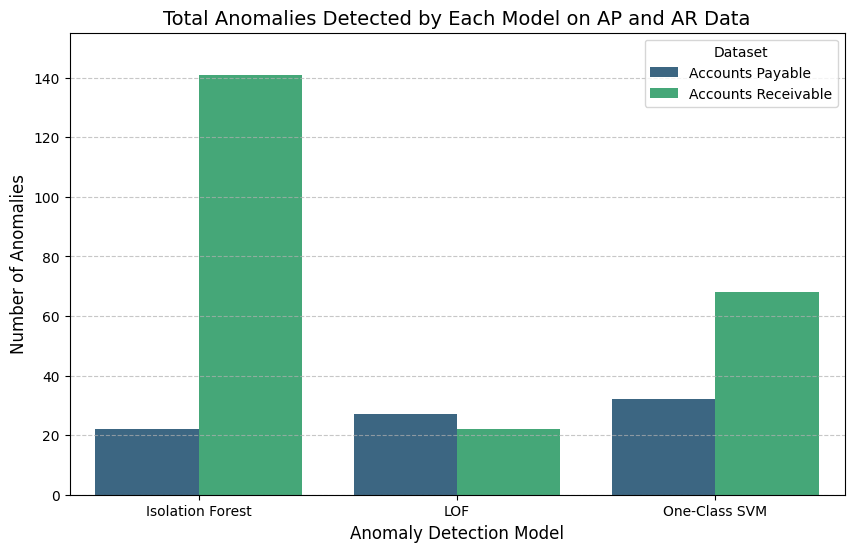

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the previous output (cell 4e9205b4)
ap_iso_anomalies_count = raw_with_meta_ap[raw_with_meta_ap['iso_forest_anomaly'] == -1].shape[0]
ap_lof_anomalies_count = raw_with_meta_ap[raw_with_meta_ap['lof_anomaly'] == -1].shape[0]
ap_svm_anomalies_count = raw_with_meta_ap[raw_with_meta_ap['svm_anomaly'] == -1].shape[0]

ar_iso_anomalies_count = raw_with_meta_ar[raw_with_meta_ar['iso_forest_anomaly'] == -1].shape[0]
ar_lof_anomalies_count = raw_with_meta_ar[raw_with_meta_ar['lof_anomaly'] == -1].shape[0]
ar_svm_anomalies_count = raw_with_meta_ar[raw_with_meta_ar['svm_anomaly'] == -1].shape[0]

# Create a DataFrame for plotting
anomaly_counts_df = pd.DataFrame({
    'Model': ['Isolation Forest', 'LOF', 'One-Class SVM'] * 2,
    'Dataset': ['Accounts Payable'] * 3 + ['Accounts Receivable'] * 3,
    'Count': [ap_iso_anomalies_count, ap_lof_anomalies_count, ap_svm_anomalies_count,
              ar_iso_anomalies_count, ar_lof_anomalies_count, ar_svm_anomalies_count]
})

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Count', hue='Dataset', data=anomaly_counts_df, palette='viridis')
plt.title('Total Anomalies Detected by Each Model on AP and AR Data', fontsize=14)
plt.ylabel('Number of Anomalies', fontsize=12)
plt.xlabel('Anomaly Detection Model', fontsize=12)
plt.legend(title='Dataset')
plt.ylim(0, max(anomaly_counts_df['Count']) * 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
# Display anomalies detected by Isolation Forest in AP data
print("Accounts Payable Anomalies (Isolation Forest):")
display(raw_with_meta_ap[raw_with_meta_ap['iso_forest_anomaly'] == -1].head())

# Display anomalies detected by Isolation Forest in AR data
print("\nAccounts Receivable Anomalies (Isolation Forest):")
display(raw_with_meta_ar[raw_with_meta_ar['iso_forest_anomaly'] == -1].head())

Accounts Payable Anomalies (Isolation Forest):


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,Week,Month,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly
0,2023-08-18,NaN,NaN,Vendor_016,Accounts Payable (A/P),Expense_Category_012,0.000000e+00,1.643941e+09,0.750,2023,...,2023-08-14,2023-08-01,4,7,0.000000,-0.001215,-1,-1,-2.703396,-1
1,2023-01-01,Bill,NaN,Vendor_001,Accounts Payable (A/P),Expense_Category_001,1.814747e+08,1.825416e+09,0.125,2023,...,2022-12-26,2023-01-01,1,2,54.789560,-0.199816,-1,-1,-2.902938,-1
2,2023-01-02,Journal Entry,180R,Vendor_016,Accounts Payable (A/P),General_Adjustment,-1.622570e+09,2.028462e+08,0.125,2023,...,2023-01-02,2023-01-01,1,3,-489.874651,-0.245844,-1,-1,-3.025612,-1
4,2023-01-09,Journal Entry,210R,Vendor_016,Accounts Payable (A/P),General_Adjustment,-2.137148e+07,1.814547e+08,0.125,2023,...,2023-01-09,2023-01-01,1,3,-6.452324,-0.011160,-1,1,0.000020,1
14,2023-01-31,Bill Payment (Cheque),127,Vendor_001,Accounts Payable (A/P),Bank_Account_001,-1.814747e+08,2.274675e+06,0.000,2023,...,2023-01-30,2023-01-01,1,2,-54.789560,-0.187008,-1,-1,-2.712488,-1



Accounts Receivable Anomalies (Isolation Forest):


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,Week,Month,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly
0,2023-06-07,NaN,NaN,Customer_002,Accounts Receivable (A/R) - USD,Sales,0.000000e+00,NaN,0.875,2023,...,2023-06-05,2023-06-01,3,8,0.000000,-0.004841,-1,-1,-5.961639,-1
11,2023-01-04,Payment,NaN,Customer_003,Accounts Receivable (A/R) - USD,Bank_Account_003,-1.120000e+09,-1.120000e+09,0.125,2023,...,2023-01-02,2023-01-01,1,1,-338.142403,-0.015876,-1,1,0.000425,1
12,2023-01-05,Invoice,1165,Customer_002,Accounts Receivable (A/R) - USD,Sales,7.063925e+08,-4.136075e+08,0.000,2023,...,2023-01-02,2023-01-01,12,46,213.268980,-0.018428,-1,1,0.411806,1
13,2023-01-05,Payment,NaN,Customer_002,Accounts Receivable (A/R) - USD,Bank_Account_002,-7.063925e+08,-1.120000e+09,0.125,2023,...,2023-01-02,2023-01-01,12,46,-213.268980,-0.012946,-1,1,0.254452,1
17,2023-01-06,Payment,NaN,Customer_002,Accounts Receivable (A/R) - USD,Bank_Account_004,-1.269830e+07,-1.147856e+09,0.125,2023,...,2023-01-02,2023-01-01,12,46,-3.833779,-0.000414,-1,1,-0.493650,-1


In [12]:
# Display anomalies detected by LOF in AP data
print("Accounts Payable Anomalies (LOF):")
display(raw_with_meta_ap[raw_with_meta_ap['lof_anomaly'] == -1].head())

# Display anomalies detected by LOF in AR data
print("\nAccounts Receivable Anomalies (LOF):")
display(raw_with_meta_ar[raw_with_meta_ar['lof_anomaly'] == -1].head())

Accounts Payable Anomalies (LOF):


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,Week,Month,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly
0,2023-08-18,NaN,NaN,Vendor_016,Accounts Payable (A/P),Expense_Category_012,0.000000e+00,1.643941e+09,0.750,2023,...,2023-08-14,2023-08-01,4,7,0.000000,-0.001215,-1,-1,-2.703396,-1
1,2023-01-01,Bill,NaN,Vendor_001,Accounts Payable (A/P),Expense_Category_001,1.814747e+08,1.825416e+09,0.125,2023,...,2022-12-26,2023-01-01,1,2,54.789560,-0.199816,-1,-1,-2.902938,-1
2,2023-01-02,Journal Entry,180R,Vendor_016,Accounts Payable (A/P),General_Adjustment,-1.622570e+09,2.028462e+08,0.125,2023,...,2023-01-02,2023-01-01,1,3,-489.874651,-0.245844,-1,-1,-3.025612,-1
14,2023-01-31,Bill Payment (Cheque),127,Vendor_001,Accounts Payable (A/P),Bank_Account_001,-1.814747e+08,2.274675e+06,0.000,2023,...,2023-01-30,2023-01-01,1,2,-54.789560,-0.187008,-1,-1,-2.712488,-1
20,2023-03-31,Journal Entry,294,Vendor_016,Accounts Payable (A/P),General_Adjustment,1.600000e+08,1.625494e+08,0.125,2023,...,2023-03-27,2023-03-01,2,2,48.306058,-0.148179,-1,-1,-2.751151,-1



Accounts Receivable Anomalies (LOF):


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,Week,Month,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly
0,2023-06-07,NaN,NaN,Customer_002,Accounts Receivable (A/R) - USD,Sales,0.00,NaN,0.875,2023,...,2023-06-05,2023-06-01,3,8,0.000000,-0.004841,-1,-1,-5.961639,-1
77,2023-01-31,Invoice,1209,Customer_011,Accounts Receivable (A/R) - USD,Sales,4949999.99,-5.707987e+07,0.000,2023,...,2023-01-30,2023-01-01,2,2,1.494469,0.006398,1,-1,-0.224696,-1
78,2023-01-31,Payment,NaN,Customer_011,Accounts Receivable (A/R) - USD,Bank_Account_002,-4949999.99,-6.202987e+07,0.125,2023,...,2023-01-30,2023-01-01,2,2,-1.494469,0.007269,1,-1,0.000103,1
161,2023-03-17,Payment,NaN,Customer_021,Accounts Receivable (A/R) - USD,-Split-,0.00,-9.878745e+08,0.125,2023,...,2023-03-13,2023-03-01,1,3,0.000000,-0.021672,-1,-1,-4.429780,-1
212,2023-04-28,Invoice,1292,Customer_029,Accounts Receivable (A/R) - USD,Bank_Account_007,4175080.00,-1.115825e+09,0.000,2023,...,2023-04-24,2023-04-01,1,1,1.260510,0.000116,1,-1,-0.000040,-1


In [13]:
# Display anomalies detected by One-Class SVM in AP data
print("Accounts Payable Anomalies (One-Class SVM):")
display(raw_with_meta_ap[raw_with_meta_ap['svm_anomaly'] == -1].head())

# Display anomalies detected by One-Class SVM in AR data
print("\nAccounts Receivable Anomalies (One-Class SVM):")
display(raw_with_meta_ar[raw_with_meta_ar['svm_anomaly'] == -1].head())

Accounts Payable Anomalies (One-Class SVM):


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,Week,Month,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly
0,2023-08-18,NaN,NaN,Vendor_016,Accounts Payable (A/P),Expense_Category_012,0.000000e+00,1.643941e+09,0.750,2023,...,2023-08-14,2023-08-01,4,7,0.000000,-0.001215,-1,-1,-2.703396,-1
1,2023-01-01,Bill,NaN,Vendor_001,Accounts Payable (A/P),Expense_Category_001,1.814747e+08,1.825416e+09,0.125,2023,...,2022-12-26,2023-01-01,1,2,54.789560,-0.199816,-1,-1,-2.902938,-1
2,2023-01-02,Journal Entry,180R,Vendor_016,Accounts Payable (A/P),General_Adjustment,-1.622570e+09,2.028462e+08,0.125,2023,...,2023-01-02,2023-01-01,1,3,-489.874651,-0.245844,-1,-1,-3.025612,-1
3,2023-01-03,Bill Payment (Cheque),133,Vendor_002,Accounts Payable (A/P),Bank_Account_001,-2.000000e+04,2.028262e+08,0.000,2023,...,2023-01-02,2023-01-01,1,2,-0.006038,0.072623,1,1,-0.027382,-1
7,2023-01-24,Bill Payment (Cheque),17,Vendor_003,Accounts Payable (A/P),Bank_Account_002,-2.000000e+06,1.814747e+08,0.000,2023,...,2023-01-23,2023-01-01,1,2,-0.603826,0.054829,1,1,-0.000344,-1



Accounts Receivable Anomalies (One-Class SVM):


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,Week,Month,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly
0,2023-06-07,NaN,NaN,Customer_002,Accounts Receivable (A/R) - USD,Sales,0.0,NaN,0.875,2023,...,2023-06-05,2023-06-01,3,8,0.000000,-0.004841,-1,-1,-5.961639,-1
14,2023-01-06,Invoice,1168,Customer_002,Accounts Receivable (A/R) - USD,Sales,3707029.0,-1.116293e+09,0.000,2023,...,2023-01-02,2023-01-01,12,46,1.119200,0.009027,1,1,-0.003792,-1
17,2023-01-06,Payment,NaN,Customer_002,Accounts Receivable (A/R) - USD,Bank_Account_004,-12698296.5,-1.147856e+09,0.125,2023,...,2023-01-02,2023-01-01,12,46,-3.833779,-0.000414,-1,1,-0.493650,-1
20,2023-01-09,Payment,NaN,Customer_002,Accounts Receivable (A/R) - USD,Bank_Account_002,-37093000.0,-1.157093e+09,0.125,2023,...,2023-01-09,2023-01-01,14,46,-11.198854,0.006840,1,1,-0.260857,-1
21,2023-01-09,Invoice,1172,Customer_002,Accounts Receivable (A/R) - USD,Sales,37093000.0,-1.120000e+09,0.000,2023,...,2023-01-09,2023-01-01,14,46,11.198854,-0.015918,-1,1,-0.312304,-1


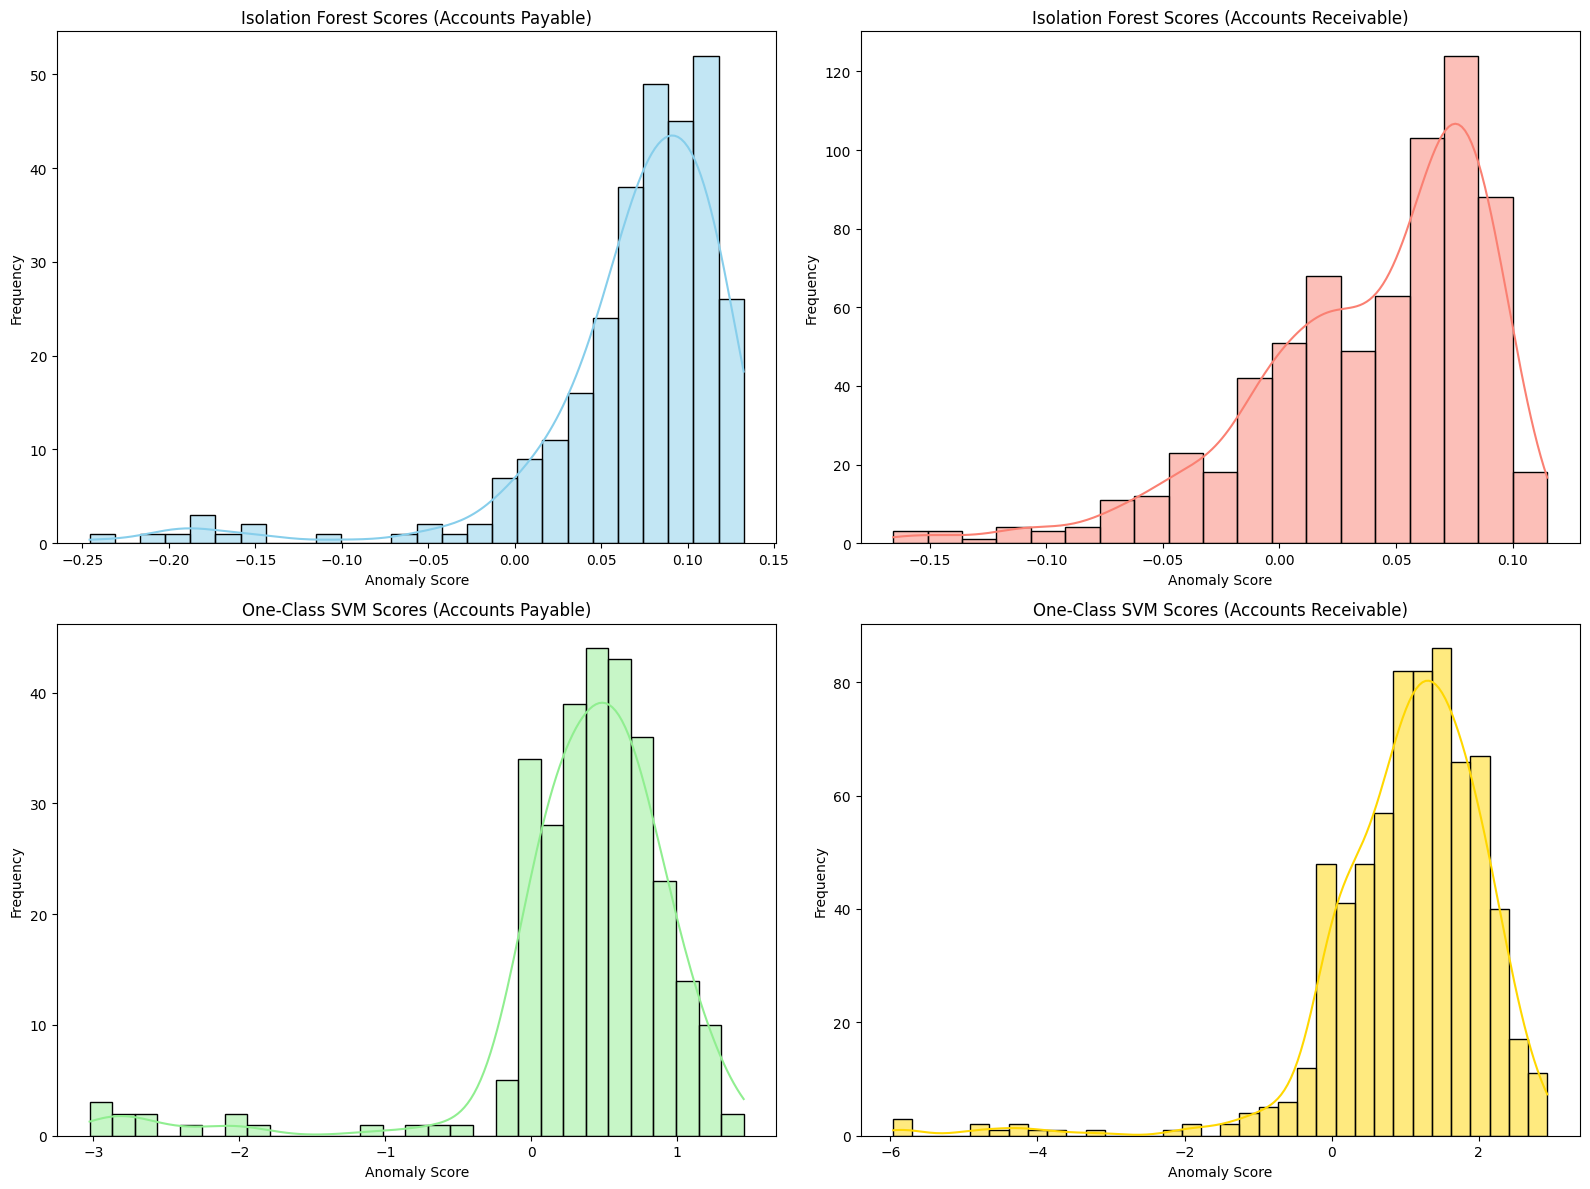

In [14]:
# Create a figure and axes for the plots
fig = plt.figure(figsize=(16, 12))

# Plotting Isolation Forest scores for AP data
ax1 = fig.add_subplot(2, 2, 1)
sns.histplot(raw_with_meta_ap['iso_forest_score'], kde=True, ax=ax1, color='skyblue')
ax1.set_title('Isolation Forest Scores (Accounts Payable)')
ax1.set_xlabel('Anomaly Score')
ax1.set_ylabel('Frequency')

# Plotting Isolation Forest scores for AR data
ax2 = fig.add_subplot(2, 2, 2)
sns.histplot(raw_with_meta_ar['iso_forest_score'], kde=True, ax=ax2, color='salmon')
ax2.set_title('Isolation Forest Scores (Accounts Receivable)')
ax2.set_xlabel('Anomaly Score')
ax2.set_ylabel('Frequency')

# Plotting One-Class SVM scores for AP data
ax3 = fig.add_subplot(2, 2, 3)
sns.histplot(raw_with_meta_ap['svm_score'], kde=True, ax=ax3, color='lightgreen')
ax3.set_title('One-Class SVM Scores (Accounts Payable)')
ax3.set_xlabel('Anomaly Score')
ax3.set_ylabel('Frequency')

# Plotting One-Class SVM scores for AR data
ax4 = fig.add_subplot(2, 2, 4)
sns.histplot(raw_with_meta_ar['svm_score'], kde=True, ax=ax4, color='gold')
ax4.set_title('One-Class SVM Scores (Accounts Receivable)')
ax4.set_xlabel('Anomaly Score')
ax4.set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

In [15]:
# Initialize and apply PCA for AP data
pca_ap_model = PCA(n_components=2, random_state=RANDOM_STATE)
pca_ap_components = pca_ap_model.fit_transform(X_ap)
pca_ap = pd.DataFrame(pca_ap_components, index=X_ap.index, columns=['PC1', 'PC2'])

# Initialize and apply PCA for AR data
pca_ar_model = PCA(n_components=2, random_state=RANDOM_STATE)
pca_ar_components = pca_ar_model.fit_transform(X_ar)
pca_ar = pd.DataFrame(pca_ar_components, index=X_ar.index, columns=['PC1', 'PC2'])

# Concatenate PCA results with the original dataframes
raw_with_meta_ap_pca = pd.concat([raw_with_meta_ap, pca_ap], axis=1)
raw_with_meta_ar_pca = pd.concat([raw_with_meta_ar, pca_ar], axis=1)

# Print shapes to verify
print("Shape of raw_with_meta_ap_pca:", raw_with_meta_ap_pca.shape)
print("Shape of raw_with_meta_ar_pca:", raw_with_meta_ar_pca.shape)

# Display head to inspect
print("\nFirst few rows of raw_with_meta_ap_pca:")
display(raw_with_meta_ap_pca.head())

print("\nFirst few rows of raw_with_meta_ar_pca:")
display(raw_with_meta_ar_pca.head())

Shape of raw_with_meta_ap_pca: (293, 45)
Shape of raw_with_meta_ar_pca: (688, 45)

First few rows of raw_with_meta_ap_pca:


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly,PC1,PC2
0,2023-08-18,NaN,NaN,Vendor_016,Accounts Payable (A/P),Expense_Category_012,0.000000e+00,1.643941e+09,0.750,2023,...,4,7,0.000000,-0.001215,-1,-1,-2.703396,-1,1.302949,1.535718
1,2023-01-01,Bill,NaN,Vendor_001,Accounts Payable (A/P),Expense_Category_001,1.814747e+08,1.825416e+09,0.125,2023,...,1,2,54.789560,-0.199816,-1,-1,-2.902938,-1,5.300010,7.086840
2,2023-01-02,Journal Entry,180R,Vendor_016,Accounts Payable (A/P),General_Adjustment,-1.622570e+09,2.028462e+08,0.125,2023,...,1,3,-489.874651,-0.245844,-1,-1,-3.025612,-1,19.114627,-12.121720
3,2023-01-03,Bill Payment (Cheque),133,Vendor_002,Accounts Payable (A/P),Bank_Account_001,-2.000000e+04,2.028262e+08,0.000,2023,...,1,2,-0.006038,0.072623,1,1,-0.027382,-1,-1.203584,-1.921072
4,2023-01-09,Journal Entry,210R,Vendor_016,Accounts Payable (A/P),General_Adjustment,-2.137148e+07,1.814547e+08,0.125,2023,...,1,3,-6.452324,-0.011160,-1,1,0.000020,1,1.454552,0.402715



First few rows of raw_with_meta_ar_pca:


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly,PC1,PC2
0,2023-06-07,NaN,NaN,Customer_002,Accounts Receivable (A/R) - USD,Sales,0.0,NaN,0.875,2023,...,3,8,0.000000,-0.004841,-1,-1,-5.961639,-1,-3.370019,-2.213155
1,2023-01-03,Payment,NaN,Customer_001,Accounts Receivable (A/R) - USD,Bank_Account_001,-94125000.0,-94125000.0,0.125,2023,...,6,8,-28.417548,0.059276,1,1,0.993222,1,-1.944009,-1.334778
2,2023-01-03,Invoice,1161,Customer_002,Accounts Receivable (A/R) - USD,Sales,8602687.6,-85522312.4,0.000,2023,...,12,46,2.597262,0.008070,1,1,0.105745,1,-2.103882,0.816771
3,2023-01-03,Payment,NaN,Customer_002,Accounts Receivable (A/R) - USD,Bank_Account_002,-43164238.0,-128686550.4,0.125,2023,...,12,46,-13.031839,0.018476,1,1,0.306821,1,-1.737048,-0.622445
4,2023-01-03,Invoice,1160,Customer_002,Accounts Receivable (A/R) - USD,Sales,43164238.0,-85522312.4,0.000,2023,...,12,46,13.031839,0.004749,1,1,0.244916,1,-1.896399,0.872978


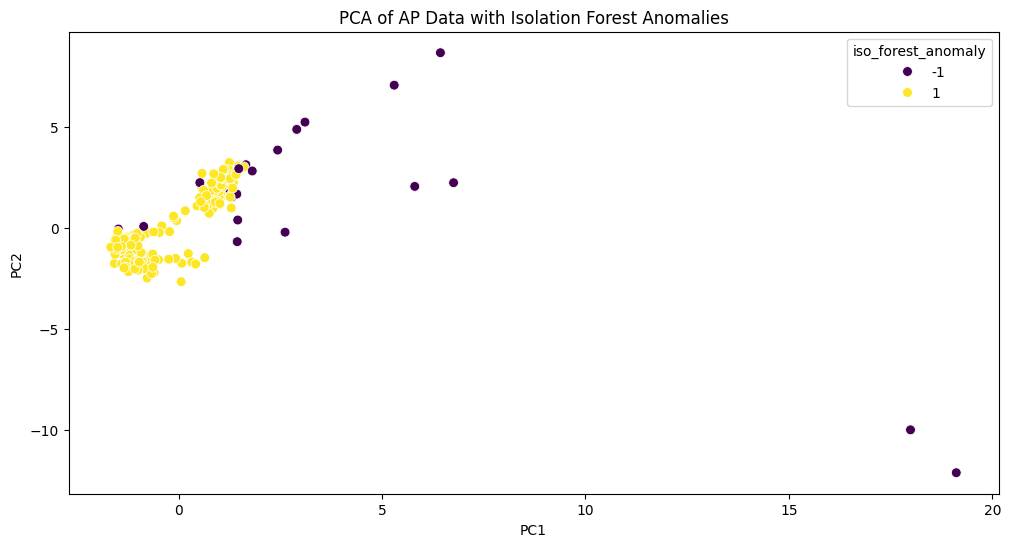

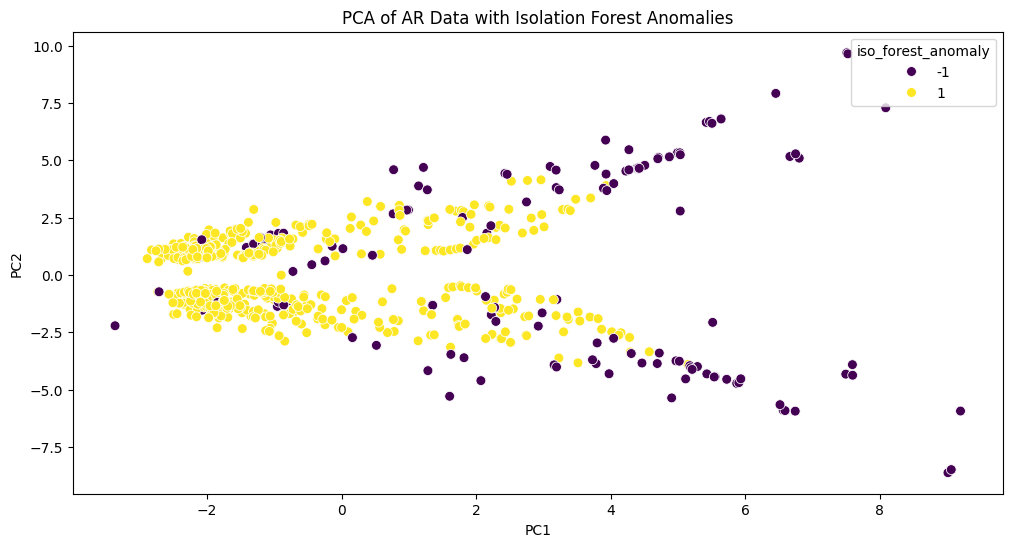

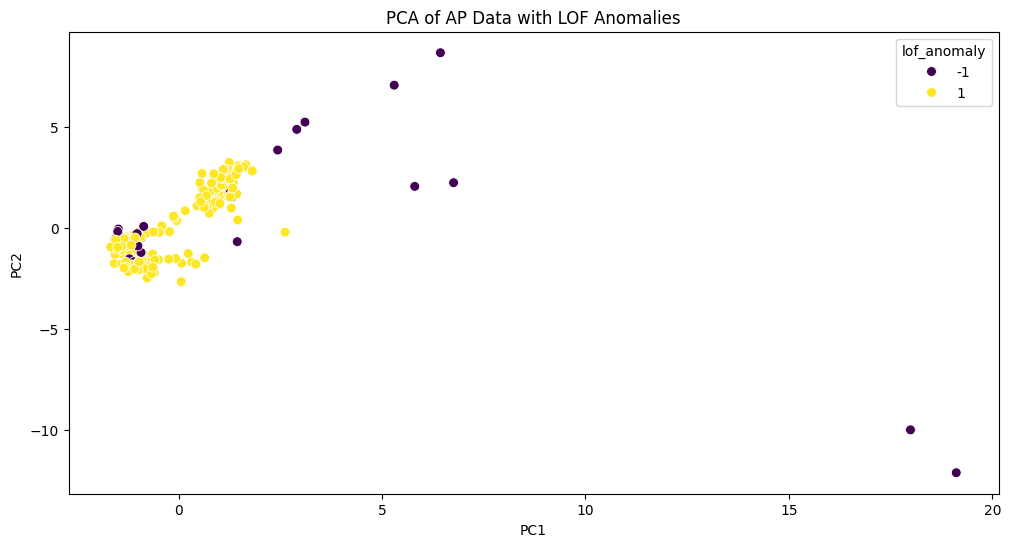

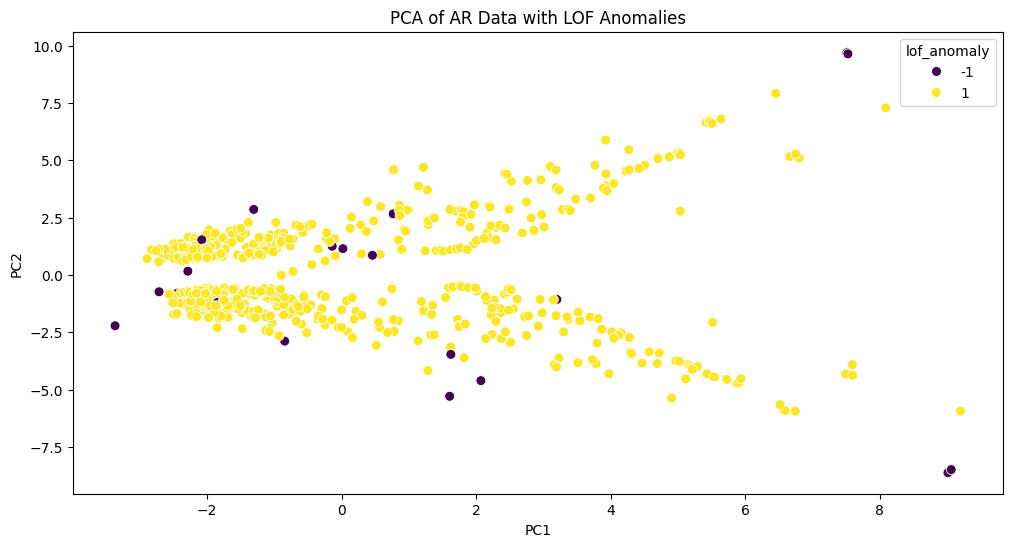

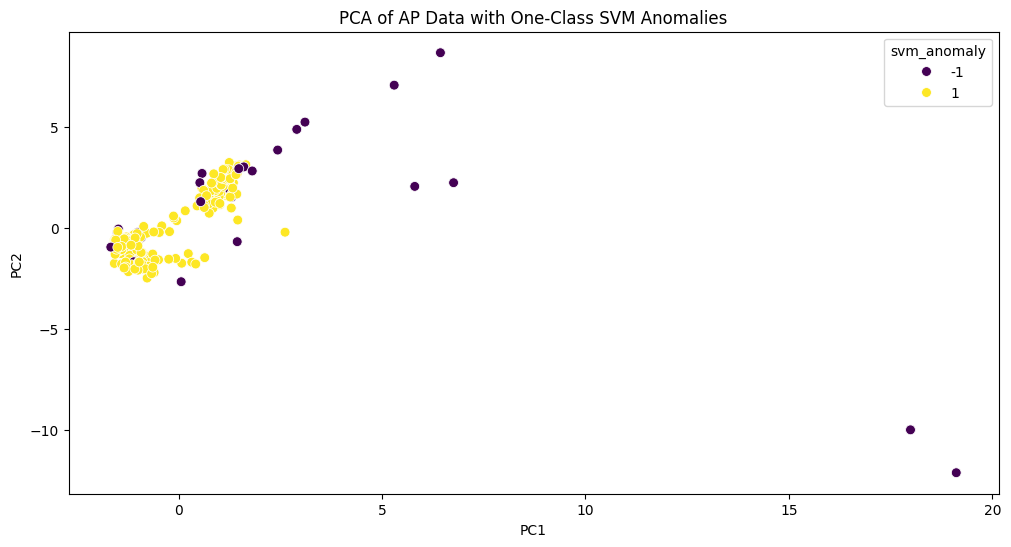

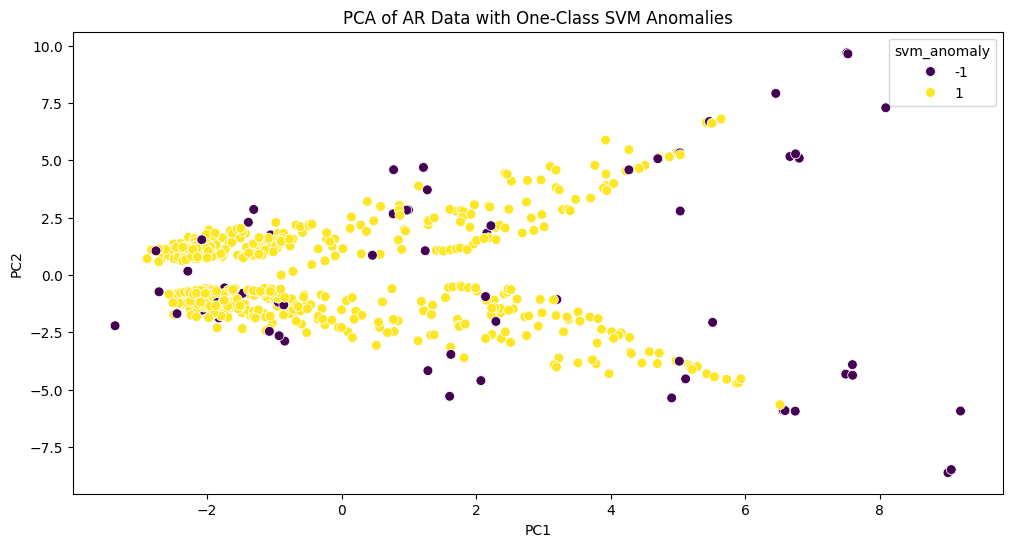

In [16]:
# Plotting PCA results for AP data with Isolation Forest anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='iso_forest_anomaly', data=raw_with_meta_ap_pca, palette='viridis', s=50)
plt.title('PCA of AP Data with Isolation Forest Anomalies')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Plotting PCA results for AR data with Isolation Forest anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='iso_forest_anomaly', data=raw_with_meta_ar_pca, palette='viridis', s=50)
plt.title('PCA of AR Data with Isolation Forest Anomalies')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Plotting PCA results for AP data with LOF anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='lof_anomaly', data=raw_with_meta_ap_pca, palette='viridis', s=50)
plt.title('PCA of AP Data with LOF Anomalies')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Plotting PCA results for AR data with LOF anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='lof_anomaly', data=raw_with_meta_ar_pca, palette='viridis', s=50)
plt.title('PCA of AR Data with LOF Anomalies')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Plotting PCA results for AP data with One-Class SVM anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='svm_anomaly', data=raw_with_meta_ap_pca, palette='viridis', s=50)
plt.title('PCA of AP Data with One-Class SVM Anomalies')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Plotting PCA results for AR data with One-Class SVM anomalies
plt.figure(figsize=(12, 6))
sns.scatterplot(x='PC1', y='PC2', hue='svm_anomaly', data=raw_with_meta_ar_pca, palette='viridis', s=50)
plt.title('PCA of AR Data with One-Class SVM Anomalies')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [17]:
# Identify anomalies flagged by Isolation Forest AND LOF for AP data
ap_iso_lof_overlap = raw_with_meta_ap_pca[(raw_with_meta_ap_pca['iso_forest_anomaly'] == -1) & (raw_with_meta_ap_pca['lof_anomaly'] == -1)]

# Identify anomalies flagged by Isolation Forest AND One-Class SVM for AP data
ap_iso_svm_overlap = raw_with_meta_ap_pca[(raw_with_meta_ap_pca['iso_forest_anomaly'] == -1) & (raw_with_meta_ap_pca['svm_anomaly'] == -1)]

# Identify anomalies flagged by LOF AND One-Class SVM for AP data
ap_lof_svm_overlap = raw_with_meta_ap_pca[(raw_with_meta_ap_pca['lof_anomaly'] == -1) & (raw_with_meta_ap_pca['svm_anomaly'] == -1)]

# Identify anomalies flagged by all three models for AP data
ap_all_overlap = raw_with_meta_ap_pca[(raw_with_meta_ap_pca['iso_forest_anomaly'] == -1) & (raw_with_meta_ap_pca['lof_anomaly'] == -1) & (raw_with_meta_ap_pca['svm_anomaly'] == -1)]

print("Accounts Payable Overlapping Anomalies:")
print(f"  Isolation Forest AND LOF: {ap_iso_lof_overlap.shape[0]}")
print(f"  Isolation Forest AND One-Class SVM: {ap_iso_svm_overlap.shape[0]}")
print(f"  LOF AND One-Class SVM: {ap_lof_svm_overlap.shape[0]}")
print(f"  All three models: {ap_all_overlap.shape[0]}")

print("\nFirst few rows of AP anomalies flagged by all three models:")
display(ap_all_overlap.head())

Accounts Payable Overlapping Anomalies:
  Isolation Forest AND LOF: 15
  Isolation Forest AND One-Class SVM: 17
  LOF AND One-Class SVM: 19
  All three models: 14

First few rows of AP anomalies flagged by all three models:


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly,PC1,PC2
0,2023-08-18,NaN,NaN,Vendor_016,Accounts Payable (A/P),Expense_Category_012,0.000000e+00,1.643941e+09,0.750,2023,...,4,7,0.000000,-0.001215,-1,-1,-2.703396,-1,1.302949,1.535718
1,2023-01-01,Bill,NaN,Vendor_001,Accounts Payable (A/P),Expense_Category_001,1.814747e+08,1.825416e+09,0.125,2023,...,1,2,54.789560,-0.199816,-1,-1,-2.902938,-1,5.300010,7.086840
2,2023-01-02,Journal Entry,180R,Vendor_016,Accounts Payable (A/P),General_Adjustment,-1.622570e+09,2.028462e+08,0.125,2023,...,1,3,-489.874651,-0.245844,-1,-1,-3.025612,-1,19.114627,-12.121720
14,2023-01-31,Bill Payment (Cheque),127,Vendor_001,Accounts Payable (A/P),Bank_Account_001,-1.814747e+08,2.274675e+06,0.000,2023,...,1,2,-54.789560,-0.187008,-1,-1,-2.712488,-1,5.805395,2.069527
20,2023-03-31,Journal Entry,294,Vendor_016,Accounts Payable (A/P),General_Adjustment,1.600000e+08,1.625494e+08,0.125,2023,...,2,2,48.306058,-0.148179,-1,-1,-2.751151,-1,3.107167,5.256096


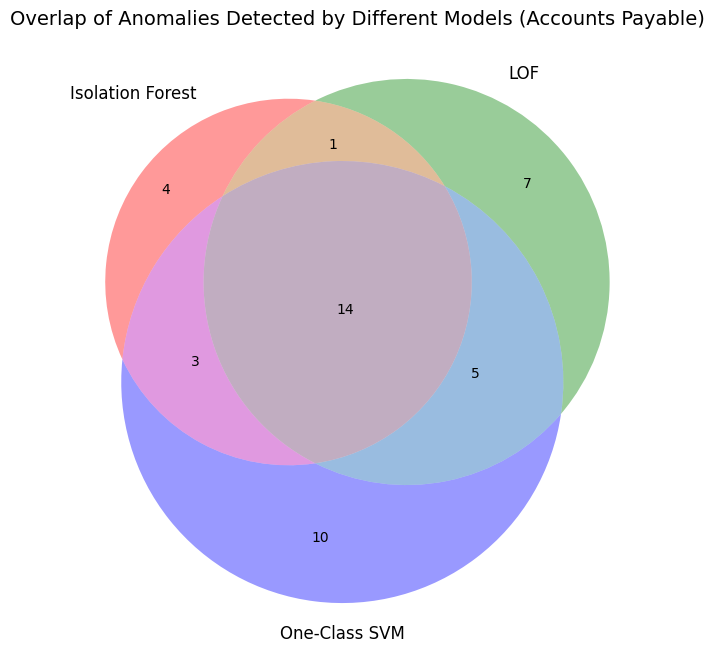

In [18]:
from matplotlib_venn import venn3

# Calculate overlaps for Venn diagram - AP data
# The venn3 function requires the sizes of the three sets and their intersections.
# The order is (Ab, aB, AB, Ac, aC, AC, ABC) where A=ISO, B=LOF, C=SVM
# Ab: ISO only
# aB: LOF only
# AB: ISO and LOF only
# Ac: ISO and SVM only
# aC: LOF and SVM only
# AC: ISO and SVM only (same as Ac, but the function uses this order)
# ABC: ISO, LOF, and SVM

# Total anomalies for each model (already calculated)
ap_iso_total = ap_iso_anomalies_count
ap_lof_total = ap_lof_anomalies_count
ap_svm_total = ap_svm_anomalies_count

# Overlaps (already calculated)
ap_iso_lof_overlap_count = ap_iso_lof_overlap.shape[0]
ap_iso_svm_overlap_count = ap_iso_svm_overlap.shape[0]
ap_lof_svm_overlap_count = ap_lof_svm_overlap.shape[0]
ap_all_overlap_count = ap_all_overlap.shape[0]

# Calculate unique overlaps
ap_iso_only = ap_iso_total - ap_iso_lof_overlap_count - ap_iso_svm_overlap_count + ap_all_overlap_count
ap_lof_only = ap_lof_total - ap_iso_lof_overlap_count - ap_lof_svm_overlap_count + ap_all_overlap_count
ap_svm_only = ap_svm_total - ap_iso_svm_overlap_count - ap_lof_svm_overlap_count + ap_all_overlap_count

# Calculate pairwise overlaps (excluding the all_overlap)
ap_iso_lof_only = ap_iso_lof_overlap_count - ap_all_overlap_count
ap_iso_svm_only = ap_iso_svm_overlap_count - ap_all_overlap_count
ap_lof_svm_only = ap_lof_svm_overlap_count - ap_all_overlap_count


# Create the Venn diagram
plt.figure(figsize=(10, 8))
venn3(subsets=(ap_iso_only, ap_lof_only, ap_iso_lof_only, ap_svm_only, ap_iso_svm_only, ap_lof_svm_only, ap_all_overlap_count),
      set_labels=('Isolation Forest', 'LOF', 'One-Class SVM'))
plt.title('Overlap of Anomalies Detected by Different Models (Accounts Payable)', fontsize=14)
plt.show()

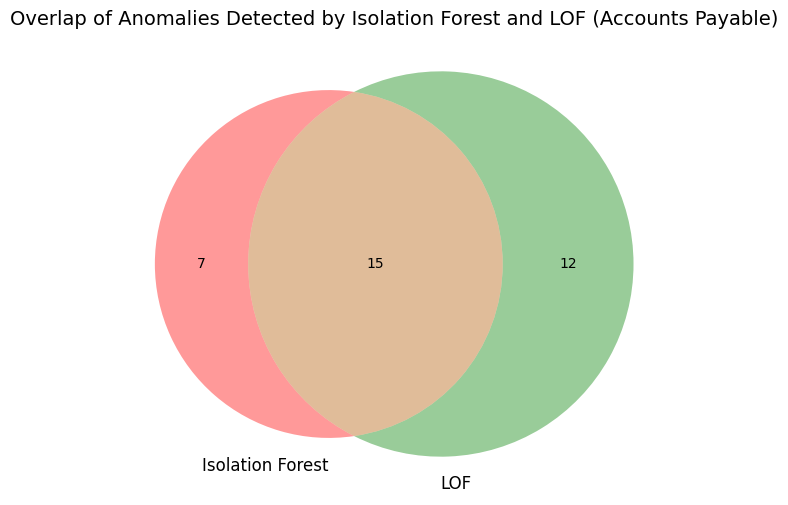

In [19]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate overlaps for 2-set Venn diagram (Isolation Forest and LOF) - AP data
# Sizes: (Ab, aB, AB) where A=Isolation Forest, B=LOF
# Ab: Isolation Forest only
# aB: LOF only
# AB: Isolation Forest and LOF

# Total anomalies for each model (already calculated in previous cells)
ap_iso_total = raw_with_meta_ap[raw_with_meta_ap['iso_forest_anomaly'] == -1].shape[0]
ap_lof_total = raw_with_meta_ap[raw_with_meta_ap['lof_anomaly'] == -1].shape[0]

# Overlap between Isolation Forest and LOF (already calculated in previous cells)
ap_iso_lof_overlap_count = raw_with_meta_ap[(raw_with_meta_ap['iso_forest_anomaly'] == -1) & (raw_with_meta_ap['lof_anomaly'] == -1)].shape[0]

# Calculate unique overlaps for the 2-set Venn diagram
ap_iso_only_for_venn2 = ap_iso_total - ap_iso_lof_overlap_count
ap_lof_only_for_venn2 = ap_lof_total - ap_iso_lof_overlap_count

# Create the 2-set Venn diagram
plt.figure(figsize=(8, 6))
venn2(subsets=(ap_iso_only_for_venn2, ap_lof_only_for_venn2, ap_iso_lof_overlap_count),
      set_labels=('Isolation Forest', 'LOF'))
plt.title('Overlap of Anomalies Detected by Isolation Forest and LOF (Accounts Payable)', fontsize=14)
plt.show()

In [20]:
print("Descriptive statistics for Accounts Payable anomalies flagged by all three models:")
display(ap_all_overlap.describe())

print("\nValue counts for key categorical/identifying columns in AP anomalies flagged by all three models:")
# Select some relevant columns to check value counts
key_ap_cols = ['Transaction Type', 'Name', 'Account', 'Split', 'year', 'month', 'day_of_week']
for col in key_ap_cols:
    if col in ap_all_overlap.columns:
        print(f"\nValue Counts for {col}:")
        display(ap_all_overlap[col].value_counts())
    else:
        print(f"\nColumn '{col}' not found in the anomaly DataFrame.")

print("\nFirst 10 rows of AP anomalies flagged by all three models:")
display(ap_all_overlap.head(10))

Descriptive statistics for Accounts Payable anomalies flagged by all three models:


,Date,Amount,Balance,nan_ratio,year,month,day,day_of_week,is_weekend,is_month_end,...,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly,PC1,PC2
count,14,1.400000e+01,1.200000e+01,14.000000,14.0,14.000000,14.000000,14.000000,14.000000,14.000000,...,14.000000,14.000000,14.000000,14.000000,14.0,14.0,14.000000,14.0,14.000000,14.000000
mean,2023-06-09 08:34:17.142857216,-2.855744e+08,5.002112e+08,0.250000,2023.0,5.714286,17.785714,2.857143,0.142857,0.285714,...,2.571429,5.142857,-86.218579,-0.135038,-1.0,-1.0,-2.153399,-1.0,6.444152,0.341287
min,2023-01-01 00:00:00,-1.622570e+09,2.274675e+06,0.000000,2023.0,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,-489.874651,-0.245844,-1.0,-1.0,-3.025612,-1.0,-1.478591,-12.121720
25%,2023-04-13 00:00:00,-2.096322e+08,2.008680e+08,0.125000,2023.0,3.500000,8.250000,1.250000,0.000000,0.000000,...,1.250000,2.000000,-63.290666,-0.187117,-1.0,-1.0,-2.805396,-1.0,1.690469,-0.513728
50%,2023-07-05 00:00:00,4.520879e+04,2.754190e+08,0.125000,2023.0,6.500000,18.000000,4.000000,0.000000,0.000000,...,2.000000,2.000000,0.013649,-0.158391,-1.0,-1.0,-2.550705,-1.0,4.203589,2.006817
75%,2023-08-18 00:00:00,1.093213e+08,4.174806e+08,0.125000,2023.0,8.000000,28.000000,4.000000,0.000000,0.750000,...,3.500000,7.000000,33.005519,-0.071907,-1.0,-1.0,-1.970349,-1.0,6.678736,4.639418
max,2023-09-30 00:00:00,2.190181e+08,1.825416e+09,0.875000,2023.0,9.000000,31.000000,6.000000,1.000000,1.000000,...,8.000000,26.000000,66.124367,-0.001215,-1.0,-1.0,-0.159988,-1.0,19.114627,8.694653
std,NaN,6.469204e+08,5.900326e+08,0.321505,0.0,3.148347,10.771605,1.994498,0.363137,0.468807,...,1.910066,6.443329,195.313589,0.079022,0.0,0.0,0.918377,0.0,6.857837,6.525044



Value counts for key categorical/identifying columns in AP anomalies flagged by all three models:

Value Counts for Transaction Type:


,count
Transaction Type,
Bill,4
Journal Entry,4
Bill Payment (Cheque),3



Value Counts for Name:


,count
Name,
Vendor_016,7
Vendor_001,2
Vendor_021,2
Vendor_039,2
Vendor_042,1



Value Counts for Account:


,count
Account,
Accounts Payable (A/P),14



Value Counts for Split:


,count
Split,
General_Adjustment,4
Expense_Category_012,3
Bank_Account_001,3
Expense_Category_001,1
Expense_Category_019,1
Expense_Category_033,1
Expense_Category_002,1



Value Counts for year:


,count
year,
2023,14



Value Counts for month:


,count
month,
8,4
1,3
5,3
9,3
3,1



Value Counts for day_of_week:


,count
day_of_week,
4,6
0,3
2,2
6,1
1,1
5,1



First 10 rows of AP anomalies flagged by all three models:


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly,PC1,PC2
0,2023-08-18,NaN,NaN,Vendor_016,Accounts Payable (A/P),Expense_Category_012,0.000000e+00,1.643941e+09,0.750,2023,...,4,7,0.000000,-0.001215,-1,-1,-2.703396,-1,1.302949,1.535718
1,2023-01-01,Bill,NaN,Vendor_001,Accounts Payable (A/P),Expense_Category_001,1.814747e+08,1.825416e+09,0.125,2023,...,1,2,54.789560,-0.199816,-1,-1,-2.902938,-1,5.300010,7.086840
2,2023-01-02,Journal Entry,180R,Vendor_016,Accounts Payable (A/P),General_Adjustment,-1.622570e+09,2.028462e+08,0.125,2023,...,1,3,-489.874651,-0.245844,-1,-1,-3.025612,-1,19.114627,-12.121720
14,2023-01-31,Bill Payment (Cheque),127,Vendor_001,Accounts Payable (A/P),Bank_Account_001,-1.814747e+08,2.274675e+06,0.000,2023,...,1,2,-54.789560,-0.187008,-1,-1,-2.712488,-1,5.805395,2.069527
20,2023-03-31,Journal Entry,294,Vendor_016,Accounts Payable (A/P),General_Adjustment,1.600000e+08,1.625494e+08,0.125,2023,...,2,2,48.306058,-0.148179,-1,-1,-2.751151,-1,3.107167,5.256096
67,2023-05-22,Bill,NaN,Vendor_021,Accounts Payable (A/P),Expense_Category_019,6.156000e+07,2.564931e+08,0.125,2023,...,2,2,18.585756,-0.043321,-1,-1,-1.090271,-1,1.107427,1.944108
68,2023-05-22,Bill Payment (Cheque),231,Vendor_021,Accounts Payable (A/P),Bank_Account_001,-6.156000e+07,1.949331e+08,0.000,2023,...,2,2,-18.585756,-0.062302,-1,-1,-0.159988,-1,1.441976,-0.670604
79,2023-05-31,Journal Entry,319,Vendor_016,Accounts Payable (A/P),General_Adjustment,7.728537e+07,2.777570e+08,0.125,2023,...,8,26,23.333447,-0.146228,-1,-1,-1.937250,-1,2.905729,4.895564
132,2023-08-09,Journal Entry,410,Vendor_016,Accounts Payable (A/P),General_Adjustment,1.200000e+08,3.922185e+08,0.125,2023,...,2,7,36.229543,-0.100722,-1,-1,-2.398013,-1,2.435948,3.870979
157,2023-09-08,Bill,NaN,Vendor_039,Accounts Payable (A/P),Expense_Category_033,2.190181e+08,4.932669e+08,0.125,2023,...,2,2,66.124367,-0.208364,-1,-1,-2.908030,-1,6.436250,8.694653


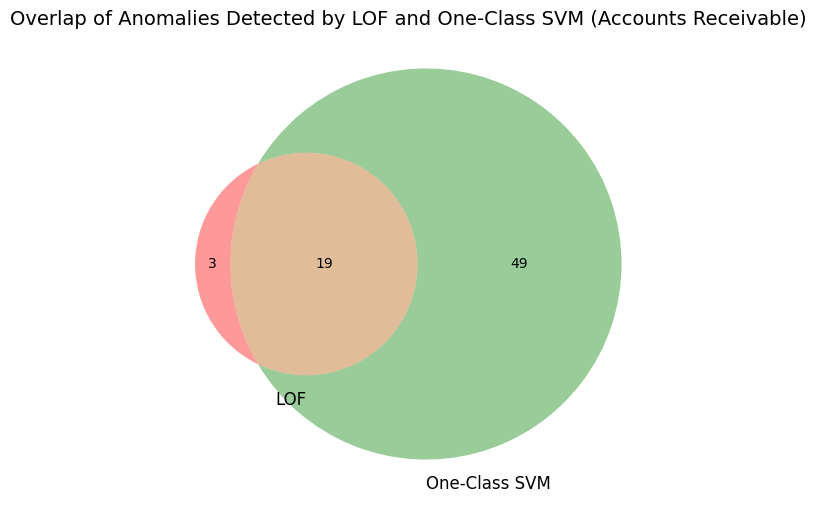

In [21]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate overlaps for 2-set Venn diagram (LOF and One-Class SVM) - AR data
# Sizes: (Ab, aB, AB) where A=LOF, B=One-Class SVM
# Ab: LOF only
# aB: One-Class SVM only
# AB: LOF and One-Class SVM

# Total anomalies for each model (already calculated in previous cells)
ar_lof_total = raw_with_meta_ar[raw_with_meta_ar['lof_anomaly'] == -1].shape[0]
ar_svm_total = raw_with_meta_ar[raw_with_meta_ar['svm_anomaly'] == -1].shape[0]

# Overlap between LOF and One-Class SVM (already calculated in previous cells)
ar_lof_svm_overlap_count = raw_with_meta_ar[(raw_with_meta_ar['lof_anomaly'] == -1) & (raw_with_meta_ar['svm_anomaly'] == -1)].shape[0]

# Calculate unique overlaps for the 2-set Venn diagram
ar_lof_only_for_venn2_svm = ar_lof_total - ar_lof_svm_overlap_count
ar_svm_only_for_venn2_lof = ar_svm_total - ar_lof_svm_overlap_count


# Create the 2-set Venn diagram
plt.figure(figsize=(8, 6))
venn2(subsets=(ar_lof_only_for_venn2_svm, ar_svm_only_for_venn2_lof, ar_lof_svm_overlap_count),
      set_labels=('LOF', 'One-Class SVM'))
plt.title('Overlap of Anomalies Detected by LOF and One-Class SVM (Accounts Receivable)', fontsize=14)
plt.show()

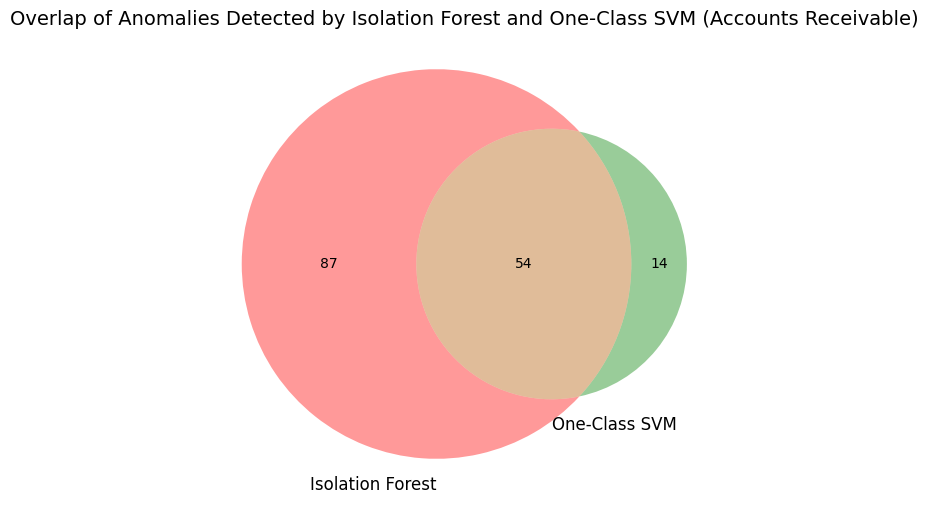

In [22]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate overlaps for 2-set Venn diagram (Isolation Forest and One-Class SVM) - AR data
# Sizes: (Ab, aB, AB) where A=Isolation Forest, B=One-Class SVM
# Ab: Isolation Forest only
# aB: One-Class SVM only
# AB: Isolation Forest and One-Class SVM

# Total anomalies for each model (already calculated in previous cells)
ar_iso_total = raw_with_meta_ar[raw_with_meta_ar['iso_forest_anomaly'] == -1].shape[0]
ar_svm_total = raw_with_meta_ar[raw_with_meta_ar['svm_anomaly'] == -1].shape[0]

# Overlap between Isolation Forest and One-Class SVM (already calculated in previous cells)
ar_iso_svm_overlap_count = raw_with_meta_ar[(raw_with_meta_ar['iso_forest_anomaly'] == -1) & (raw_with_meta_ar['svm_anomaly'] == -1)].shape[0]

# Calculate unique overlaps for the 2-set Venn diagram
ar_iso_only_for_venn2_svm = ar_iso_total - ar_iso_svm_overlap_count
ar_svm_only_for_venn2_svm = ar_svm_total - ar_iso_svm_overlap_count

# Create the 2-set Venn diagram
plt.figure(figsize=(8, 6))
venn2(subsets=(ar_iso_only_for_venn2_svm, ar_svm_only_for_venn2_svm, ar_iso_svm_overlap_count),
      set_labels=('Isolation Forest', 'One-Class SVM'))
plt.title('Overlap of Anomalies Detected by Isolation Forest and One-Class SVM (Accounts Receivable)', fontsize=14)
plt.show()

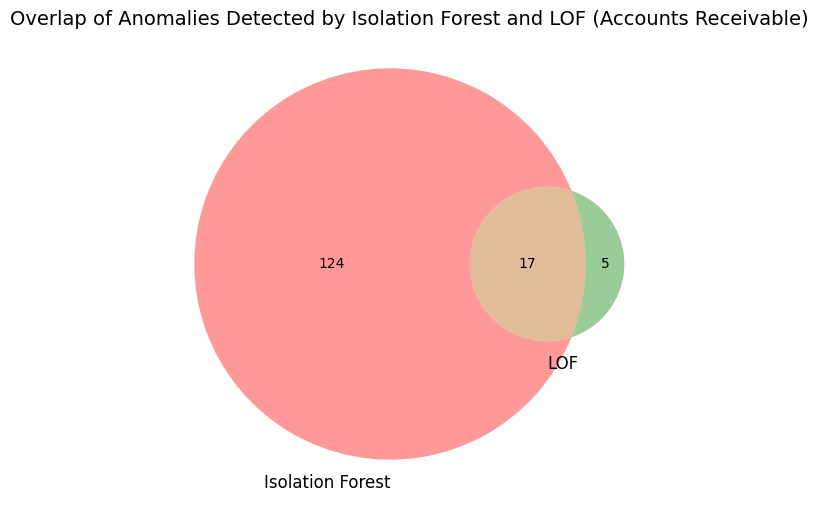

In [23]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate overlaps for 2-set Venn diagram (Isolation Forest and LOF) - AR data
# Sizes: (Ab, aB, AB) where A=Isolation Forest, B=LOF
# Ab: Isolation Forest only
# aB: LOF only
# AB: Isolation Forest and LOF

# Total anomalies for each model (already calculated in previous cells)
ar_iso_total = raw_with_meta_ar[raw_with_meta_ar['iso_forest_anomaly'] == -1].shape[0]
ar_lof_total = raw_with_meta_ar[raw_with_meta_ar['lof_anomaly'] == -1].shape[0]

# Overlap between Isolation Forest and LOF (already calculated in previous cells)
ar_iso_lof_overlap_count = raw_with_meta_ar[(raw_with_meta_ar['iso_forest_anomaly'] == -1) & (raw_with_meta_ar['lof_anomaly'] == -1)].shape[0]

# Calculate unique overlaps for the 2-set Venn diagram
ar_iso_only_for_venn2_lof = ar_iso_total - ar_iso_lof_overlap_count
ar_lof_only_for_venn2_iso = ar_lof_total - ar_iso_lof_overlap_count

# Create the 2-set Venn diagram
plt.figure(figsize=(8, 6))
venn2(subsets=(ar_iso_only_for_venn2_lof, ar_lof_only_for_venn2_iso, ar_iso_lof_overlap_count),
      set_labels=('Isolation Forest', 'LOF'))
plt.title('Overlap of Anomalies Detected by Isolation Forest and LOF (Accounts Receivable)', fontsize=14)
plt.show()

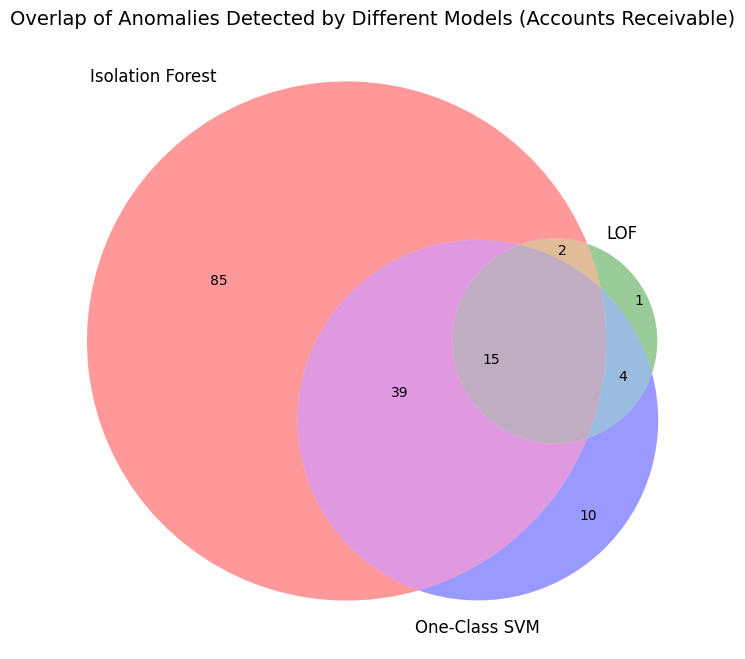

In [24]:
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Calculate overlaps for Venn diagram - AR data
# Total anomalies for each model (already calculated)
ar_iso_total = raw_with_meta_ar[raw_with_meta_ar['iso_forest_anomaly'] == -1].shape[0]
ar_lof_total = raw_with_meta_ar[raw_with_meta_ar['lof_anomaly'] == -1].shape[0]
ar_svm_total = raw_with_meta_ar[raw_with_meta_ar['svm_anomaly'] == -1].shape[0]

# Overlaps (calculated in previous cells)
ar_iso_lof_overlap = raw_with_meta_ar[(raw_with_meta_ar['iso_forest_anomaly'] == -1) & (raw_with_meta_ar['lof_anomaly'] == -1)]
ar_iso_svm_overlap = raw_with_meta_ar[(raw_with_meta_ar['iso_forest_anomaly'] == -1) & (raw_with_meta_ar['svm_anomaly'] == -1)]
ar_lof_svm_overlap = raw_with_meta_ar[(raw_with_meta_ar['lof_anomaly'] == -1) & (raw_with_meta_ar['svm_anomaly'] == -1)]
ar_all_overlap = raw_with_meta_ar[(raw_with_meta_ar['iso_forest_anomaly'] == -1) & (raw_with_meta_ar['lof_anomaly'] == -1) & (raw_with_meta_ar['svm_anomaly'] == -1)]


ar_iso_lof_overlap_count = ar_iso_lof_overlap.shape[0]
ar_iso_svm_overlap_count = ar_iso_svm_overlap.shape[0]
ar_lof_svm_overlap_count = ar_lof_svm_overlap.shape[0]
ar_all_overlap_count = ar_all_overlap.shape[0]


# Calculate unique overlaps
ar_iso_only = ar_iso_total - ar_iso_lof_overlap_count - ar_iso_svm_overlap_count + ar_all_overlap_count
ar_lof_only = ar_lof_total - ar_iso_lof_overlap_count - ar_lof_svm_overlap_count + ar_all_overlap_count
ar_svm_only = ar_svm_total - ar_iso_svm_overlap_count - ar_lof_svm_overlap_count + ar_all_overlap_count

# Calculate pairwise overlaps (excluding the all_overlap)
ar_iso_lof_only = ar_iso_lof_overlap_count - ar_all_overlap_count
ar_iso_svm_only = ar_iso_svm_overlap_count - ar_all_overlap_count
ar_lof_svm_only = ar_lof_svm_overlap_count - ar_all_overlap_count


# Create the Venn diagram for AR data
plt.figure(figsize=(10, 8))
venn3(subsets=(ar_iso_only, ar_lof_only, ar_iso_lof_only, ar_svm_only, ar_iso_svm_only, ar_lof_svm_only, ar_all_overlap_count),
      set_labels=('Isolation Forest', 'LOF', 'One-Class SVM'))
plt.title('Overlap of Anomalies Detected by Different Models (Accounts Receivable)', fontsize=14)
plt.show()

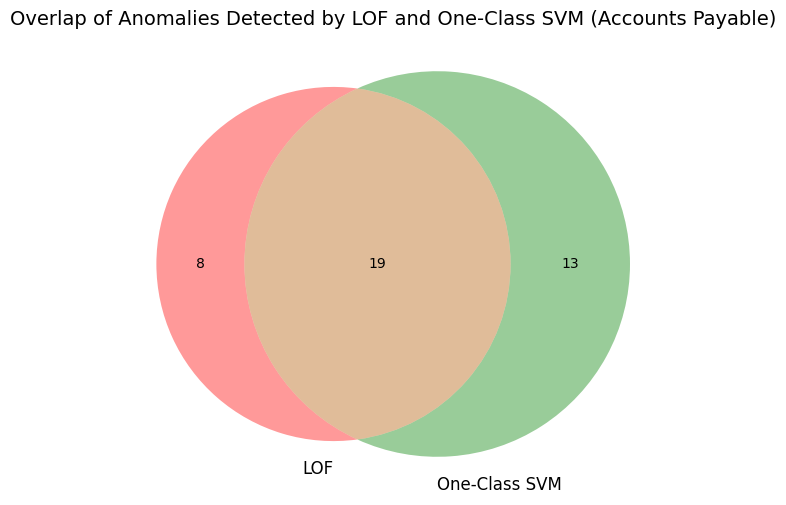

In [25]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate overlaps for 2-set Venn diagram (LOF and One-Class SVM) - AP data
# Sizes: (Ab, aB, AB) where A=LOF, B=One-Class SVM
# Ab: LOF only
# aB: One-Class SVM only
# AB: LOF and One-Class SVM

# Total anomalies for each model (already calculated in previous cells)
ap_lof_total = raw_with_meta_ap[raw_with_meta_ap['lof_anomaly'] == -1].shape[0]
ap_svm_total = raw_with_meta_ap[raw_with_meta_ap['svm_anomaly'] == -1].shape[0]

# Overlap between LOF and One-Class SVM (already calculated in previous cells)
ap_lof_svm_overlap_count = raw_with_meta_ap[(raw_with_meta_ap['lof_anomaly'] == -1) & (raw_with_meta_ap['svm_anomaly'] == -1)].shape[0]

# Calculate unique overlaps for the 2-set Venn diagram
ap_lof_only_for_venn2_svm = ap_lof_total - ap_lof_svm_overlap_count
ap_svm_only_for_venn2_lof = ap_svm_total - ap_lof_svm_overlap_count


# Create the 2-set Venn diagram
plt.figure(figsize=(8, 6))
venn2(subsets=(ap_lof_only_for_venn2_svm, ap_svm_only_for_venn2_lof, ap_lof_svm_overlap_count),
      set_labels=('LOF', 'One-Class SVM'))
plt.title('Overlap of Anomalies Detected by LOF and One-Class SVM (Accounts Payable)', fontsize=14)
plt.show()

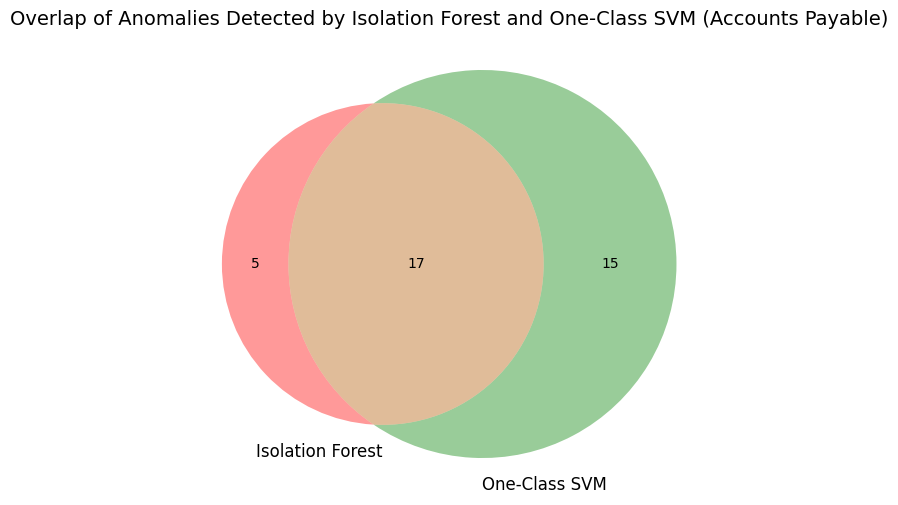

In [26]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate overlaps for 2-set Venn diagram (Isolation Forest and One-Class SVM) - AP data
# Sizes: (Ab, aB, AB) where A=Isolation Forest, B=One-Class SVM
# Ab: Isolation Forest only
# aB: One-Class SVM only
# AB: Isolation Forest and One-Class SVM

# Total anomalies for each model (already calculated in previous cells)
ap_iso_total = raw_with_meta_ap[raw_with_meta_ap['iso_forest_anomaly'] == -1].shape[0]
ap_svm_total = raw_with_meta_ap[raw_with_meta_ap['svm_anomaly'] == -1].shape[0]

# Overlap between Isolation Forest and One-Class SVM (already calculated in previous cells)
ap_iso_svm_overlap_count = raw_with_meta_ap[(raw_with_meta_ap['iso_forest_anomaly'] == -1) & (raw_with_meta_ap['svm_anomaly'] == -1)].shape[0]

# Calculate unique overlaps for the 2-set Venn diagram
ap_iso_only_for_venn2_svm = ap_iso_total - ap_iso_svm_overlap_count
ap_svm_only_for_venn2_svm = ap_svm_total - ap_iso_svm_overlap_count

# Create the 2-set Venn diagram
plt.figure(figsize=(8, 6))
venn2(subsets=(ap_iso_only_for_venn2_svm, ap_svm_only_for_venn2_svm, ap_iso_svm_overlap_count),
      set_labels=('Isolation Forest', 'One-Class SVM'))
plt.title('Overlap of Anomalies Detected by Isolation Forest and One-Class SVM (Accounts Payable)', fontsize=14)
plt.show()

Accounts Receivable Overlapping Anomalies:
  Isolation Forest AND LOF: 17
  Isolation Forest AND One-Class SVM: 54
  LOF AND One-Class SVM: 19
  All three models: 15

First few rows of AR anomalies flagged by all three models:


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly,PC1,PC2
0,2023-06-07,NaN,NaN,Customer_002,Accounts Receivable (A/R) - USD,Sales,0.000000e+00,NaN,0.875,2023,...,3,8,0.000000,-0.004841,-1,-1,-5.961639,-1,-3.370019,-2.213155
161,2023-03-17,Payment,NaN,Customer_021,Accounts Receivable (A/R) - USD,-Split-,0.000000e+00,-9.878745e+08,0.125,2023,...,1,3,0.000000,-0.021672,-1,-1,-4.429780,-1,-2.715452,-0.732008
311,2023-05-31,Payment,NaN,Customer_004,Accounts Receivable (A/R) - USD,Bank_Account_001,-3.830000e+09,3.285210e+09,0.125,2023,...,4,8,-1156.326252,-0.083611,-1,-1,-3.130080,-1,2.069756,-4.606830
401,2023-07-01,Journal Entry,359R,Customer_002,Accounts Receivable (A/R) - USD,-Split-,-2.980667e+09,-2.962186e+09,0.125,2023,...,2,2,-899.901842,-0.085449,-1,-1,-5.803272,-1,1.605099,-5.289473
443,2023-07-28,Invoice,1425,Customer_003,Accounts Receivable (A/R) - USD,Sales,1.229200e+10,9.303039e+09,0.000,2023,...,2,4,3711.112869,-0.141697,-1,-1,-4.187803,-1,7.511059,9.693965


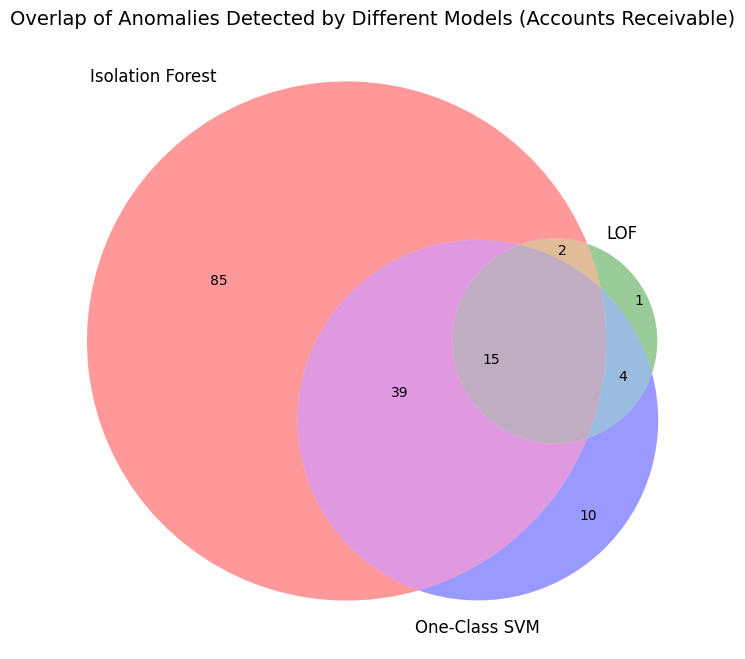

In [27]:
# Identify anomalies flagged by Isolation Forest AND LOF for AR data
ar_iso_lof_overlap = raw_with_meta_ar_pca[(raw_with_meta_ar_pca['iso_forest_anomaly'] == -1) & (raw_with_meta_ar_pca['lof_anomaly'] == -1)]

# Identify anomalies flagged by Isolation Forest AND One-Class SVM for AR data
ar_iso_svm_overlap = raw_with_meta_ar_pca[(raw_with_meta_ar_pca['iso_forest_anomaly'] == -1) & (raw_with_meta_ar_pca['svm_anomaly'] == -1)]

# Identify anomalies flagged by LOF AND One-Class SVM for AR data
ar_lof_svm_overlap = raw_with_meta_ar_pca[(raw_with_meta_ar_pca['lof_anomaly'] == -1) & (raw_with_meta_ar_pca['svm_anomaly'] == -1)]

# Identify anomalies flagged by all three models for AR data
ar_all_overlap = raw_with_meta_ar_pca[(raw_with_meta_ar_pca['iso_forest_anomaly'] == -1) & (raw_with_meta_ar_pca['lof_anomaly'] == -1) & (raw_with_meta_ar_pca['svm_anomaly'] == -1)]

print("Accounts Receivable Overlapping Anomalies:")
print(f"  Isolation Forest AND LOF: {ar_iso_lof_overlap.shape[0]}")
print(f"  Isolation Forest AND One-Class SVM: {ar_iso_svm_overlap.shape[0]}")
print(f"  LOF AND One-Class SVM: {ar_lof_svm_overlap.shape[0]}")
print(f"  All three models: {ar_all_overlap.shape[0]}")

print("\nFirst few rows of AR anomalies flagged by all three models:")
display(ar_all_overlap.head())

# Calculate overlaps for Venn diagram - AR data
# Total anomalies for each model (already calculated)
ar_iso_total = ar_iso_anomalies_count
ar_lof_total = ar_lof_anomalies_count
ar_svm_total = ar_svm_anomalies_count

# Overlaps (calculated above)
ar_iso_lof_overlap_count = ar_iso_lof_overlap.shape[0]
ar_iso_svm_overlap_count = ar_iso_svm_overlap.shape[0]
ar_lof_svm_overlap_count = ar_lof_svm_overlap.shape[0]
ar_all_overlap_count = ar_all_overlap.shape[0]

# Calculate unique overlaps
ar_iso_only = ar_iso_total - ar_iso_lof_overlap_count - ar_iso_svm_overlap_count + ar_all_overlap_count
ar_lof_only = ar_lof_total - ar_iso_lof_overlap_count - ar_lof_svm_overlap_count + ar_all_overlap_count
ar_svm_only = ar_svm_total - ar_iso_svm_overlap_count - ar_lof_svm_overlap_count + ar_all_overlap_count

# Calculate pairwise overlaps (excluding the all_overlap)
ar_iso_lof_only = ar_iso_lof_overlap_count - ar_all_overlap_count
ar_iso_svm_only = ar_iso_svm_overlap_count - ar_all_overlap_count
ar_lof_svm_only = ar_lof_svm_overlap_count - ar_all_overlap_count

# Create the Venn diagram for AR data
plt.figure(figsize=(10, 8))
venn3(subsets=(ar_iso_only, ar_lof_only, ar_iso_lof_only, ar_svm_only, ar_iso_svm_only, ar_lof_svm_only, ar_all_overlap_count),
      set_labels=('Isolation Forest', 'LOF', 'One-Class SVM'))
plt.title('Overlap of Anomalies Detected by Different Models (Accounts Receivable)', fontsize=14)
plt.show()

In [28]:
# Explain how each model detects anomalies and display relevant outputs

print("--- Understanding Anomaly Detection Model Outputs ---")

# Isolation Forest
print("\nIsolation Forest:")
print("Isolation Forest isolates anomalies by randomly selecting a feature and then randomly selecting a split point between the maximum and minimum values of the selected feature. This partitioning creates 'isolation trees'. Anomalies are transactions that are isolated in fewer splits (i.e., closer to the root of the tree) because they are different from the majority of the data. The 'iso_forest_score' represents the anomaly score, where lower scores indicate a higher likelihood of being an anomaly. The 'iso_forest_anomaly' column is the prediction (-1 for anomaly, 1 for inlier) based on a threshold derived from the contamination parameter.")
print("\nFirst 5 rows of AP data with Isolation Forest scores and predictions:")
display(raw_with_meta_ap[['Amount', 'iso_forest_score', 'iso_forest_anomaly']].head())
print("\nFirst 5 rows of AR data with Isolation Forest scores and predictions:")
display(raw_with_meta_ar[['Amount', 'iso_forest_score', 'iso_forest_anomaly']].head())


# Local Outlier Factor (LOF)
print("\nLocal Outlier Factor (LOF):")
print("LOF measures the local deviation of density of a given data point with respect to its neighbors. It considers as outliers samples that have a substantially lower density than their neighbors. The 'lof_anomaly' column provides the prediction (-1 for anomaly, 1 for inlier). Note that with 'novelty=True', LOF does not provide a direct anomaly score like decision_function for each data point in the training set in the same way as Isolation Forest or One-Class SVM.")
print("\nFirst 5 rows of AP data with LOF predictions:")
display(raw_with_meta_ap[['Amount', 'lof_anomaly']].head())
print("\nFirst 5 rows of AR data with LOF predictions:")
display(raw_with_meta_ar[['Amount', 'lof_anomaly']].head())


# One-Class SVM
print("\nOne-Class SVM:")
print("One-Class SVM is an unsupervised algorithm that learns a decision boundary to separate the data points from the origin in the feature space. It tries to find a hyperplane that best separates the data points from the origin, effectively enclosing the 'normal' data. Transactions that fall outside this boundary are considered anomalies. The 'svm_score' is the signed distance from the decision boundary, where negative scores indicate anomalies. The 'svm_anomaly' column is the prediction (-1 for anomaly, 1 for inlier) based on the decision boundary.")
print("\nFirst 5 rows of AP data with One-Class SVM scores and predictions:")
display(raw_with_meta_ap[['Amount', 'svm_score', 'svm_anomaly']].head())
print("\nFirst 5 rows of AR data with One-Class SVM scores and predictions:")
display(raw_with_meta_ar[['Amount', 'svm_score', 'svm_anomaly']].head())

print("\n--- End of Model Output Explanation ---")

--- Understanding Anomaly Detection Model Outputs ---

Isolation Forest:
Isolation Forest isolates anomalies by randomly selecting a feature and then randomly selecting a split point between the maximum and minimum values of the selected feature. This partitioning creates 'isolation trees'. Anomalies are transactions that are isolated in fewer splits (i.e., closer to the root of the tree) because they are different from the majority of the data. The 'iso_forest_score' represents the anomaly score, where lower scores indicate a higher likelihood of being an anomaly. The 'iso_forest_anomaly' column is the prediction (-1 for anomaly, 1 for inlier) based on a threshold derived from the contamination parameter.

First 5 rows of AP data with Isolation Forest scores and predictions:


,Amount,iso_forest_score,iso_forest_anomaly
0,0.000000e+00,-0.001215,-1
1,1.814747e+08,-0.199816,-1
2,-1.622570e+09,-0.245844,-1
3,-2.000000e+04,0.072623,1
4,-2.137148e+07,-0.011160,-1



First 5 rows of AR data with Isolation Forest scores and predictions:


,Amount,iso_forest_score,iso_forest_anomaly
0,0.0,-0.004841,-1
1,-94125000.0,0.059276,1
2,8602687.6,0.008070,1
3,-43164238.0,0.018476,1
4,43164238.0,0.004749,1



Local Outlier Factor (LOF):
LOF measures the local deviation of density of a given data point with respect to its neighbors. It considers as outliers samples that have a substantially lower density than their neighbors. The 'lof_anomaly' column provides the prediction (-1 for anomaly, 1 for inlier). Note that with 'novelty=True', LOF does not provide a direct anomaly score like decision_function for each data point in the training set in the same way as Isolation Forest or One-Class SVM.

First 5 rows of AP data with LOF predictions:


,Amount,lof_anomaly
0,0.000000e+00,-1
1,1.814747e+08,-1
2,-1.622570e+09,-1
3,-2.000000e+04,1
4,-2.137148e+07,1



First 5 rows of AR data with LOF predictions:


,Amount,lof_anomaly
0,0.0,-1
1,-94125000.0,1
2,8602687.6,1
3,-43164238.0,1
4,43164238.0,1



One-Class SVM:
One-Class SVM is an unsupervised algorithm that learns a decision boundary to separate the data points from the origin in the feature space. It tries to find a hyperplane that best separates the data points from the origin, effectively enclosing the 'normal' data. Transactions that fall outside this boundary are considered anomalies. The 'svm_score' is the signed distance from the decision boundary, where negative scores indicate anomalies. The 'svm_anomaly' column is the prediction (-1 for anomaly, 1 for inlier) based on the decision boundary.

First 5 rows of AP data with One-Class SVM scores and predictions:


,Amount,svm_score,svm_anomaly
0,0.000000e+00,-2.703396,-1
1,1.814747e+08,-2.902938,-1
2,-1.622570e+09,-3.025612,-1
3,-2.000000e+04,-0.027382,-1
4,-2.137148e+07,0.000020,1



First 5 rows of AR data with One-Class SVM scores and predictions:


,Amount,svm_score,svm_anomaly
0,0.0,-5.961639,-1
1,-94125000.0,0.993222,1
2,8602687.6,0.105745,1
3,-43164238.0,0.306821,1
4,43164238.0,0.244916,1



--- End of Model Output Explanation ---


In [29]:
import pandas as pd

def generate_review_list(df,
                         txn_id_col='TransactionID',
                         vendor_col='Vendor',
                         date_col='Date',
                         amount_col='Amount',
                         anomaly_score_col='anomaly_score',  # e.g. from LightGBM or ensemble
                         flag_cols=['iso_forest_anomaly', 'lof_anomaly', 'svm_anomaly'],
                         notes_col='notes'):  # optional column for audit notes

    df_copy = df.copy()

    # Create Models Flagged column
    def flagged_models(row):
        models = []
        if row['iso_forest_anomaly'] == -1:
            models.append('IF')
        if row['lof_anomaly'] == -1:
            models.append('LOF')
        if row['svm_anomaly'] == -1:
            models.append('OC-SVM')
        return ' + '.join(models) if models else 'None'

    df_copy['Models Flagged'] = df_copy.apply(flagged_models, axis=1)

    # Compute priority score: anomaly score + number of models that flagged it
    df_copy['model_flag_count'] = df_copy[flag_cols].apply(lambda x: (x == -1).sum(), axis=1)
    df_copy['priority_score'] = df_copy[anomaly_score_col] + df_copy['model_flag_count']

    # Assign Priority Tier
    def assign_tier(score):
        if score >= 2.5:
            return 'Very High'
        elif score >= 2.0:
            return 'High'
        elif score >= 1.5:
            return 'Medium'
        else:
            return 'Low'

    df_copy['Priority Tier'] = df_copy['priority_score'].apply(assign_tier)

    # Rank by priority score
    df_copy['Rank'] = df_copy['priority_score'].rank(method='first', ascending=False).astype(int)

    # Format amount with currency
    df_copy['Amount'] = df_copy[amount_col].apply(lambda x: f"₦{x:,.0f}")

    # Define the list of columns to include, conditionally adding notes_col
    review_cols = [
        'Rank',
        txn_id_col,
        vendor_col,
        date_col,
        'Amount',
        anomaly_score_col,
        'Models Flagged',
        'Priority Tier'
    ]
    if notes_col in df_copy.columns:
        review_cols.append(notes_col)


    # Final review list
    review_list = df_copy.sort_values(by='Rank')[review_cols]


    return review_list

In [30]:
# Combine AP and AR data for review list generation
# Add a source column to distinguish between AP and AR transactions
raw_with_meta_ap['Source'] = 'AP'
raw_with_meta_ar['Source'] = 'AR'

# Concatenate the two dataframes
combined_data = pd.concat([raw_with_meta_ap, raw_with_meta_ar], ignore_index=True)

# Rename iso_forest_score to anomaly_score for the generate_review_list function
# In a real scenario, you might use a combined score or a score from a different model (e.g., LightGBM as initially intended)
combined_data = combined_data.rename(columns={'iso_forest_score': 'anomaly_score'})


review_df = generate_review_list(
    df=combined_data,
    txn_id_col='No.', # Assuming 'No.' can serve as a transaction ID; update if a dedicated ID exists
    vendor_col='Name',
    date_col='Date',
    amount_col='Amount',
    anomaly_score_col='anomaly_score', # Using the renamed Isolation Forest score as placeholder
    flag_cols=['iso_forest_anomaly', 'lof_anomaly', 'svm_anomaly']
    # Removed notes_col as it does not exist in the dataframe
)

# View top 5 transactions
display(review_df.head())

,Rank,No.,Name,Date,Amount,anomaly_score,Models Flagged,Priority Tier
0,1,NaN,Vendor_016,2023-08-18,₦0,-0.001215,IF + LOF + OC-SVM,Very High
738,2,1432,Customer_042,2023-07-31,"₦21,928,500",-0.002341,IF + LOF + OC-SVM,Very High
739,3,NaN,Customer_042,2023-07-31,"₦-21,928,500",-0.003731,IF + LOF + OC-SVM,Very High
163,4,NaN,Vendor_042,2023-09-30,"₦90,418",-0.004698,IF + LOF + OC-SVM,Very High
293,5,NaN,Customer_002,2023-06-07,₦0,-0.004841,IF + LOF + OC-SVM,Very High


In [31]:
# Add the 'is_anomaly' column to AP data
raw_with_meta_ap['is_anomaly'] = np.where((raw_with_meta_ap['iso_forest_anomaly'] == -1) & (raw_with_meta_ap['svm_anomaly'] == -1), 1, 0)

# Add the 'is_anomaly' column to AR data
raw_with_meta_ar['is_anomaly'] = np.where((raw_with_meta_ar['iso_forest_anomaly'] == -1) & (raw_with_meta_ar['svm_anomaly'] == -1), 1, 0)

# Concatenate the dataframes
combined_data = pd.concat([raw_with_meta_ap, raw_with_meta_ar], ignore_index=True)

# Display the first 5 rows and the shape of the combined_data DataFrame
print("First 5 rows of combined_data:")
display(combined_data.head())

print("\nShape of combined_data:")
print(combined_data.shape)

First 5 rows of combined_data:


,Date,Transaction Type,No.,Name,Account,Split,Amount,Balance,nan_ratio,year,...,WeeklyTxnCount,MonthlyTxnCount,Amount_to_Specific_Materiality,iso_forest_score,iso_forest_anomaly,lof_anomaly,svm_score,svm_anomaly,Source,is_anomaly
0,2023-08-18,NaN,NaN,Vendor_016,Accounts Payable (A/P),Expense_Category_012,0.000000e+00,1.643941e+09,0.750,2023,...,4,7,0.000000,-0.001215,-1,-1,-2.703396,-1,AP,1
1,2023-01-01,Bill,NaN,Vendor_001,Accounts Payable (A/P),Expense_Category_001,1.814747e+08,1.825416e+09,0.125,2023,...,1,2,54.789560,-0.199816,-1,-1,-2.902938,-1,AP,1
2,2023-01-02,Journal Entry,180R,Vendor_016,Accounts Payable (A/P),General_Adjustment,-1.622570e+09,2.028462e+08,0.125,2023,...,1,3,-489.874651,-0.245844,-1,-1,-3.025612,-1,AP,1
3,2023-01-03,Bill Payment (Cheque),133,Vendor_002,Accounts Payable (A/P),Bank_Account_001,-2.000000e+04,2.028262e+08,0.000,2023,...,1,2,-0.006038,0.072623,1,1,-0.027382,-1,AP,0
4,2023-01-09,Journal Entry,210R,Vendor_016,Accounts Payable (A/P),General_Adjustment,-2.137148e+07,1.814547e+08,0.125,2023,...,1,3,-6.452324,-0.011160,-1,1,0.000020,1,AP,0



Shape of combined_data:
(981, 45)


In [32]:
# Export the combined labeled dataset to CSV
combined_data.to_csv("labeled_anomaly_dataset.csv", index=False)

print("✅ Labeled anomaly dataset saved as 'labeled_anomaly_dataset.csv'")

✅ Labeled anomaly dataset saved as 'labeled_anomaly_dataset.csv'


In [33]:
def preprocess_supervised(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df = df.copy()

    # Drop specified columns if they exist
    cols_to_drop = ['Accounts Payable (A/P)', 'Accounts Receivable (A/R) - USD', 'Memo/Description']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

    # Basic cleaning / existence checks and handle 'Spilit' column in AR data
    col_mapping = {'Spilit': 'Split'}
    df = df.rename(columns=col_mapping)

    for col in ['Date', 'Amount', 'Name', 'Account', 'Split']:
        if col not in df.columns:
            df[col] = np.nan

    # Fill Name and Account with most frequent values to avoid dropping rows
    for col in ['Name', 'Account', 'Split']:
        if df[col].isna().any():
            mode_value = df[col].mode().iloc[0] if not df[col].mode().empty else 'Unknown'
            df[col] = df[col].fillna(mode_value)

    # Date parsing and calendar features
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    # If Date missing, fill with median date
    if df['Date'].isna().any():
        median_date = df['Date'].dropna().median()
        df['Date'] = df['Date'].fillna(median_date)

    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['day_of_week'] = df['Date'].dt.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_month_end'] = df['Date'].dt.is_month_end.astype(int)

    # Amount based features
    df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce').fillna(0.0)
    df['abs_amount'] = df['Amount'].abs()
    df['is_negative'] = (df['Amount'] < 0).astype(int)
    df['amount_log'] = np.log1p(df['abs_amount'])

    # Credit / Debit split
    df['Debit'] = df['Amount'].apply(lambda x: abs(x) if x < 0 else 0.0)
    df['Credit'] = df['Amount'].apply(lambda x: x if x > 0 else 0.0)

    # Frequency encodings
    df['Name_freq'] = df['Name'].map(df['Name'].value_counts()).astype(int)
    df['Account_freq'] = df['Account'].map(df['Account'].value_counts()).astype(int)
    df['Split_freq'] = df['Split'].map(df['Split'].value_counts()).astype(int)

    # Group stats per Name
    stats = df.groupby('Name')[['Credit', 'Debit']].agg(['mean', 'std'])
    stats.columns = ['NameAvgCredit', 'NameStdCredit', 'NameAvgDebit', 'NameStdDebit']
    # Use suffixes to handle overlapping columns during join
    df = df.join(stats, on='Name', lsuffix='_left', rsuffix='_right')

    # Prioritize the newly calculated stats if they exist, otherwise use the original ones
    for col in ['NameAvgCredit', 'NameStdCredit', 'NameAvgDebit', 'NameStdDebit']:
        if f'{col}_right' in df.columns:
            df[col] = df[f'{col}_right'].fillna(df[f'{col}_left'])
            df = df.drop(columns=[f'{col}_left', f'{col}_right'])
        elif f'{col}_left' in df.columns:
             df[col] = df[f'{col}_left']
             df = df.drop(columns=[f'{col}_left'])

    # Z-scores (handle zero std)
    df['CreditZscore'] = (df['Credit'] - df['NameAvgCredit']) / (df['NameStdCredit'].replace(0, np.nan))
    df['DebitZscore'] = (df['Debit'] - df['NameAvgDebit']) / (df['NameStdDebit'].replace(0, np.nan))

    # Account-level averages and deviations
    acct_stats = df.groupby('Account')[['Credit', 'Debit']].mean()
    acct_stats.columns = ['AccountAvgCredit', 'AccountAvgDebit']
    # Use suffixes to handle overlapping columns during join
    df = df.join(acct_stats, on='Account', lsuffix='_left', rsuffix='_right')

    # Prioritize the newly calculated stats if they exist, otherwise use the original ones
    for col in ['AccountAvgCredit', 'AccountAvgDebit']:
        if f'{col}_right' in df.columns:
            df[col] = df[f'{col}_right'].fillna(df[f'{col}_left'])
            df = df.drop(columns=[f'{col}_left', f'{col}_right'])
        elif f'{col}_left' in df.columns:
             df[col] = df[f'{col}_left']
             df = df.drop(columns=[f'{col}_left'])

    df['Credit_vs_AccountAvg'] = df['Credit'] - df['AccountAvgCredit']
    df['Debit_vs_AccountAvg'] = df['Debit'] - df['AccountAvgDebit']

    # Weekly/Monthly txn counts
    df['Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
    df['Month'] = df['Date'].dt.to_period('M').apply(lambda r: r.start_time)

    weekly = df.groupby(['Name', 'Week']).size().rename('WeeklyTxnCount')
    monthly = df.groupby(['Name', 'Month']).size().rename('MonthlyTxnCount')
    # Use suffixes to handle overlapping columns during join
    df = df.join(weekly, on=['Name', 'Week'], lsuffix='_left', rsuffix='_right')
    df = df.join(monthly, on=['Name', 'Month'], lsuffix='_left', rsuffix='_right')

    # Prioritize the newly calculated stats if they exist, otherwise use the original ones
    for col in ['WeeklyTxnCount', 'MonthlyTxnCount']:
        if f'{col}_right' in df.columns:
            df[col] = df[f'{col}_right'].fillna(df[f'{col}_left'])
            df = df.drop(columns=[f'{col}_left', f'{col}_right'])
        elif f'{col}_left' in df.columns:
             df[col] = df[f'{col}_left']
             df = df.drop(columns=[f'{col}_left'])


    # Replace inf/nan
    df = df.replace([np.inf, -np.inf], np.nan)

    # Add the missing 'Amount_to_Specific_Materiality' column
    df['Amount_to_Specific_Materiality'] = df['Amount'] / SPECIFIC_MATERIALITY


    # Select modeling features
    feature_cols = [
        'year','month','day','day_of_week','is_weekend','is_month_end',
        'abs_amount','is_negative','amount_log','Debit','Credit',
        'Name_freq','Account_freq','Split_freq', 'Amount_to_Specific_Materiality',
        'NameAvgCredit','NameStdCredit','NameAvgDebit','NameStdDebit',
        'CreditZscore','DebitZscore','AccountAvgCredit','AccountAvgDebit',
        'Credit_vs_AccountAvg','Debit_vs_AccountAvg','WeeklyTxnCount','MonthlyTxnCount'
    ]

    features = df[feature_cols]

    # Impute + scale pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
    ])

    X = pipeline.fit_transform(features)

    return df, pd.DataFrame(X, index=df.index, columns=[f'f_{i}' for i in range(X.shape[1])])

# Apply preprocessing to the combined data
combined_raw_with_meta, X_combined = preprocess_supervised(combined_data)

# Separate features and target
y_combined = combined_raw_with_meta['is_anomaly']

# Print shapes and display head
print("Shape of processed features (X_combined):", X_combined.shape)
print("Shape of target variable (y_combined):", y_combined.shape)

print("\nFirst few rows of processed features (X_combined):")
display(X_combined.head())

Shape of processed features (X_combined): (981, 27)
Shape of target variable (y_combined): (981,)

First few rows of processed features (X_combined):


,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26
0,0.0,0.367227,0.330310,1.178712,-0.124611,-0.216699,-0.488708,-1.030012,-4.773585,-0.333368,...,-0.601318,-0.466676,-0.218634,-0.190494,-1.532359,-1.532359,-0.003201,-0.014592,0.149052,-0.154272
1,0.0,-1.666443,-1.584384,2.547944,8.024961,-0.216699,-0.384347,-1.030012,0.448391,-0.333368,...,-0.527022,-0.594498,0.754338,-0.754338,-1.532359,-1.532359,0.136341,-0.014592,-0.950344,-0.652102
2,0.0,-1.666443,-1.471755,-1.559752,-0.124611,-0.216699,0.444384,0.970863,1.049945,0.942265,...,-0.601318,-0.466676,-0.218634,6.874278,-1.532359,-1.532359,-0.003201,1.289632,-0.950344,-0.552536
3,0.0,-1.666443,-1.359126,-0.875136,-0.124611,-0.216699,-0.488697,0.970863,-2.054068,-0.333353,...,-0.670483,-0.735046,-0.754338,0.754338,-1.532359,-1.532359,-0.003201,-0.014576,-0.950344,-0.652102
4,0.0,-1.666443,-0.683352,-1.559752,-0.124611,-0.216699,-0.476418,0.970863,-0.138996,-0.316566,...,-0.601318,-0.466676,-0.218634,-0.097441,-1.532359,-1.532359,-0.003201,0.002587,-0.950344,-0.552536


In [34]:
from sklearn.model_selection import train_test_split

# Split data into training and temporary testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X_combined,
    y_combined,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y_combined
)

# Split temporary testing set into validation and final testing sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=RANDOM_STATE,
    stratify=y_temp
)

# Print the shapes of the resulting sets
print("Shape of training features (X_train):", X_train.shape)
print("Shape of training target (y_train):", y_train.shape)
print("Shape of validation features (X_val):", X_val.shape)
print("Shape of validation target (y_val):", y_val.shape)
print("Shape of testing features (X_test):", X_test.shape)
print("Shape of testing target (y_test):", y_test.shape)

Shape of training features (X_train): (686, 27)
Shape of training target (y_train): (686,)
Shape of validation features (X_val): (147, 27)
Shape of validation target (y_val): (147,)
Shape of testing features (X_test): (148, 27)
Shape of testing target (y_test): (148,)


In [35]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [36]:
%pip install shap

In [37]:
# Import supervised learning models
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Initialize models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False),
    'CatBoost': CatBoostClassifier(random_state=RANDOM_STATE, verbose=0) # verbose=0 to suppress output
}

print("✅ Supervised learning models initialized:")
for name, model in models.items():
    print(f"- {name}: {type(model).__name__}")

✅ Supervised learning models initialized:
- Decision Tree: DecisionTreeClassifier
- LightGBM: LGBMClassifier
- XGBoost: XGBClassifier
- CatBoost: CatBoostClassifier


In [38]:
# Train each model on the training data
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    print(f"✅ {name} trained successfully.")


Training Decision Tree...
✅ Decision Tree trained successfully.
Training LightGBM...
[LightGBM] [Info] Number of positive: 50, number of negative: 636
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2245
[LightGBM] [Info] Number of data points in the train set: 686, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072886 -> initscore=-2.543176
[LightGBM] [Info] Start training from score -2.543176
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:39:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost trained successfully.
Training CatBoost...
✅ CatBoost trained successfully.


In [39]:
# Dictionaries to store predictions and probabilities
predictions_val = {}
probabilities_val = {}
predictions_test = {}
probabilities_test = {}

# Make predictions and get probabilities for each model
for name, model in models.items():
    print(f"Making predictions for {name}...")

    # Predictions
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    predictions_val[name] = y_pred_val
    predictions_test[name] = y_pred_test
    print(f"  ✅ Predictions made for validation and test sets.")

    # Probabilities (for models that support it)
    if hasattr(model, 'predict_proba'):
        y_prob_val = model.predict_proba(X_val)[:, 1] # Probability of the positive class (1)
        y_prob_test = model.predict_proba(X_test)[:, 1] # Probability of the positive class (1)

        probabilities_val[name] = y_prob_val
        probabilities_test[name] = y_prob_test
        print(f"  ✅ Probabilities obtained for validation and test sets.")
    else:
        print(f"  ℹ️ {name} does not support predict_proba.")

print("\n✅ Predictions and probabilities generated for all models.")


Making predictions for Decision Tree...
  ✅ Predictions made for validation and test sets.
  ✅ Probabilities obtained for validation and test sets.
Making predictions for LightGBM...
  ✅ Predictions made for validation and test sets.
  ✅ Probabilities obtained for validation and test sets.
Making predictions for XGBoost...
  ✅ Predictions made for validation and test sets.
  ✅ Probabilities obtained for validation and test sets.
Making predictions for CatBoost...
  ✅ Predictions made for validation and test sets.
  ✅ Probabilities obtained for validation and test sets.

✅ Predictions and probabilities generated for all models.


In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Initialize dictionaries to store evaluation metrics
evaluation_val = {}
evaluation_test = {}

print("✅ Evaluation metrics imported and dictionaries initialized.")

✅ Evaluation metrics imported and dictionaries initialized.


In [41]:
# Evaluate each model
for name in models.keys():
    print(f"Evaluating {name}...")

    # Get predictions and probabilities
    y_pred_val = predictions_val[name]
    y_prob_val = probabilities_val.get(name) # Use .get to handle models without predict_proba

    y_pred_test = predictions_test[name]
    y_prob_test = probabilities_test.get(name) # Use .get to handle models without predict_proba

    # Calculate metrics for Validation Set
    precision_val = precision_score(y_val, y_pred_val, zero_division=0)
    recall_val = recall_score(y_val, y_pred_val, zero_division=0)
    f1_val = f1_score(y_val, y_pred_val, zero_division=0)
    auc_val = roc_auc_score(y_val, y_prob_val) if y_prob_val is not None else 'N/A'

    evaluation_val[name] = {
        'Precision': precision_val,
        'Recall': recall_val,
        'F1-Score': f1_val,
        'ROC-AUC': auc_val
    }
    print(f"  ✅ Metrics calculated for Validation Set.")


    # Calculate metrics for Test Set
    precision_test = precision_score(y_test, y_pred_test, zero_division=0)
    recall_test = recall_score(y_test, y_pred_test, zero_division=0)
    f1_test = f1_score(y_test, y_pred_test, zero_division=0)
    auc_test = roc_auc_score(y_test, y_prob_test) if y_prob_test is not None else 'N/A'

    evaluation_test[name] = {
        'Precision': precision_test,
        'Recall': recall_test,
        'F1-Score': f1_test,
        'ROC-AUC': auc_test
    }
    print(f"  ✅ Metrics calculated for Test Set.")

    print("\n✅ Evaluation complete for all models.")

Evaluating Decision Tree...
  ✅ Metrics calculated for Validation Set.
  ✅ Metrics calculated for Test Set.

✅ Evaluation complete for all models.
Evaluating LightGBM...
  ✅ Metrics calculated for Validation Set.
  ✅ Metrics calculated for Test Set.

✅ Evaluation complete for all models.
Evaluating XGBoost...
  ✅ Metrics calculated for Validation Set.
  ✅ Metrics calculated for Test Set.

✅ Evaluation complete for all models.
Evaluating CatBoost...
  ✅ Metrics calculated for Validation Set.
  ✅ Metrics calculated for Test Set.

✅ Evaluation complete for all models.


In [42]:
# Print evaluation results
print("\n--- Model Evaluation Results ---")

print("\nValidation Set:")
for name, metrics in evaluation_val.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

print("\nTest Set:")
for name, metrics in evaluation_test.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

print("\n--- Evaluation Summary Complete ---")



--- Model Evaluation Results ---

Validation Set:

Decision Tree:
  Precision: 0.5714
  Recall: 0.4000
  F1-Score: 0.4706
  ROC-AUC: 0.6891

LightGBM:
  Precision: 1.0000
  Recall: 0.5000
  F1-Score: 0.6667
  ROC-AUC: 0.9474

XGBoost:
  Precision: 1.0000
  Recall: 0.6000
  F1-Score: 0.7500
  ROC-AUC: 0.9241

CatBoost:
  Precision: 1.0000
  Recall: 0.5000
  F1-Score: 0.6667
  ROC-AUC: 0.9380

Test Set:

Decision Tree:
  Precision: 0.3846
  Recall: 0.4545
  F1-Score: 0.4167
  ROC-AUC: 0.6981

LightGBM:
  Precision: 1.0000
  Recall: 0.5455
  F1-Score: 0.7059
  ROC-AUC: 0.9681

XGBoost:
  Precision: 0.8571
  Recall: 0.5455
  F1-Score: 0.6667
  ROC-AUC: 0.9608

CatBoost:
  Precision: 0.8750
  Recall: 0.6364
  F1-Score: 0.7368
  ROC-AUC: 0.9655

--- Evaluation Summary Complete ---


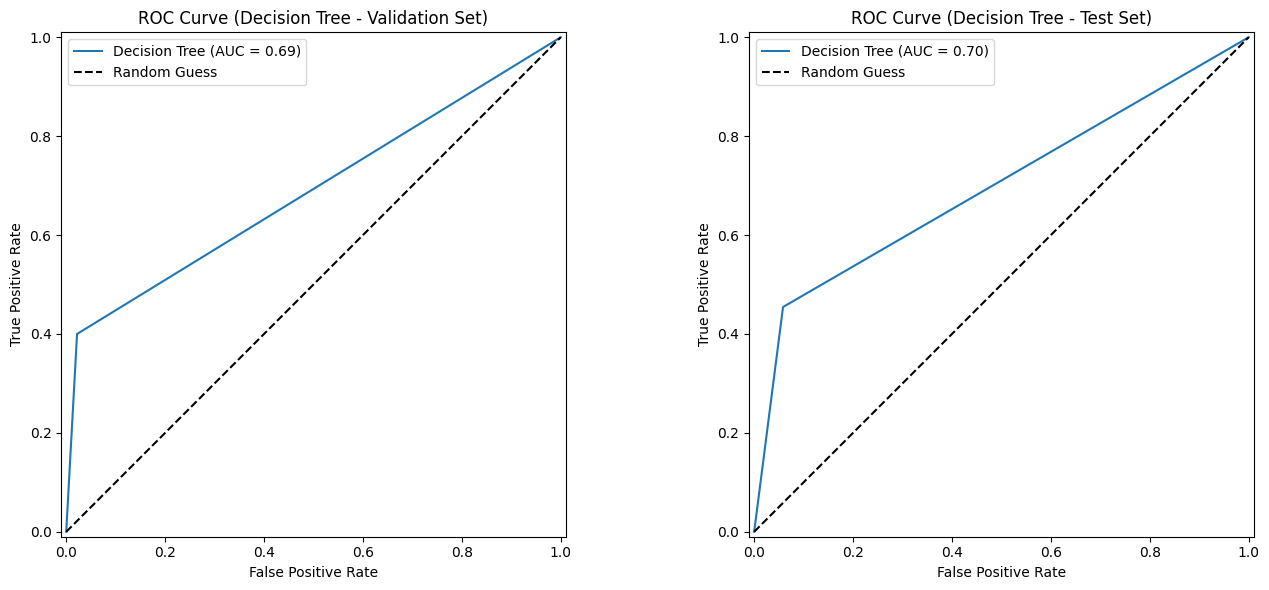

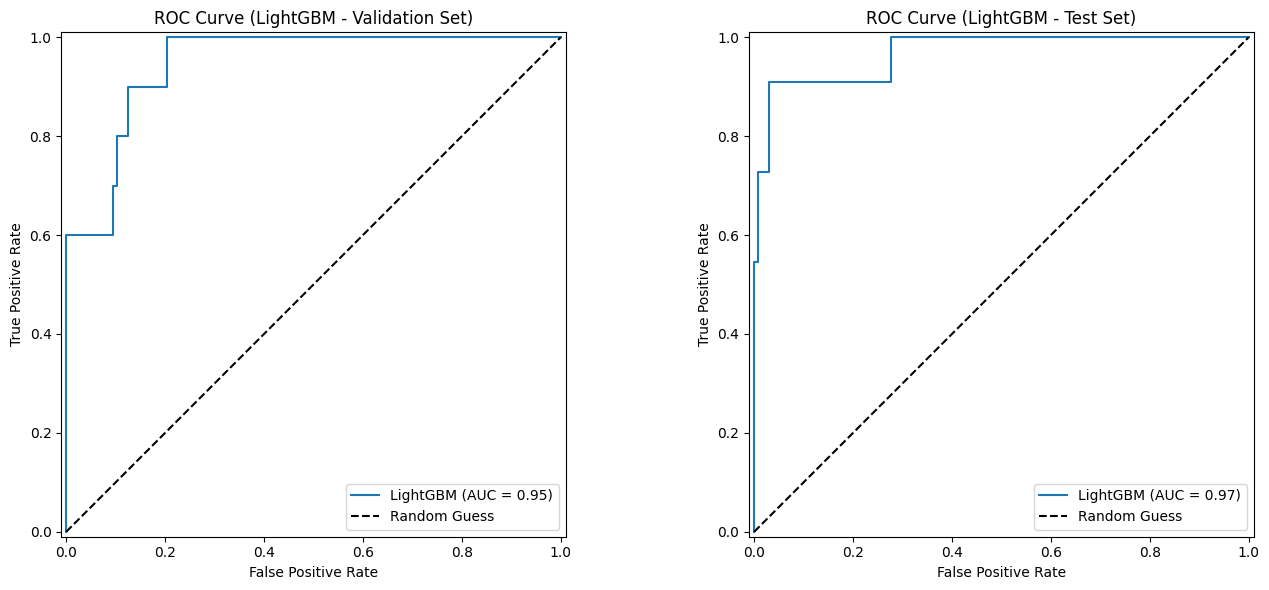

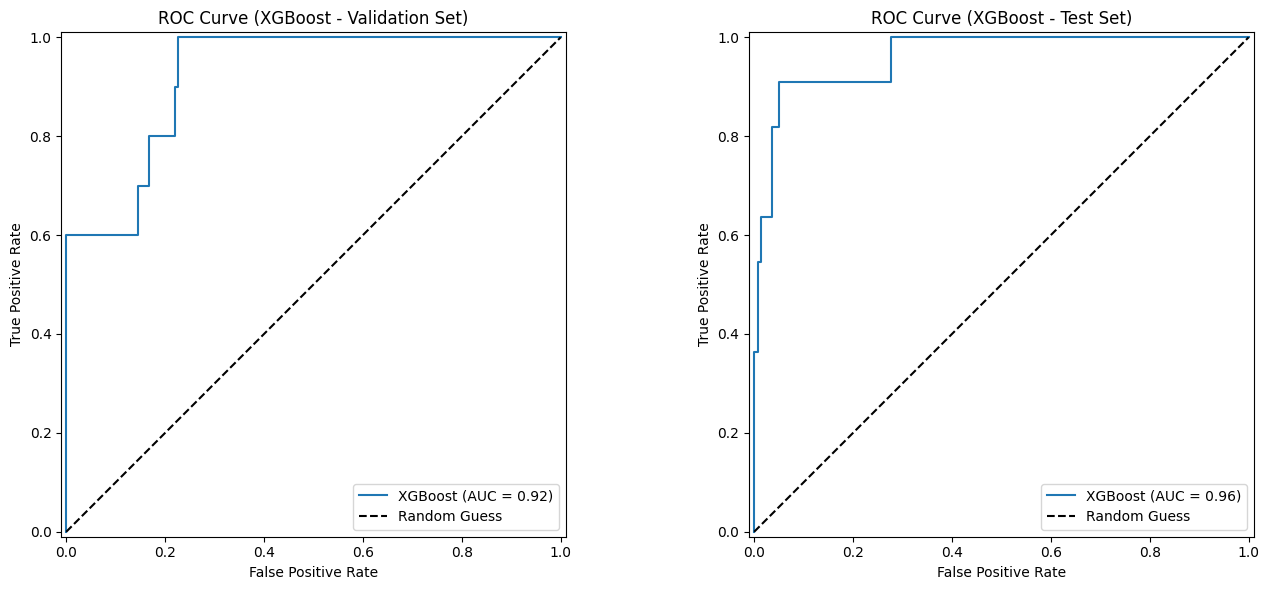

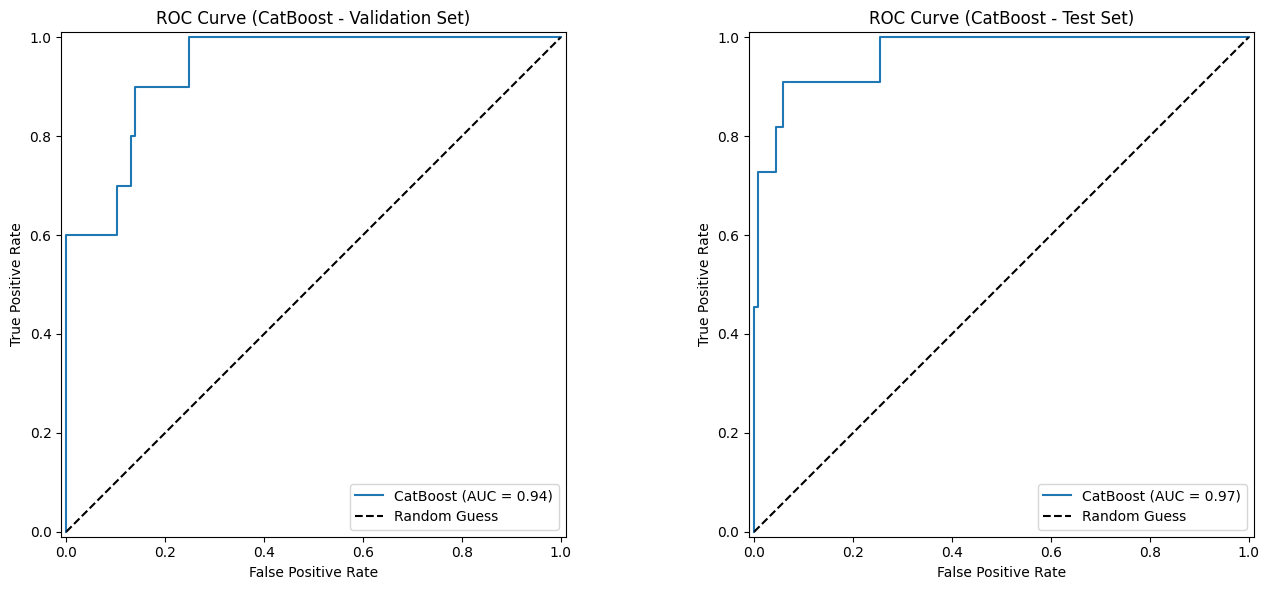

✅ ROC curves generated for all models on validation and test sets.


In [43]:
from sklearn.metrics import RocCurveDisplay

# Visualize ROC curves
for name in models.keys():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot ROC for Validation Set
    if probabilities_val.get(name) is not None:
        RocCurveDisplay.from_predictions(y_val, probabilities_val[name], ax=axes[0], name=name)
        axes[0].set_title(f'ROC Curve ({name} - Validation Set)')
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].plot([0, 1], [0, 1], 'k--', label='Random Guess') # Add diagonal line
        axes[0].legend()


    # Plot ROC for Test Set
    if probabilities_test.get(name) is not None:
        RocCurveDisplay.from_predictions(y_test, probabilities_test[name], ax=axes[1], name=name)
        axes[1].set_title(f'ROC Curve ({name} - Test Set)')
        axes[1].set_xlabel('False Positive Rate')
        axes[1].set_ylabel('True Positive Rate')
        axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess') # Add diagonal line
        axes[1].legend()

    plt.tight_layout()
    plt.show()

print("✅ ROC curves generated for all models on validation and test sets.")

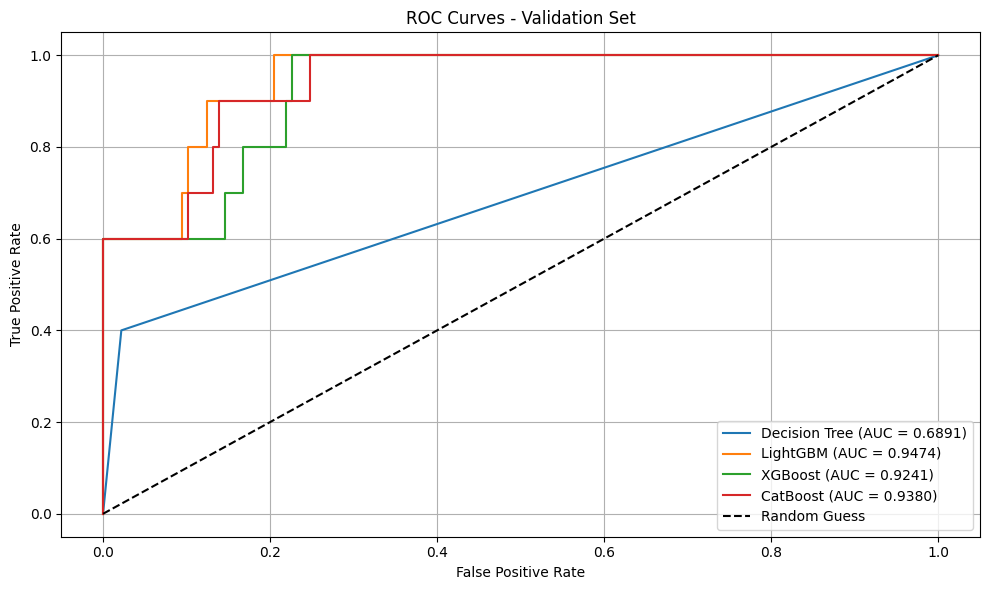

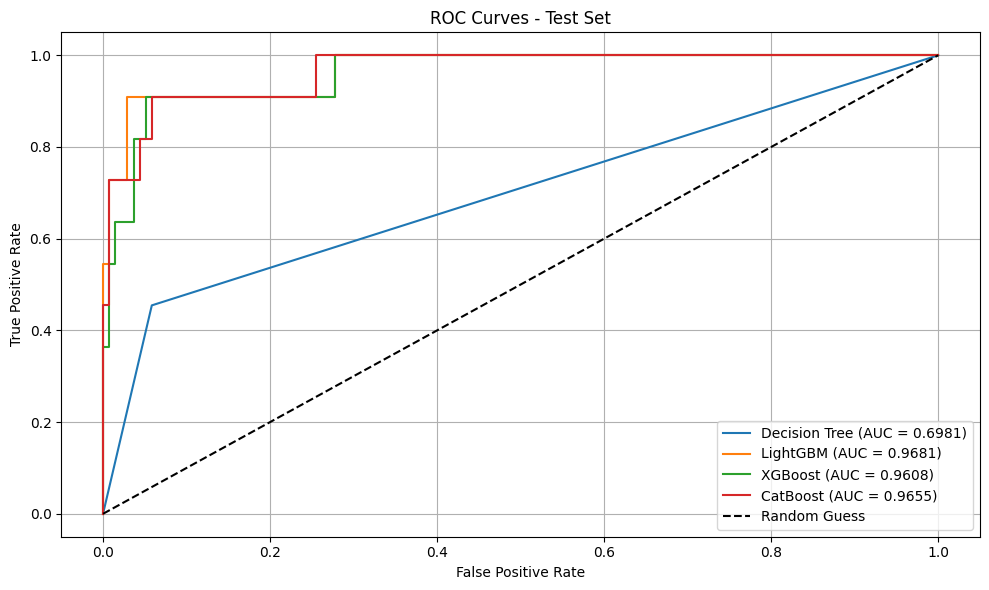

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, y_probs_dict, title):
    plt.figure(figsize=(10, 6))
    for model_name, y_probs in y_probs_dict.items():
        if y_probs is not None:
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title(f'ROC Curves - {title}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_roc_curves(y_val, probabilities_val, 'Validation Set')
plot_roc_curves(y_test, probabilities_test, 'Test Set')


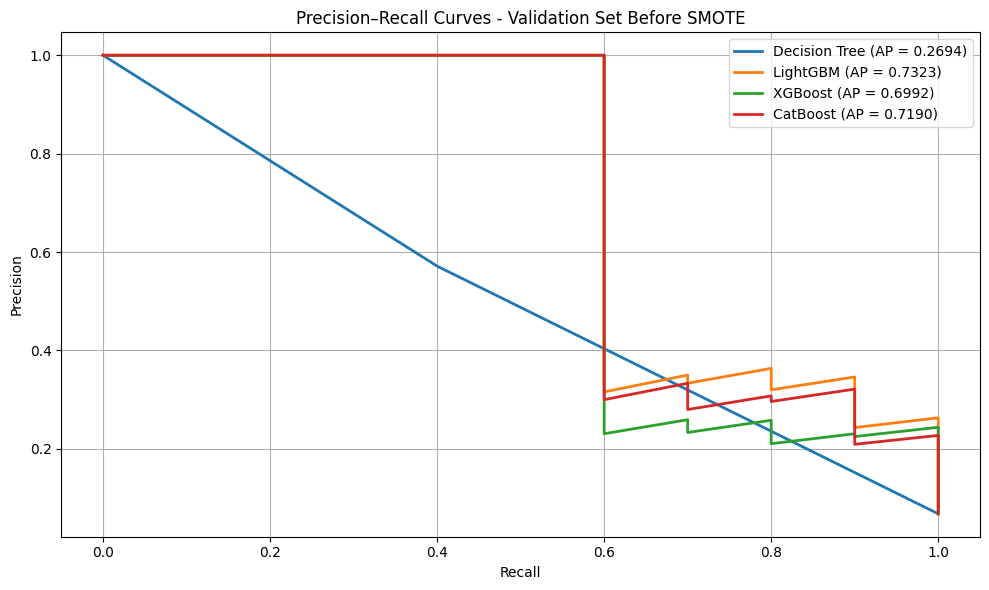

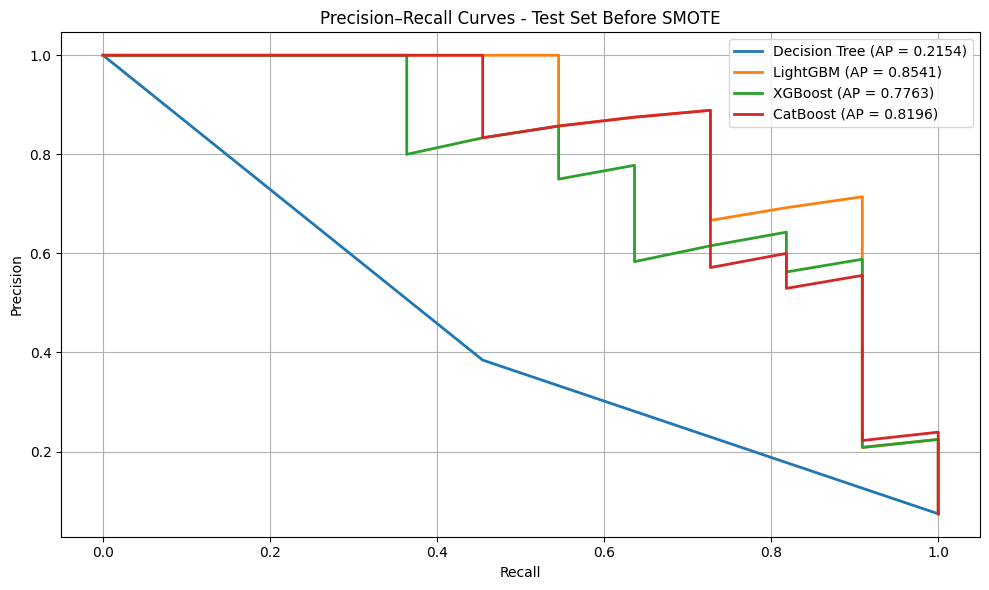

In [45]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(y_true, prob_dict, title):
    plt.figure(figsize=(10, 6))

    for model_name, y_probs in prob_dict.items():
        if y_probs is not None:
            precision, recall, _ = precision_recall_curve(y_true, y_probs)
            avg_precision = average_precision_score(y_true, y_probs)
            plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {avg_precision:.4f})')

    plt.title(f'Precision–Recall Curves - {title}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Use your pre-SMOTE probability outputs
plot_pr_curves(y_val, probabilities_val, 'Validation Set Before SMOTE')
plot_pr_curves(y_test, probabilities_test, 'Test Set Before SMOTE')

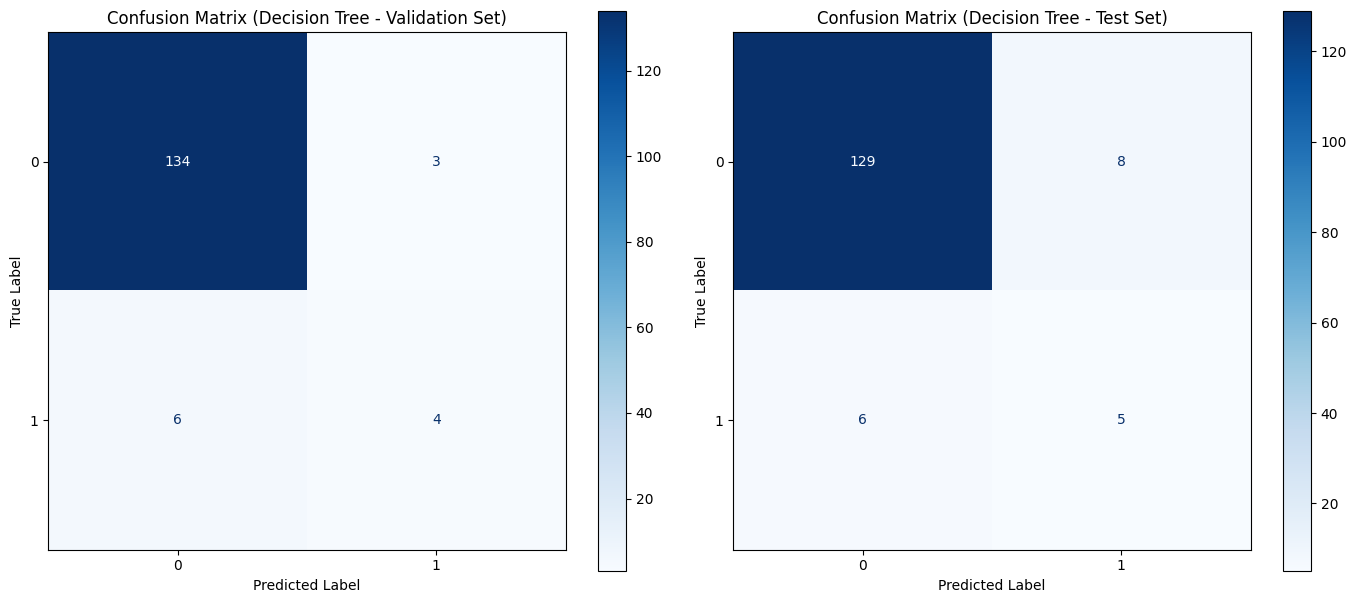

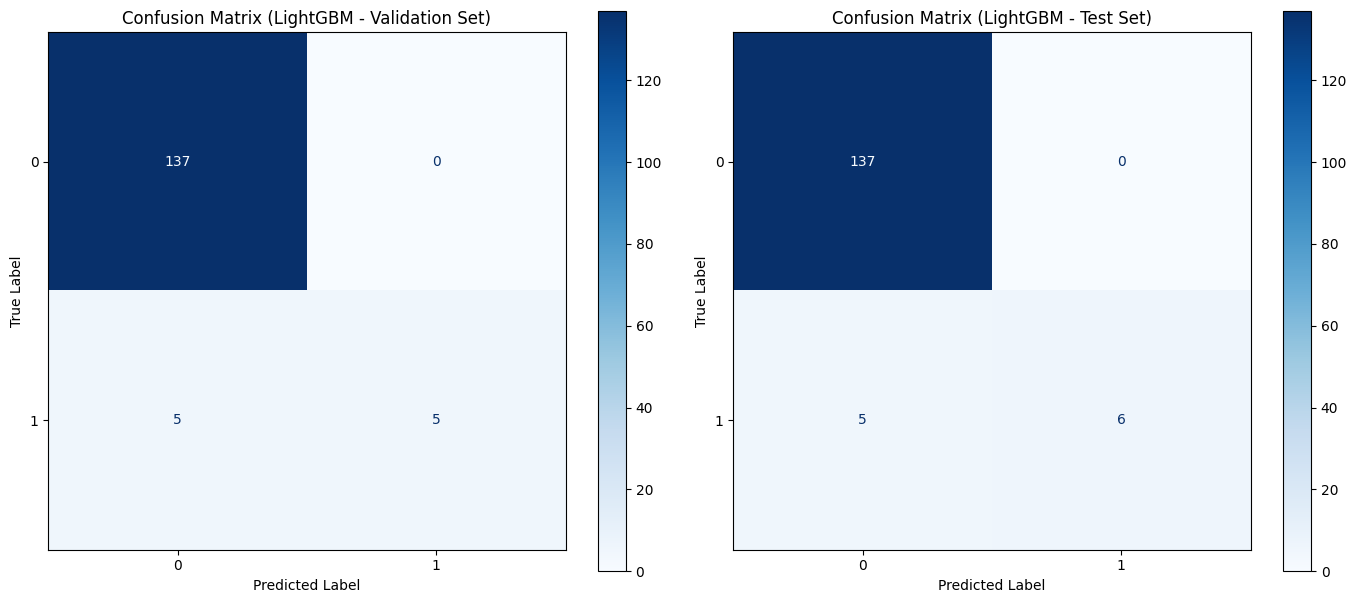

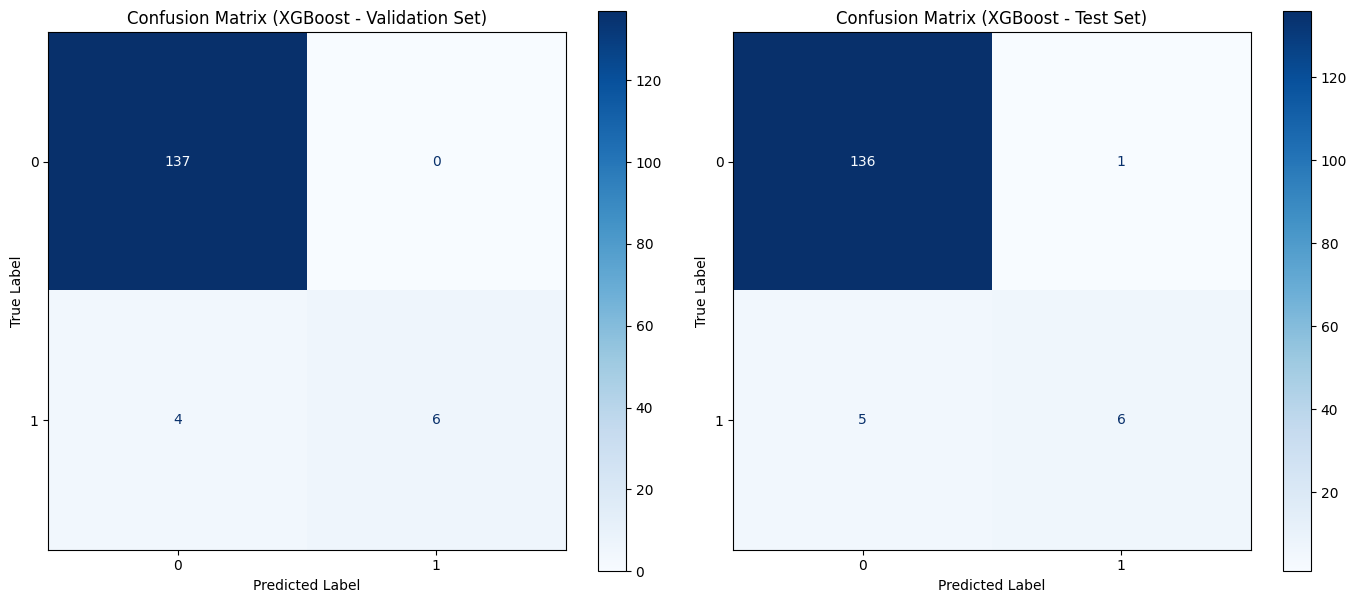

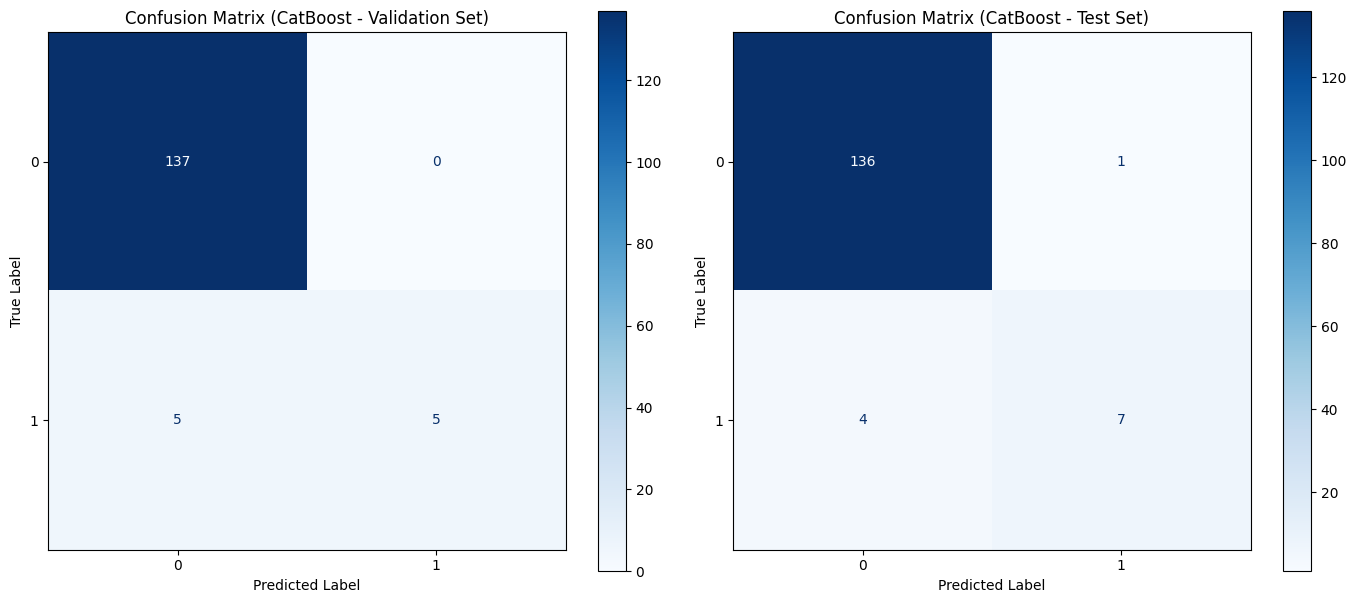

✅ Confusion matrices generated for all models on validation and test sets.


In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Visualize Confusion Matrices
for name in models.keys():
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Confusion Matrix for Validation Set
    cm_val = confusion_matrix(y_val, predictions_val[name])
    disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=[0, 1]) # Assuming 0 for non-anomaly, 1 for anomaly
    disp_val.plot(ax=axes[0], cmap='Blues')
    axes[0].set_title(f'Confusion Matrix ({name} - Validation Set)')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Confusion Matrix for Test Set
    cm_test = confusion_matrix(y_test, predictions_test[name])
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=[0, 1]) # Assuming 0 for non-anomaly, 1 for anomaly
    disp_test.plot(ax=axes[1], cmap='Blues')
    axes[1].set_title(f'Confusion Matrix ({name} - Test Set)')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

print("✅ Confusion matrices generated for all models on validation and test sets.")

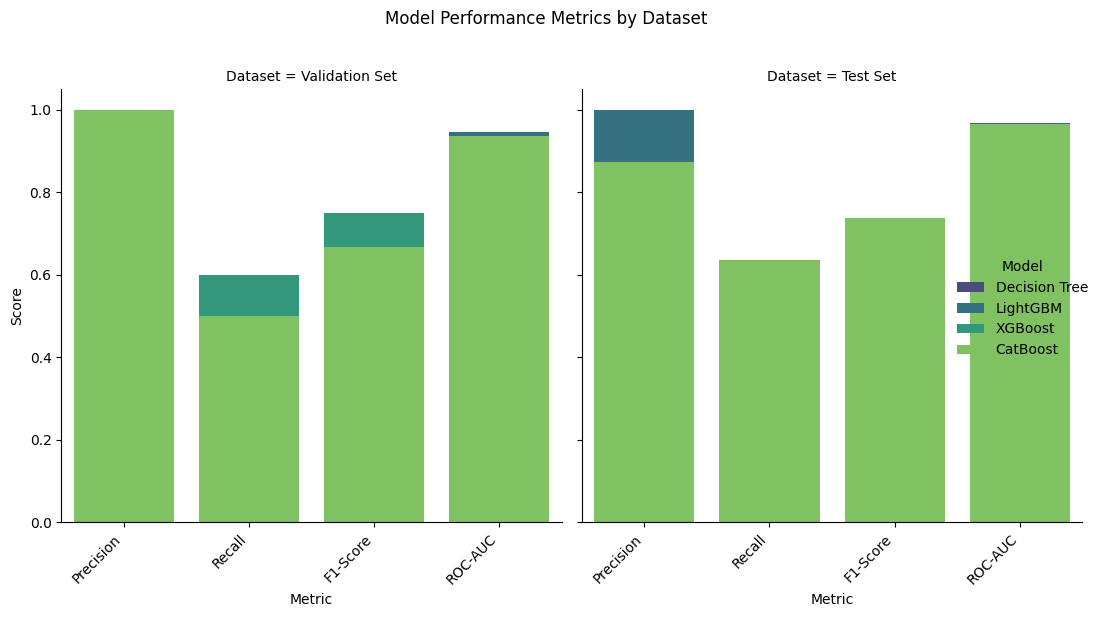

✅ Evaluation metrics visualized.


In [47]:
# Create dataframes from the evaluation results for easier plotting
eval_val_df = pd.DataFrame(evaluation_val).T.reset_index().rename(columns={'index': 'Model'})
eval_test_df = pd.DataFrame(evaluation_test).T.reset_index().rename(columns={'index': 'Model'})

eval_val_df['Dataset'] = 'Validation Set'
eval_test_df['Dataset'] = 'Test Set'

combined_eval_df = pd.concat([eval_val_df, eval_test_df])

# Melt the dataframe for plotting
melted_eval_df = combined_eval_df.melt(id_vars=['Model', 'Dataset'],
                                       value_vars=['Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
                                       var_name='Metric',
                                       value_name='Score')

# Ensure 'Score' is numeric, coercing errors to NaN
melted_eval_df['Score'] = pd.to_numeric(melted_eval_df['Score'], errors='coerce')

# Plotting the evaluation metrics using FacetGrid
g = sns.FacetGrid(melted_eval_df, col='Dataset', hue='Model', palette='viridis', height=6, aspect=0.8, sharey=True)
g.map(sns.barplot, 'Metric', 'Score', order=['Precision', 'Recall', 'F1-Score', 'ROC-AUC']) # Specify order for consistent plotting
g.add_legend(title='Model')
g.fig.suptitle('Model Performance Metrics by Dataset', y=1.02)
g.set_axis_labels("Metric", "Score")
g.set_xticklabels(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

print("✅ Evaluation metrics visualized.")

In [48]:
# Analyze evaluation results to identify the best model

print("--- Analyzing Model Performance ---")

# Define key metrics to consider, prioritizing ROC-AUC and F1-Score for a balanced view
key_metrics = ['ROC-AUC', 'F1-Score']

best_model_val = None
best_metric_val = -1
best_model_test = None
best_metric_test = -1

# Find the best model on the validation set based on ROC-AUC
print("\nPerformance on Validation Set (ranked by ROC-AUC):")
sorted_val_auc = sorted(evaluation_val.items(), key=lambda item: item[1].get('ROC-AUC', -1), reverse=True)
for name, metrics in sorted_val_auc:
    print(f"  {name}: ROC-AUC = {metrics.get('ROC-AUC', 'N/A'):.4f}, F1-Score = {metrics.get('F1-Score', 'N/A'):.4f}")

    # Keep track of the best model based on ROC-AUC for validation
    if isinstance(metrics.get('ROC-AUC'), float) and metrics['ROC-AUC'] > best_metric_val:
        best_metric_val = metrics['ROC-AUC']
        best_model_val = name


# Find the best model on the test set based on ROC-AUC
print("\nPerformance on Test Set (ranked by ROC-AUC):")
sorted_test_auc = sorted(evaluation_test.items(), key=lambda item: item[1].get('ROC-AUC', -1), reverse=True)
for name, metrics in sorted_test_auc:
    print(f"  {name}: ROC-AUC = {metrics.get('ROC-AUC', 'N/A'):.4f}, F1-Score = {metrics.get('F1-Score', 'N/A'):.4f}")

    # Keep track of the best model based on ROC-AUC for test
    if isinstance(metrics.get('ROC-AUC'), float) and metrics['ROC-AUC'] > best_metric_test:
        best_metric_test = metrics['ROC-AUC']
        best_model_test = name

print(f"\nBest performing model on Validation Set (based on ROC-AUC): {best_model_val}")
print(f"Best performing model on Test Set (based on ROC-AUC): {best_model_test}")

print("\n--- Analysis Complete ---")

--- Analyzing Model Performance ---

Performance on Validation Set (ranked by ROC-AUC):
  LightGBM: ROC-AUC = 0.9474, F1-Score = 0.6667
  CatBoost: ROC-AUC = 0.9380, F1-Score = 0.6667
  XGBoost: ROC-AUC = 0.9241, F1-Score = 0.7500
  Decision Tree: ROC-AUC = 0.6891, F1-Score = 0.4706

Performance on Test Set (ranked by ROC-AUC):
  LightGBM: ROC-AUC = 0.9681, F1-Score = 0.7059
  CatBoost: ROC-AUC = 0.9655, F1-Score = 0.7368
  XGBoost: ROC-AUC = 0.9608, F1-Score = 0.6667
  Decision Tree: ROC-AUC = 0.6981, F1-Score = 0.4167

Best performing model on Validation Set (based on ROC-AUC): LightGBM
Best performing model on Test Set (based on ROC-AUC): LightGBM

--- Analysis Complete ---


In [49]:
# Select the best performing model (LightGBM based on previous analysis)
best_model_name = 'LightGBM'

# Retrieve predictions and probabilities for the best model on the test set
best_model_predictions_test = predictions_test[best_model_name]
best_model_probabilities_test = probabilities_test[best_model_name]

# Calculate key metrics for the best model on the test set
precision_test = precision_score(y_test, best_model_predictions_test, zero_division=0)
recall_test = recall_score(y_test, best_model_predictions_test, zero_division=0)
f1_test = f1_score(y_test, best_model_predictions_test, zero_division=0)
auc_test = roc_auc_score(y_test, best_model_probabilities_test)

# Print the evaluation results
print(f"Evaluation of the best model ({best_model_name}) on the Test Set:")
print(f"  Precision: {precision_test:.4f}")
print(f"  Recall: {recall_test:.4f}")
print(f"  F1-Score: {f1_test:.4f}")
print(f"  ROC-AUC: {auc_test:.4f}")

Evaluation of the best model (LightGBM) on the Test Set:
  Precision: 1.0000
  Recall: 0.5455
  F1-Score: 0.7059
  ROC-AUC: 0.9681


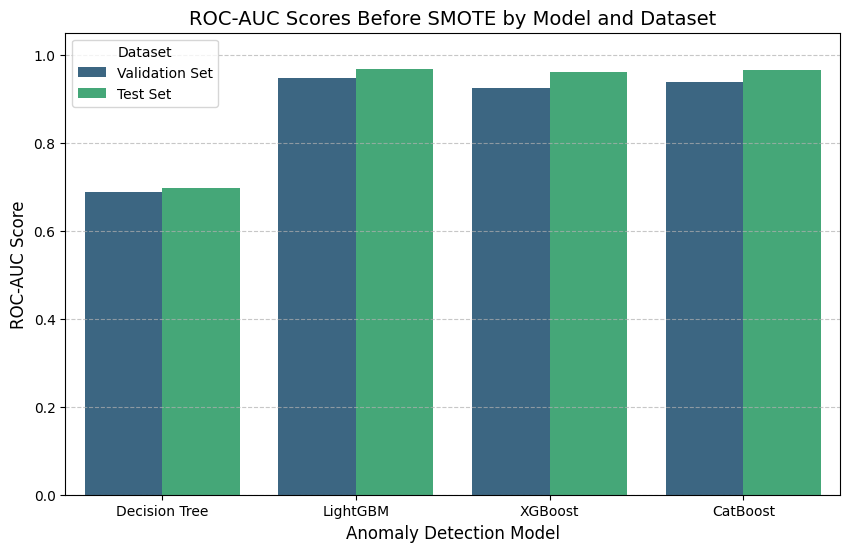

✅ ROC-AUC scores before SMOTE visualized.


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract AUC scores before SMOTE
auc_data = []

for name, metrics in evaluation_val.items():
    auc_data.append({'Model': name, 'Dataset': 'Validation Set', 'Metric': 'ROC-AUC', 'Score': metrics.get('ROC-AUC')})

for name, metrics in evaluation_test.items():
    auc_data.append({'Model': name, 'Dataset': 'Test Set', 'Metric': 'ROC-AUC', 'Score': metrics.get('ROC-AUC')})

auc_df = pd.DataFrame(auc_data)

# Ensure 'Score' is numeric, coercing errors to NaN
auc_df['Score'] = pd.to_numeric(auc_df['Score'], errors='coerce')

# Plotting the AUC scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Dataset', data=auc_df, palette='viridis')
plt.title('ROC-AUC Scores Before SMOTE by Model and Dataset', fontsize=14)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.xlabel('Anomaly Detection Model', fontsize=12)
plt.legend(title='Dataset')
plt.ylim(0, 1.05) # AUC scores are between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("✅ ROC-AUC scores before SMOTE visualized.")

In [51]:
# Check for class imbalance in the combined dataset
print("Class distribution in the combined dataset:")
display(combined_data['is_anomaly'].value_counts())
display(combined_data['is_anomaly'].value_counts(normalize=True) * 100)

# Check for class imbalance in the training set
print("\nClass distribution in the training set:")
display(y_train.value_counts())
display(y_train.value_counts(normalize=True) * 100)

# Check for class imbalance in the validation set
print("\nClass distribution in the validation set:")
display(y_val.value_counts())
display(y_val.value_counts(normalize=True) * 100)

# Check for class imbalance in the test set
print("\nClass distribution in the test set:")
display(y_test.value_counts())
display(y_test.value_counts(normalize=True) * 100)

print("\n✅ Class distribution checked.")

Class distribution in the combined dataset:


,count
is_anomaly,
0,910
1,71


,proportion
is_anomaly,
0,92.762487
1,7.237513



Class distribution in the training set:


,count
is_anomaly,
0,636
1,50


,proportion
is_anomaly,
0,92.71137
1,7.28863



Class distribution in the validation set:


,count
is_anomaly,
0,137
1,10


,proportion
is_anomaly,
0,93.197279
1,6.802721



Class distribution in the test set:


,count
is_anomaly,
0,137
1,11


,proportion
is_anomaly,
0,92.567568
1,7.432432



✅ Class distribution checked.


In [52]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=RANDOM_STATE)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after applying SMOTE
print("Class distribution in the training set after SMOTE:")
display(y_train_smote.value_counts())
display(y_train_smote.value_counts(normalize=True) * 100)

print("\nShape of training features after SMOTE (X_train_smote):", X_train_smote.shape)
print("Shape of training target after SMOTE (y_train_smote):", y_train_smote.shape)

print("\n✅ SMOTE applied to training data.")

Class distribution in the training set after SMOTE:


,count
is_anomaly,
0,636
1,636


,proportion
is_anomaly,
0,50.0
1,50.0



Shape of training features after SMOTE (X_train_smote): (1272, 27)
Shape of training target after SMOTE (y_train_smote): (1272,)

✅ SMOTE applied to training data.


In [53]:
# Retrain each model on the SMOTE-augmented training data
models_smote = {} # Dictionary to store retrained models

for name, model in models.items():
    print(f"Retraining {name} with SMOTE data...")
    # Create a new instance of the model to avoid interference
    if name == 'Decision Tree':
        retrained_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
    elif name == 'LightGBM':
        retrained_model = LGBMClassifier(random_state=RANDOM_STATE)
    elif name == 'XGBoost':
        retrained_model = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False)
    elif name == 'CatBoost':
        retrained_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0) # verbose=0 to suppress output
    else:
        retrained_model = model # Use original if not a known type

    retrained_model.fit(X_train_smote, y_train_smote)
    models_smote[name] = retrained_model
    print(f"✅ {name} retrained successfully with SMOTE data.")

print("\n✅ All models retrained with SMOTE-augmented data.")

Retraining Decision Tree with SMOTE data...
✅ Decision Tree retrained successfully with SMOTE data.
Retraining LightGBM with SMOTE data...
[LightGBM] [Info] Number of positive: 636, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5212
[LightGBM] [Info] Number of data points in the train set: 1272, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✅ LightGBM retrained successfully with SMOTE data.
Retraining XGBoost with SMOTE data...
✅ XGBoost retrained successfully with SMOTE data.
Retraining CatBoost with SMOTE data...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:41:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ CatBoost retrained successfully with SMOTE data.

✅ All models retrained with SMOTE-augmented data.


In [54]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Initialize dictionaries to store evaluation metrics for SMOTE models
evaluation_val_smote = {}
evaluation_test_smote = {}

# Make predictions and get probabilities for each retrained model
predictions_val_smote = {}
probabilities_val_smote = {}
predictions_test_smote = {}
probabilities_test_smote = {}

for name, model in models_smote.items():
    print(f"Evaluating {name} (SMOTE)...")

    # Predictions
    y_pred_val_smote = model.predict(X_val)
    y_pred_test_smote = model.predict(X_test)

    predictions_val_smote[name] = y_pred_val_smote
    predictions_test_smote[name] = y_pred_test_smote


    # Probabilities (for models that support it)
    if hasattr(model, 'predict_proba'):
        y_prob_val_smote = model.predict_proba(X_val)[:, 1] # Probability of the positive class (1)
        y_prob_test_smote = model.predict_proba(X_test)[:, 1] # Probability of the positive class (1)

        probabilities_val_smote[name] = y_prob_val_smote
        probabilities_test_smote[name] = y_prob_test_smote


    # Calculate metrics for Validation Set
    precision_val_smote = precision_score(y_val, y_pred_val_smote, zero_division=0)
    recall_val_smote = recall_score(y_val, y_pred_val_smote, zero_division=0)
    f1_val_smote = f1_score(y_val, y_pred_val_smote, zero_division=0)
    auc_val_smote = roc_auc_score(y_val, y_prob_val_smote) if y_prob_val_smote is not None else 'N/A'

    evaluation_val_smote[name] = {
        'Precision': precision_val_smote,
        'Recall': recall_val_smote,
        'F1-Score': f1_val_smote,
        'ROC-AUC': auc_val_smote
    }
    print(f"  ✅ Metrics calculated for Validation Set.")


    # Calculate metrics for Test Set
    precision_test_smote = precision_score(y_test, y_pred_test_smote, zero_division=0)
    recall_test_smote = recall_score(y_test, y_pred_test_smote, zero_division=0)
    f1_test_smote = f1_score(y_test, y_pred_test_smote, zero_division=0)
    auc_test_smote = roc_auc_score(y_test, y_prob_test_smote) if y_prob_test_smote is not None else 'N/A'

    evaluation_test_smote[name] = {
        'Precision': precision_test_smote,
        'Recall': recall_test_smote,
        'F1-Score': f1_test_smote,
        'ROC-AUC': auc_test_smote
    }
    print(f"  ✅ Metrics calculated for Test Set.")

print("\n✅ Evaluation complete for all SMOTE-retrained models.")

Evaluating Decision Tree (SMOTE)...
  ✅ Metrics calculated for Validation Set.
  ✅ Metrics calculated for Test Set.
Evaluating LightGBM (SMOTE)...
  ✅ Metrics calculated for Validation Set.
  ✅ Metrics calculated for Test Set.
Evaluating XGBoost (SMOTE)...
  ✅ Metrics calculated for Validation Set.
  ✅ Metrics calculated for Test Set.
Evaluating CatBoost (SMOTE)...
  ✅ Metrics calculated for Validation Set.
  ✅ Metrics calculated for Test Set.

✅ Evaluation complete for all SMOTE-retrained models.


In [55]:
# Print evaluation results for SMOTE models
print("\n--- Model Evaluation Results (After SMOTE) ---")

print("\nValidation Set:")
for name, metrics in evaluation_val_smote.items():
    print(f"\n{name} (SMOTE):")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

print("\nTest Set:")
for name, metrics in evaluation_test_smote.items():
    print(f"\n{name} (SMOTE):")
    for metric, value in metrics.items():
        print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

print("\n--- Evaluation Summary Complete (After SMOTE) ---")


--- Model Evaluation Results (After SMOTE) ---

Validation Set:

Decision Tree (SMOTE):
  Precision: 0.5000
  Recall: 0.5000
  F1-Score: 0.5000
  ROC-AUC: 0.7318

LightGBM (SMOTE):
  Precision: 1.0000
  Recall: 0.5000
  F1-Score: 0.6667
  ROC-AUC: 0.9569

XGBoost (SMOTE):
  Precision: 0.8333
  Recall: 0.5000
  F1-Score: 0.6250
  ROC-AUC: 0.9496

CatBoost (SMOTE):
  Precision: 0.8333
  Recall: 0.5000
  F1-Score: 0.6250
  ROC-AUC: 0.9372

Test Set:

Decision Tree (SMOTE):
  Precision: 0.5455
  Recall: 0.5455
  F1-Score: 0.5455
  ROC-AUC: 0.7545

LightGBM (SMOTE):
  Precision: 0.8000
  Recall: 0.7273
  F1-Score: 0.7619
  ROC-AUC: 0.9735

XGBoost (SMOTE):
  Precision: 0.7000
  Recall: 0.6364
  F1-Score: 0.6667
  ROC-AUC: 0.9608

CatBoost (SMOTE):
  Precision: 0.7273
  Recall: 0.7273
  F1-Score: 0.7273
  ROC-AUC: 0.9416

--- Evaluation Summary Complete (After SMOTE) ---


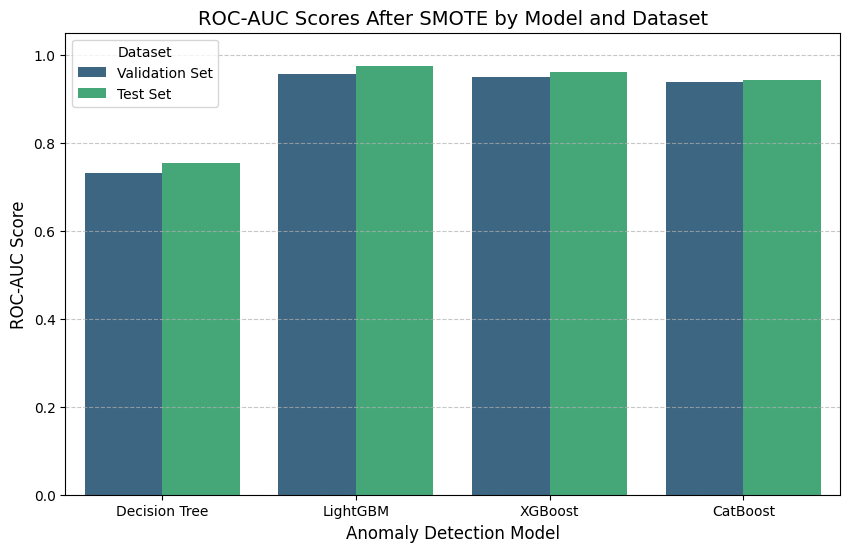

✅ ROC-AUC scores after SMOTE visualized.


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract AUC scores after SMOTE
auc_data_smote = []

for name, metrics in evaluation_val_smote.items():
    auc_data_smote.append({'Model': name, 'Dataset': 'Validation Set', 'Metric': 'ROC-AUC', 'Score': metrics.get('ROC-AUC')})

for name, metrics in evaluation_test_smote.items():
    auc_data_smote.append({'Model': name, 'Dataset': 'Test Set', 'Metric': 'ROC-AUC', 'Score': metrics.get('ROC-AUC')})

auc_smote_df = pd.DataFrame(auc_data_smote)

# Ensure 'Score' is numeric, coercing errors to NaN
auc_smote_df['Score'] = pd.to_numeric(auc_smote_df['Score'], errors='coerce')

# Plotting the AUC scores after SMOTE
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Score', hue='Dataset', data=auc_smote_df, palette='viridis')
plt.title('ROC-AUC Scores After SMOTE by Model and Dataset', fontsize=14)
plt.ylabel('ROC-AUC Score', fontsize=12)
plt.xlabel('Anomaly Detection Model', fontsize=12)
plt.legend(title='Dataset')
plt.ylim(0, 1.05) # AUC scores are between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("✅ ROC-AUC scores after SMOTE visualized.")

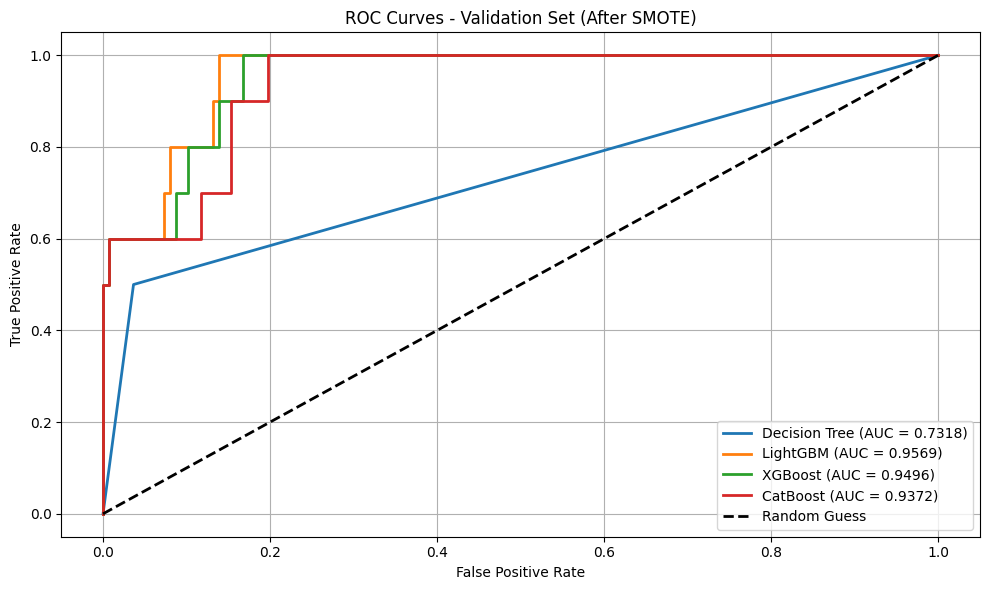

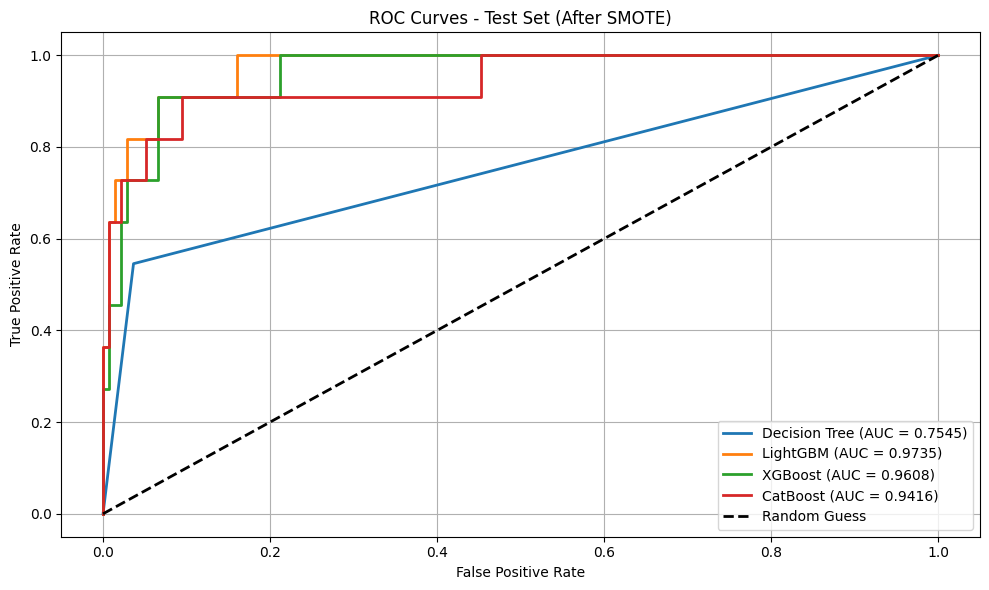

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curves(y_true, prob_dict, title):
    plt.figure(figsize=(10, 6))

    for model_name, y_probs in prob_dict.items():
        if y_probs is not None:
            fpr, tpr, _ = roc_curve(y_true, y_probs)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
    plt.title(f'ROC Curves - {title}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Now call the function using your SMOTE-evaluated data
plot_roc_curves(y_val, probabilities_val_smote, 'Validation Set (After SMOTE)')
plot_roc_curves(y_test, probabilities_test_smote, 'Test Set (After SMOTE)')



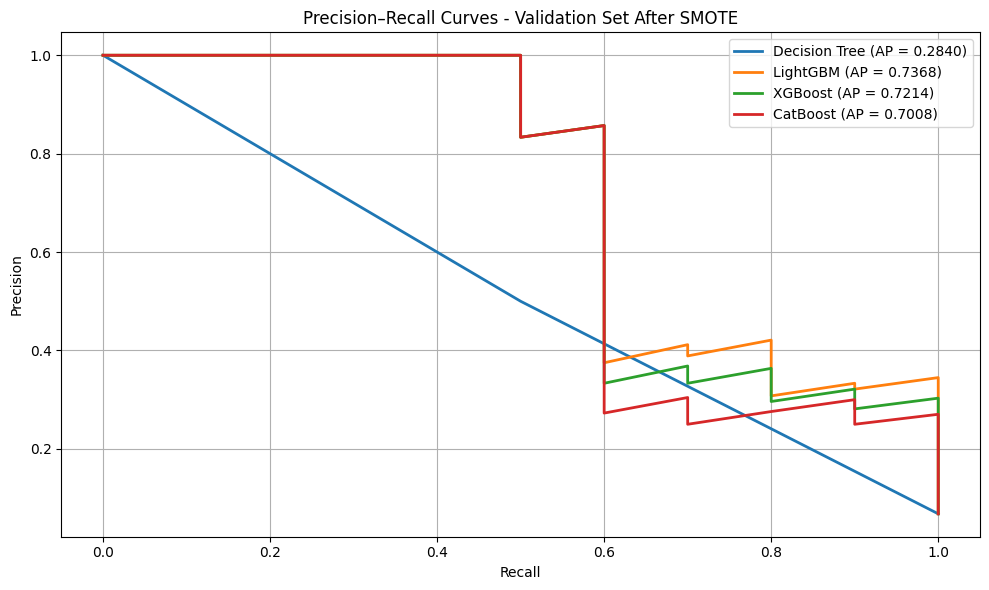

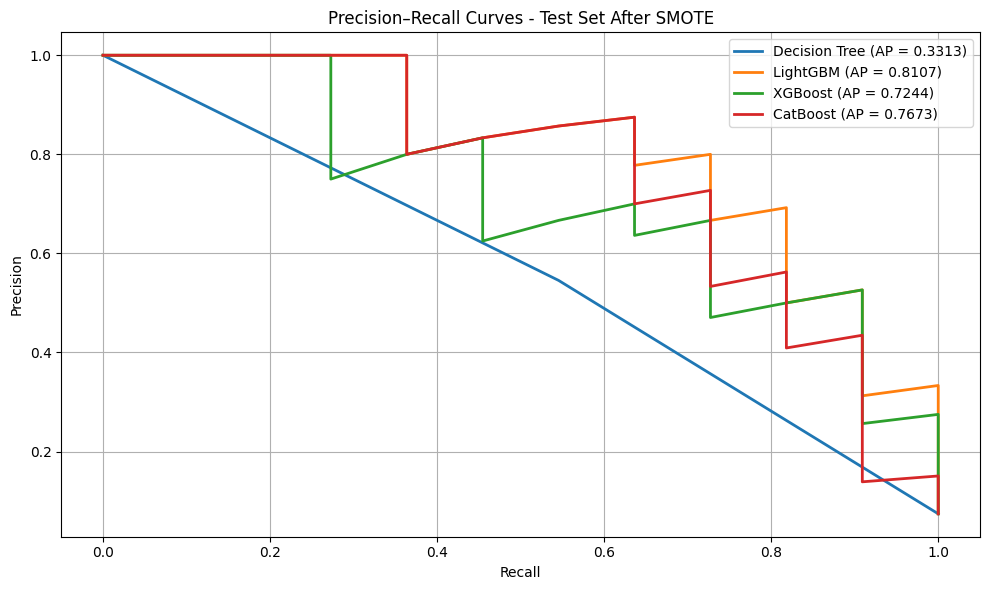

In [58]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curves(y_true, prob_dict, title):
    plt.figure(figsize=(10, 6))

    for model_name, y_probs in prob_dict.items():
        if y_probs is not None:
            precision, recall, _ = precision_recall_curve(y_true, y_probs)
            avg_precision = average_precision_score(y_true, y_probs)
            plt.plot(recall, precision, lw=2, label=f'{model_name} (AP = {avg_precision:.4f})')

    plt.title(f'Precision–Recall Curves - {title}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot for validation set after SMOTE
plot_pr_curves(y_val, probabilities_val_smote, 'Validation Set After SMOTE')

# Plot for test set after SMOTE
plot_pr_curves(y_test, probabilities_test_smote, 'Test Set After SMOTE')


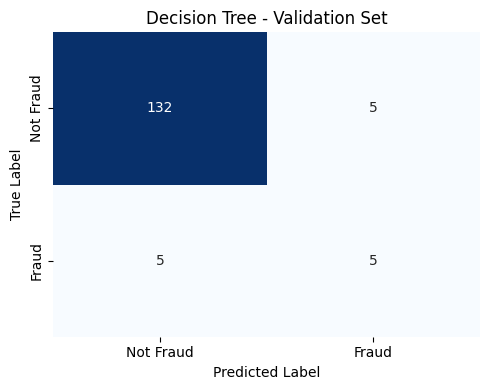

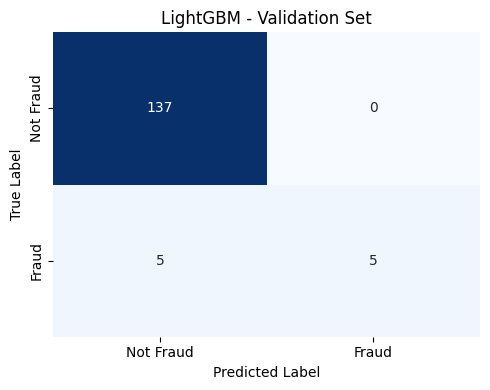

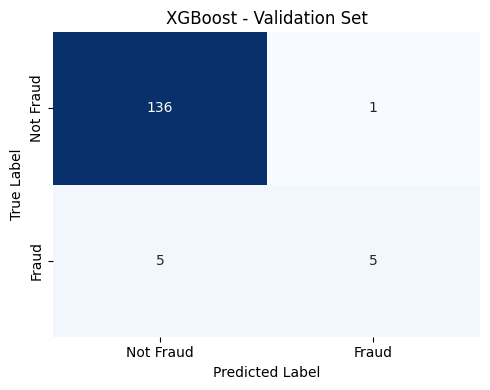

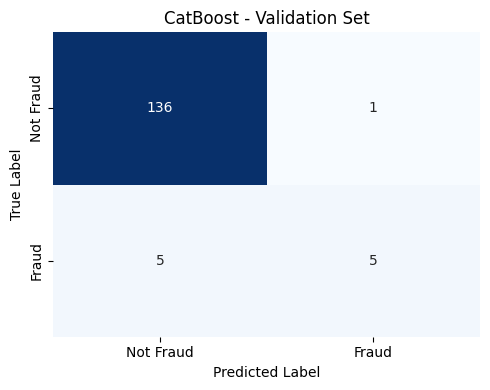

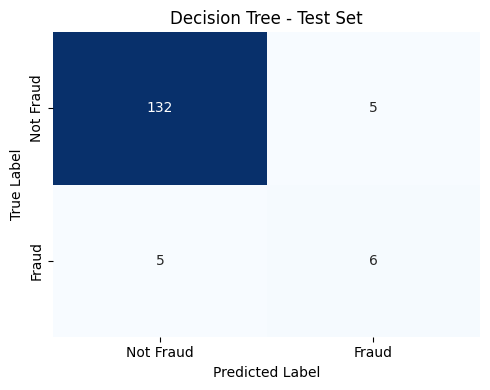

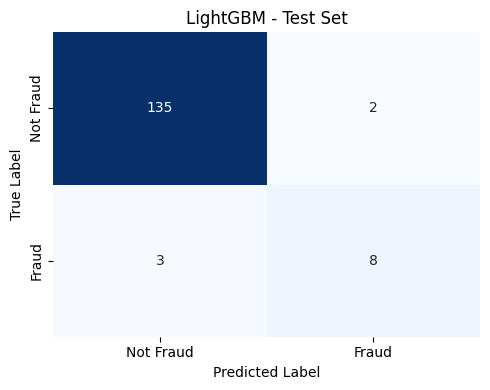

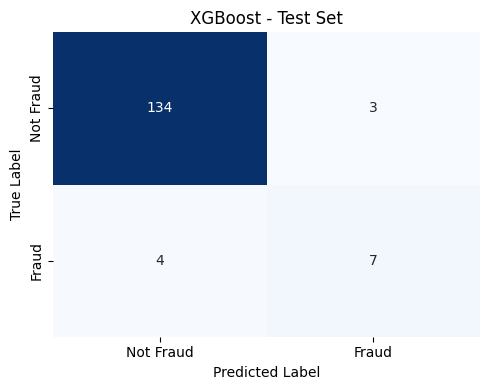

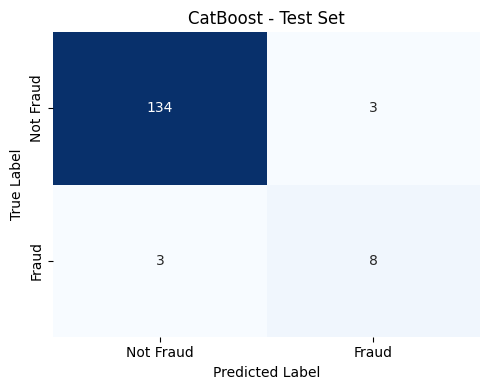

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_conf_matrix(y_true, y_pred, model_name, dataset_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.title(f'{model_name} - {dataset_name} Set')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for validation set
for model in predictions_val_smote:
    y_pred_val = predictions_val_smote[model]
    plot_conf_matrix(y_val, y_pred_val, model, 'Validation')

# Plot confusion matrices for test set
for model in predictions_test_smote:
    y_pred_test = predictions_test_smote[model]
    plot_conf_matrix(y_test, y_pred_test, model, 'Test')


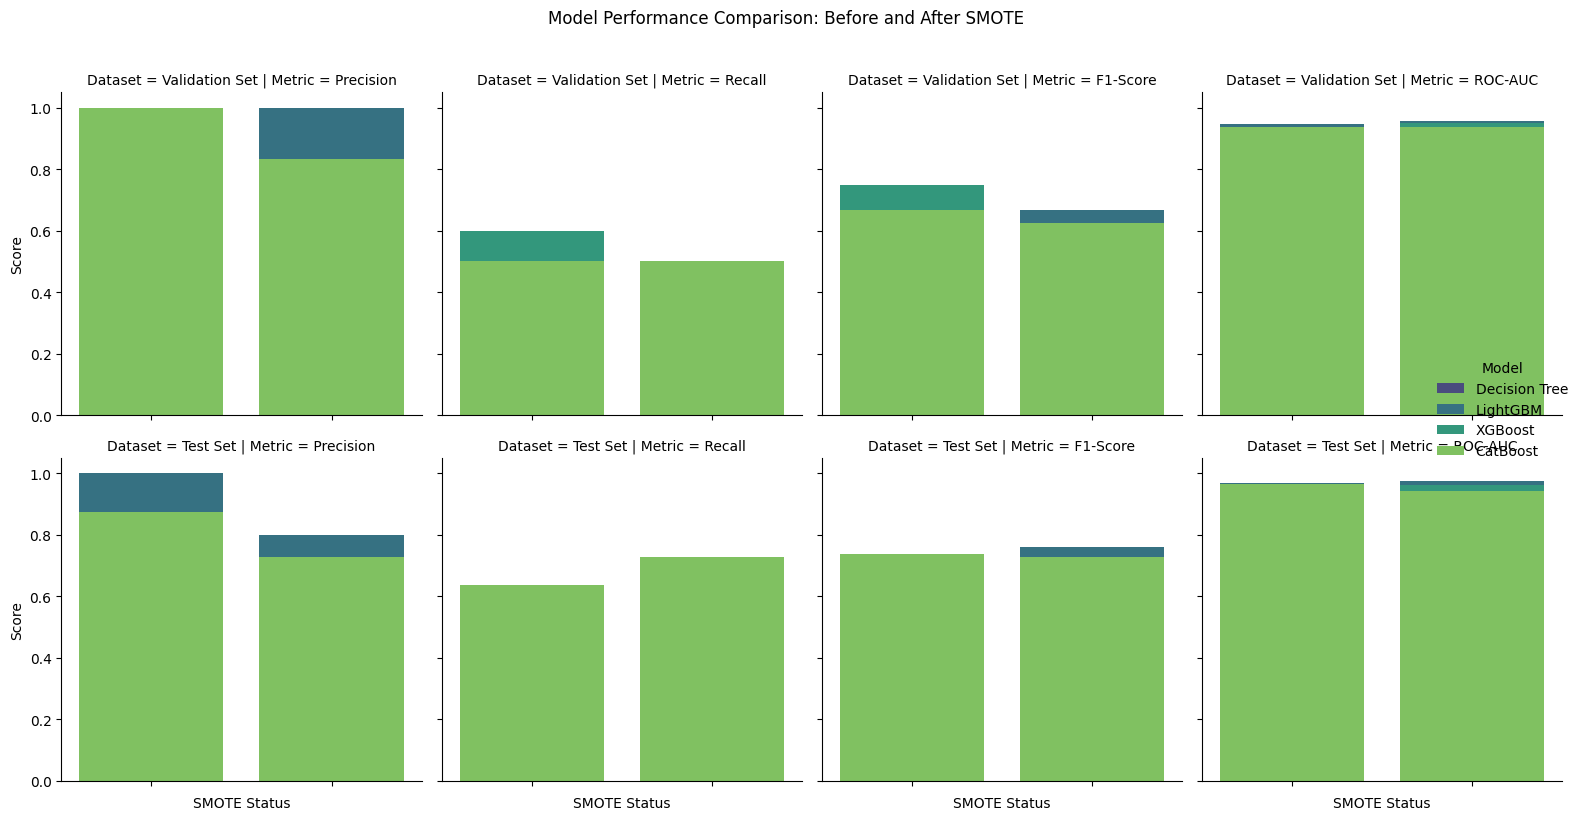

✅ Evaluation metrics comparison visualized.


In [60]:
# Combine evaluation results before and after SMOTE for easier comparison
eval_val_df['SMOTE'] = 'Before SMOTE'
eval_test_df['SMOTE'] = 'Before SMOTE'

eval_val_smote_df = pd.DataFrame(evaluation_val_smote).T.reset_index().rename(columns={'index': 'Model'})
eval_test_smote_df = pd.DataFrame(evaluation_test_smote).T.reset_index().rename(columns={'index': 'Model'})

eval_val_smote_df['Dataset'] = 'Validation Set'
eval_test_smote_df['Dataset'] = 'Test Set'
eval_val_smote_df['SMOTE'] = 'After SMOTE'
eval_test_smote_df['SMOTE'] = 'After SMOTE'

combined_eval_comparison_df = pd.concat([eval_val_df, eval_test_df, eval_val_smote_df, eval_test_smote_df])

# Melt the dataframe for plotting
melted_eval_comparison_df = combined_eval_comparison_df.melt(id_vars=['Model', 'Dataset', 'SMOTE'],
                                                             value_vars=['Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
                                                             var_name='Metric',
                                                             value_name='Score')

# Ensure 'Score' is numeric, coercing errors to NaN
melted_eval_comparison_df['Score'] = pd.to_numeric(melted_eval_comparison_df['Score'], errors='coerce')

# Plotting the evaluation metrics comparison using FacetGrid
g = sns.FacetGrid(melted_eval_comparison_df, row='Dataset', col='Metric', hue='Model', palette='viridis', height=4, aspect=0.9, sharey='row')
g.map(sns.barplot, 'SMOTE', 'Score', order=['Before SMOTE', 'After SMOTE'])
g.add_legend(title='Model')
g.fig.suptitle('Model Performance Comparison: Before and After SMOTE', y=1.02)
g.set_axis_labels("SMOTE Status", "Score")
g.set_xticklabels(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("✅ Evaluation metrics comparison visualized.")

In [61]:
# Define the hyperparameter search space for LightGBM
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63],
    'max_depth': [-1, 10, 20], # -1 means no limit
    'min_child_samples': [20, 30],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
}

print("✅ Hyperparameter search space for LightGBM defined.")
print(param_grid)

✅ Hyperparameter search space for LightGBM defined.
{'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'num_leaves': [31, 63], 'max_depth': [-1, 10, 20], 'min_child_samples': [20, 30], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0], 'reg_alpha': [0, 0.1, 0.5], 'reg_lambda': [0, 0.1, 0.5]}


In [62]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
import time

# Initialize the LightGBM model
lgbm = LGBMClassifier(random_state=RANDOM_STATE)

# Initialize RandomizedSearchCV
# We'll search over 50 different combinations (n_iter)
# using 5-fold cross-validation (cv=5)
# scoring with roc_auc
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=50,  # Number of parameter settings that are sampled
    cv=5,       # Number of folds for cross-validation
    scoring='roc_auc', # Metric to evaluate
    random_state=RANDOM_STATE,
    n_jobs=-1,  # Use all available cores
    verbose=1   # Display progress
)

print("Starting Randomized Search for LightGBM hyperparameters...")
start_time = time.time()

# Perform the search on the SMOTE-augmented training data
random_search.fit(X_train_smote, y_train_smote)

end_time = time.time()
print(f"\nRandomized Search completed in {end_time - start_time:.2f} seconds.")

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("\nBest hyperparameters found:")
print(best_params)
print(f"\nBest ROC-AUC score on the training set with cross-validation: {best_score:.4f}")

# Store the best model
best_lgbm_model = random_search.best_estimator_

print("\n✅ Randomized Search for LightGBM hyperparameters complete.")

Starting Randomized Search for LightGBM hyperparameters...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Info] Number of positive: 636, number of negative: 636
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5212
[LightGBM] [Info] Number of data points in the train set: 1272, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Evaluate the best-tuned LightGBM model on the original validation set
y_pred_val_tuned = best_lgbm_model.predict(X_val)
y_prob_val_tuned = best_lgbm_model.predict_proba(X_val)[:, 1]

precision_val_tuned = precision_score(y_val, y_pred_val_tuned, zero_division=0)
recall_val_tuned = recall_score(y_val, y_pred_val_tuned, zero_division=0)
f1_val_tuned = f1_score(y_val, y_pred_val_tuned, zero_division=0)
auc_val_tuned = roc_auc_score(y_val, y_prob_val_tuned)

print("Evaluation of Tuned LightGBM Model on Validation Set:")
print(f"  Precision: {precision_val_tuned:.4f}")
print(f"  Recall: {recall_val_tuned:.4f}")
print(f"  F1-Score: {f1_val_tuned:.4f}")
print(f"  ROC-AUC: {auc_val_tuned:.4f}")

# Evaluate the best-tuned LightGBM model on the original test set
y_pred_test_tuned = best_lgbm_model.predict(X_test)
y_prob_test_tuned = best_lgbm_model.predict_proba(X_test)[:, 1]

precision_test_tuned = precision_score(y_test, y_pred_test_tuned, zero_division=0)
recall_test_tuned = recall_score(y_test, y_pred_test_tuned, zero_division=0)
f1_test_tuned = f1_score(y_test, y_pred_test_tuned, zero_division=0)
auc_test_tuned = roc_auc_score(y_test, y_prob_test_tuned)

print("\nEvaluation of Tuned LightGBM Model on Test Set:")
print(f"  Precision: {precision_test_tuned:.4f}")
print(f"  Recall: {recall_test_tuned:.4f}")
print(f"  F1-Score: {f1_test_tuned:.4f}")
print(f"  ROC-AUC: {auc_test_tuned:.4f}")

print("\n✅ Evaluation of tuned LightGBM model complete.")

Evaluation of Tuned LightGBM Model on Validation Set:
  Precision: 1.0000
  Recall: 0.5000
  F1-Score: 0.6667
  ROC-AUC: 0.9540

Evaluation of Tuned LightGBM Model on Test Set:
  Precision: 0.8000
  Recall: 0.7273
  F1-Score: 0.7619
  ROC-AUC: 0.9735

✅ Evaluation of tuned LightGBM model complete.


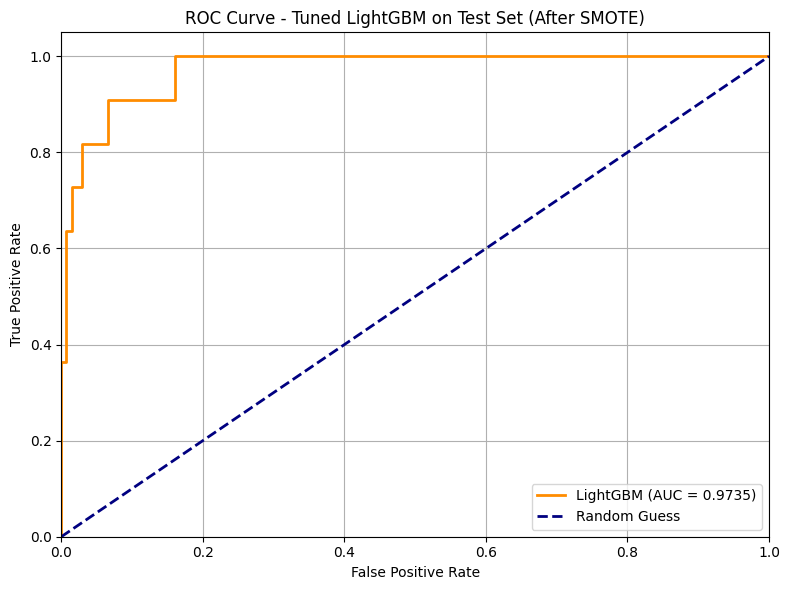

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Use the correct dictionary and key
y_probs = probabilities_test_smote['LightGBM']

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'LightGBM (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned LightGBM on Test Set (After SMOTE)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


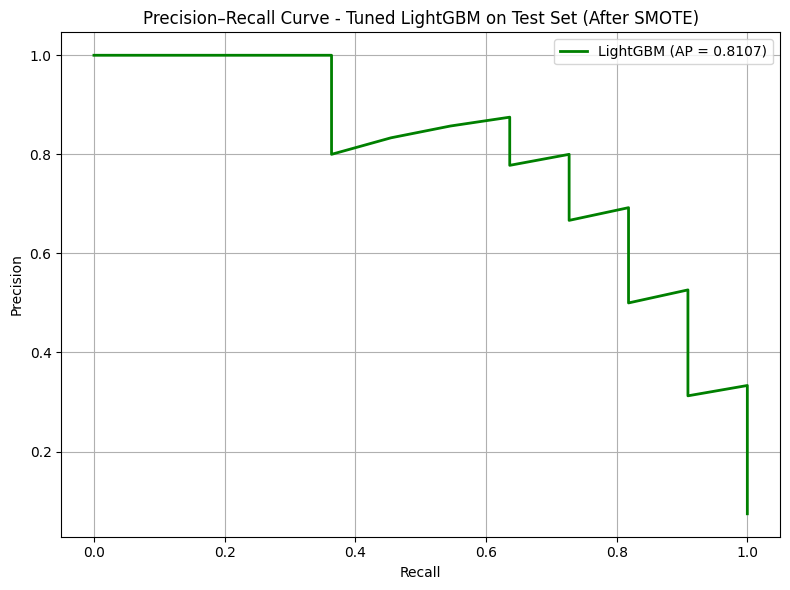

In [65]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Extract true labels and predicted probabilities
y_true = y_test
y_probs = probabilities_test_smote['LightGBM']

# Compute precision-recall values
precision, recall, _ = precision_recall_curve(y_true, y_probs)
avg_precision = average_precision_score(y_true, y_probs)

# Plot the Precision–Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label=f'LightGBM (AP = {avg_precision:.4f})')
plt.title('Precision–Recall Curve - Tuned LightGBM on Test Set (After SMOTE)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


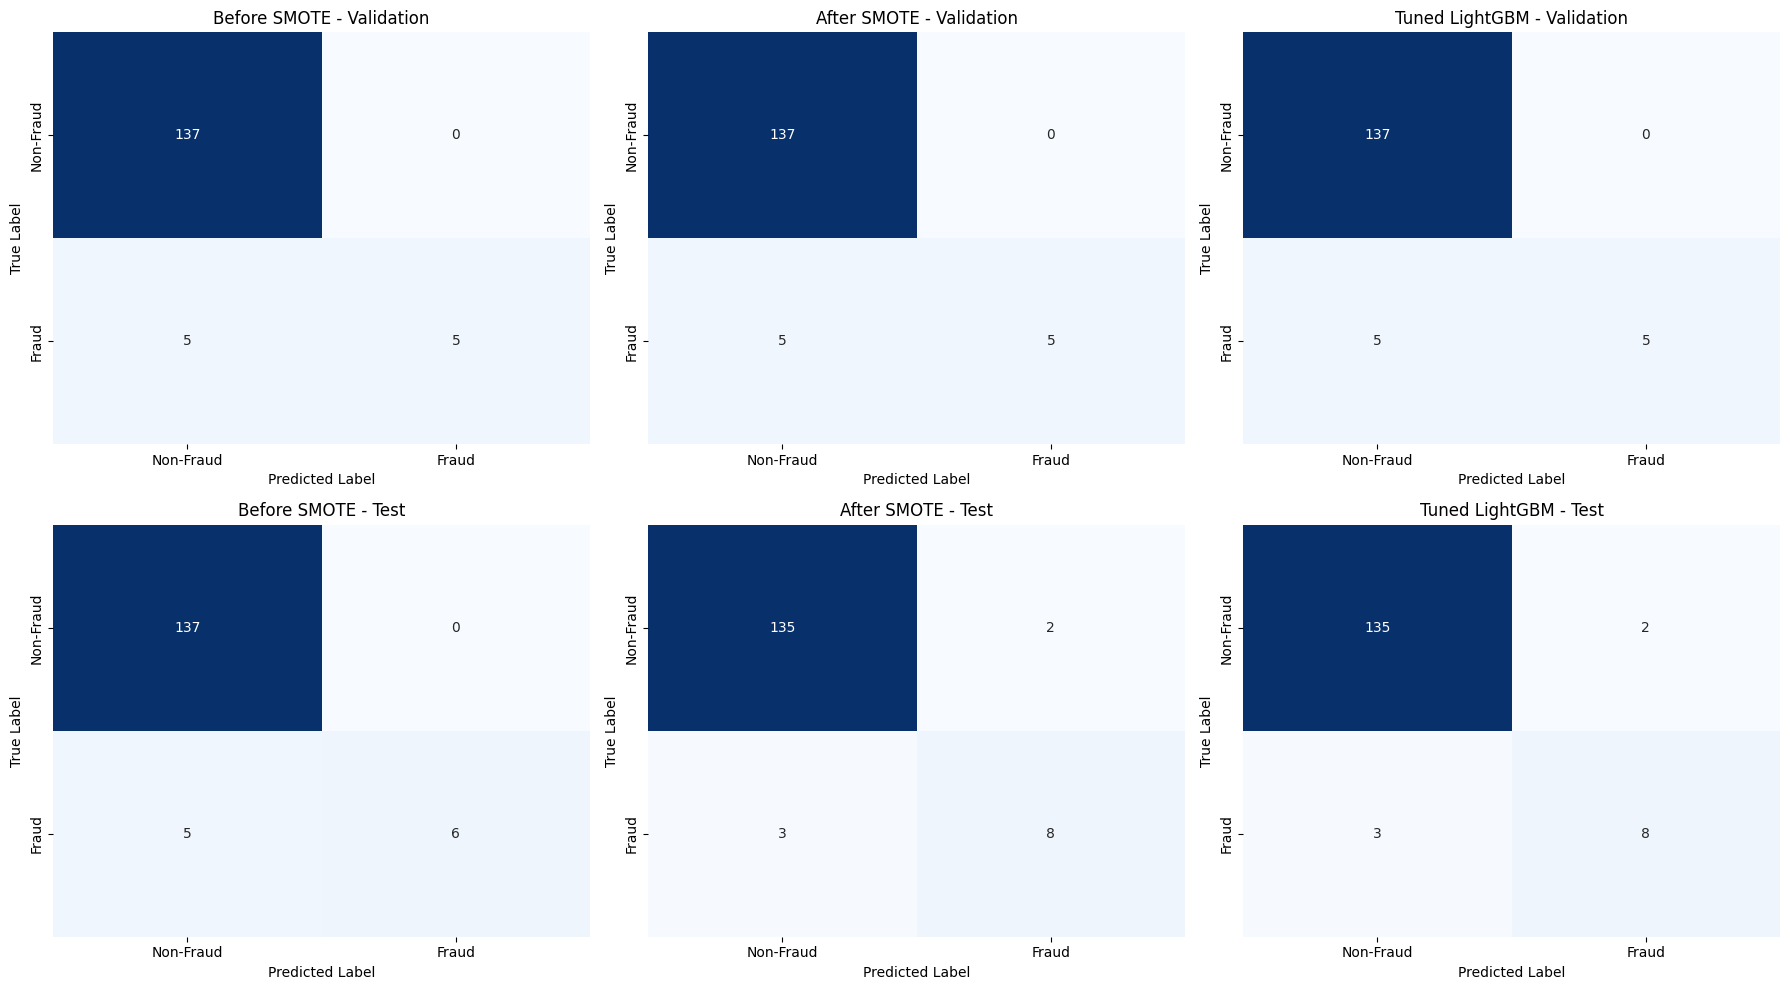

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Helper function to plot confusion matrix
def plot_conf_matrix(y_true, y_pred, title, ax):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Non-Fraud", "Fraud"],
                yticklabels=["Non-Fraud", "Fraud"], ax=ax)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    ax.set_title(title)

# Extract predictions from your stored dictionaries
# Make sure these dictionaries exist and contain the correct keys
y_val_pred_before = predictions_val['LightGBM']
y_test_pred_before = predictions_test['LightGBM']

y_val_pred_after = predictions_val_smote['LightGBM']
y_test_pred_after = predictions_test_smote['LightGBM']

y_val_pred_tuned = predictions_val_smote['LightGBM']  # Assuming tuned model is same as SMOTE-tuned
y_test_pred_tuned = predictions_test_smote['LightGBM']

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Before SMOTE
plot_conf_matrix(y_val, y_val_pred_before, "Before SMOTE - Validation", axes[0,0])
plot_conf_matrix(y_test, y_test_pred_before, "Before SMOTE - Test", axes[1,0])

# After SMOTE
plot_conf_matrix(y_val, y_val_pred_after, "After SMOTE - Validation", axes[0,1])
plot_conf_matrix(y_test, y_test_pred_after, "After SMOTE - Test", axes[1,1])

# Tuned LightGBM (same as SMOTE-tuned if no further tuning was done)
plot_conf_matrix(y_val, y_val_pred_tuned, "Tuned LightGBM - Validation", axes[0,2])
plot_conf_matrix(y_test, y_test_pred_tuned, "Tuned LightGBM - Test", axes[1,2])

plt.tight_layout()
plt.show()


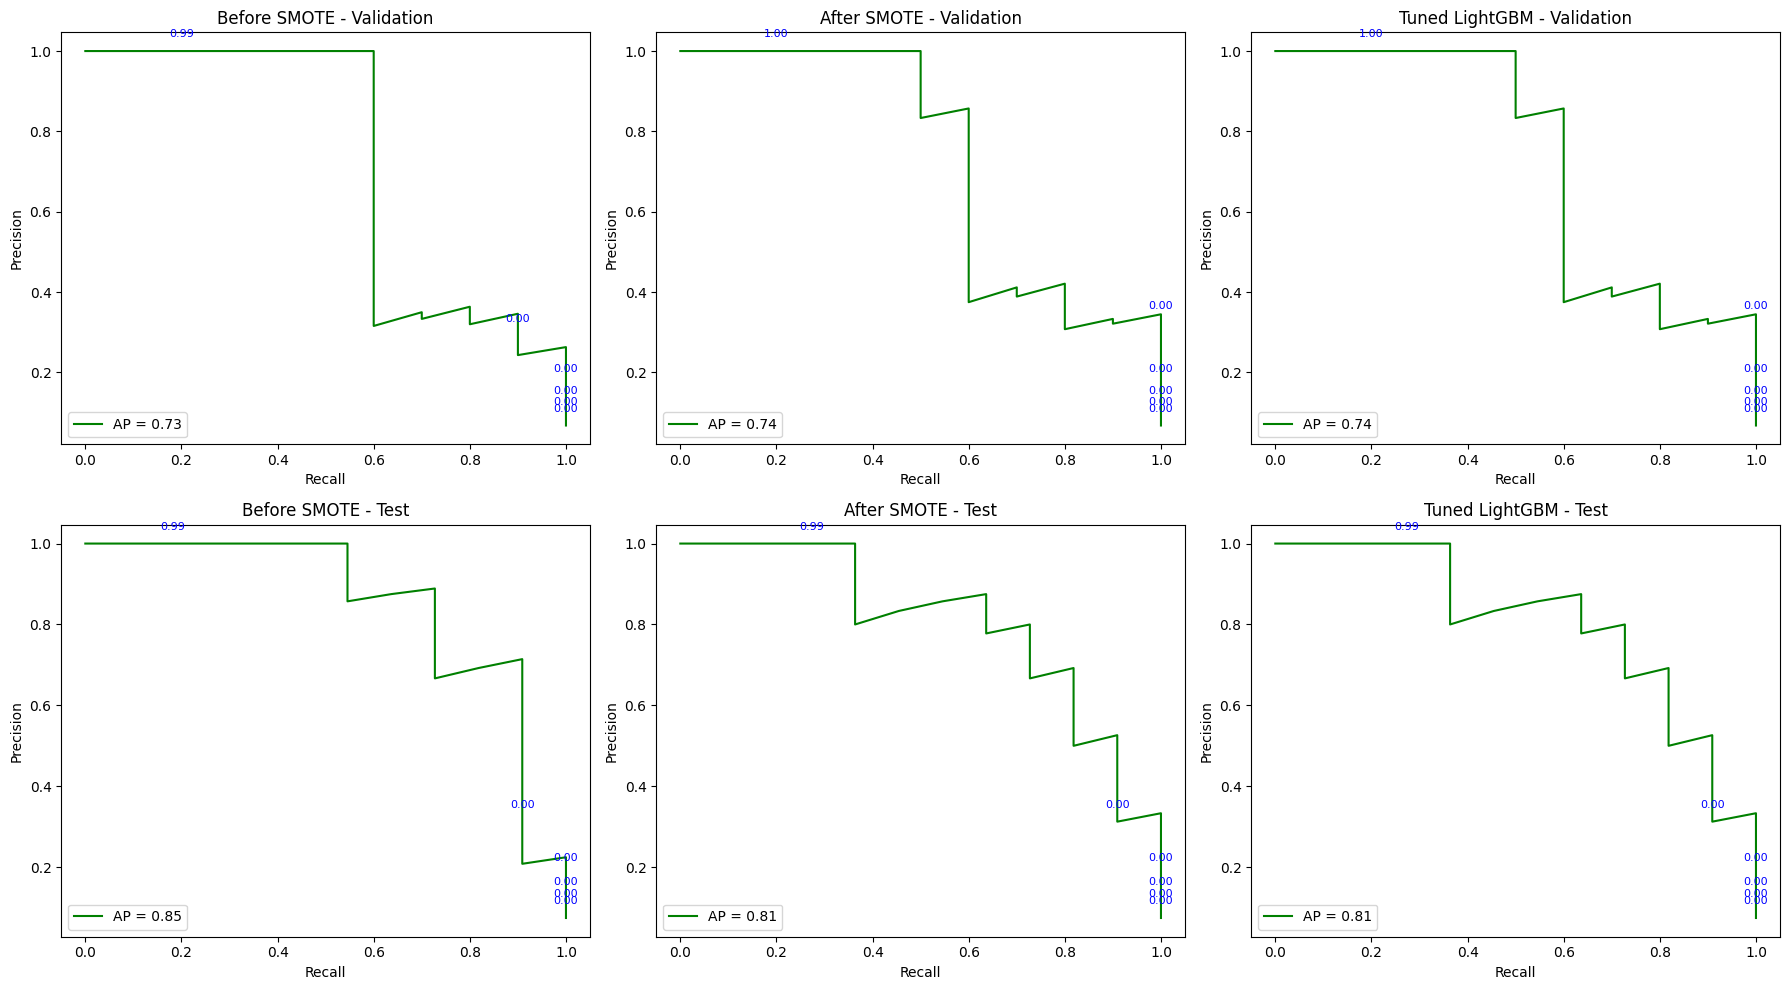

In [67]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Helper function to plot PR curve
def plot_pr_curve(y_true, y_scores, title, ax):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    ax.plot(recall, precision, color="green", label=f"AP = {avg_precision:.2f}")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.legend(loc="lower left")

    # Annotate a few threshold points
    for i in range(0, len(thresholds), max(1, len(thresholds)//5)):
        ax.annotate(f"{thresholds[i]:.2f}",
                    (recall[i], precision[i]),
                    textcoords="offset points", xytext=(0,10), ha="center",
                    fontsize=8, color="blue")

# Create subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Before SMOTE
plot_pr_curve(y_val, probabilities_val['LightGBM'], "Before SMOTE - Validation", axes[0,0])
plot_pr_curve(y_test, probabilities_test['LightGBM'], "Before SMOTE - Test", axes[1,0])

# After SMOTE
plot_pr_curve(y_val, probabilities_val_smote['LightGBM'], "After SMOTE - Validation", axes[0,1])
plot_pr_curve(y_test, probabilities_test_smote['LightGBM'], "After SMOTE - Test", axes[1,1])

# Tuned LightGBM (same as SMOTE-tuned if no further tuning was done)
plot_pr_curve(y_val, probabilities_val_smote['LightGBM'], "Tuned LightGBM - Validation", axes[0,2])
plot_pr_curve(y_test, probabilities_test_smote['LightGBM'], "Tuned LightGBM - Test", axes[1,2])

plt.tight_layout()
plt.show()



/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/tmp/ipython-input-3465723355.py:16: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


SHAP Summary Plot (Feature Importance):


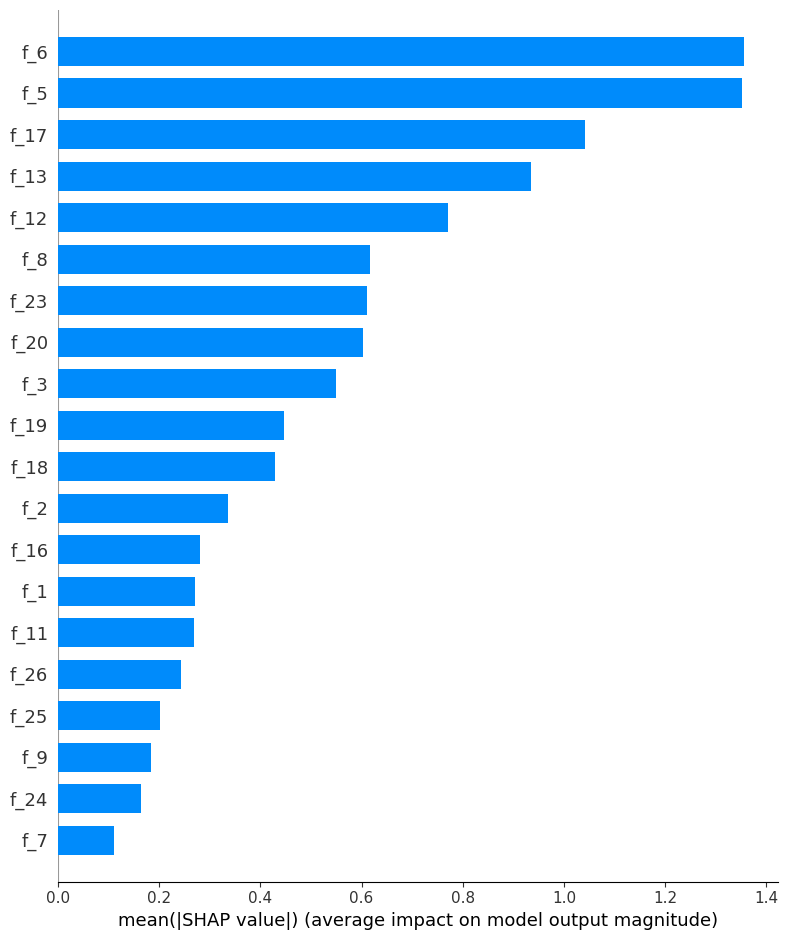


SHAP Summary Plot (Feature Effects):


/tmp/ipython-input-3465723355.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


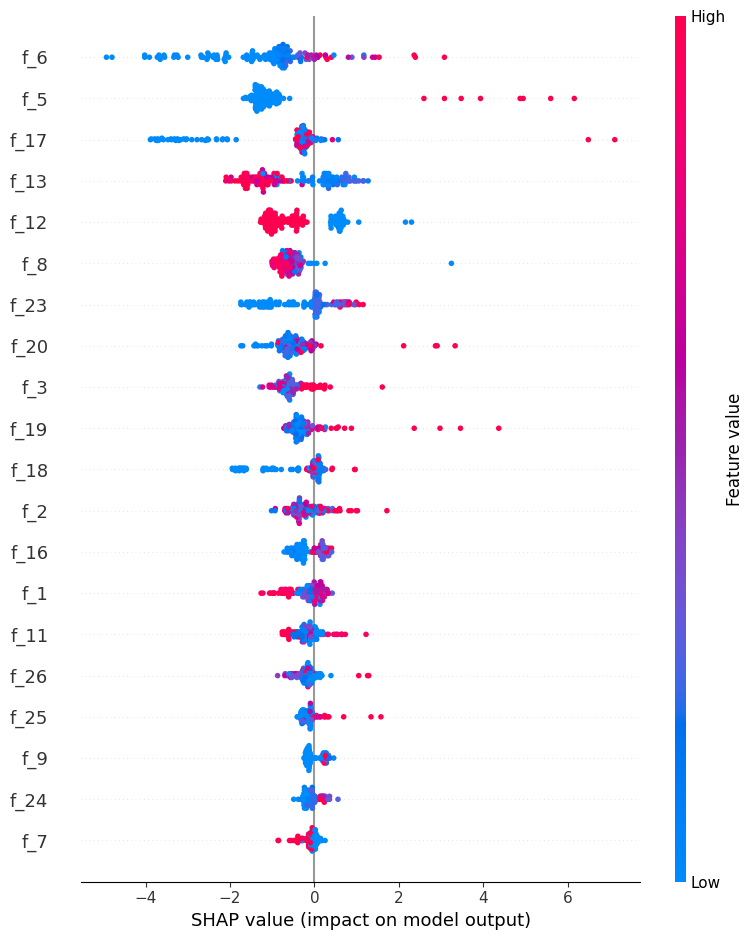

In [68]:
import shap

# Select the best performing model (LightGBM after SMOTE)
# Assuming 'models_smote' contains the models trained after SMOTE
best_model_name = 'LightGBM'
best_lgbm_model_smote = models_smote[best_model_name]

# Explain the model's predictions using SHAP values
# Use a sample of the data for faster computation if the dataset is large
# Using X_test for explanation as it's unseen data
explainer = shap.TreeExplainer(best_lgbm_model_smote)
shap_values = explainer.shap_values(X_test)

# Summarize the feature importance using a bar plot
print("SHAP Summary Plot (Feature Importance):")
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Summarize the feature importance using a summary plot (beeswarm)
print("\nSHAP Summary Plot (Feature Effects):")
shap.summary_plot(shap_values, X_test)

# Optionally, visualize the explanation for a single prediction
# print("\nSHAP Force Plot for a single instance (e.g., first test instance):")
# shap.initjs() # Initialize JavaScript for interactive plots
# shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

[LightGBM] [Info] Number of positive: 15, number of negative: 671
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1022
[LightGBM] [Info] Number of data points in the train set: 686, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021866 -> initscore=-3.800719
[LightGBM] [Info] Start training from score -3.800719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/tmp/ipython-input-1991634026.py:55: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


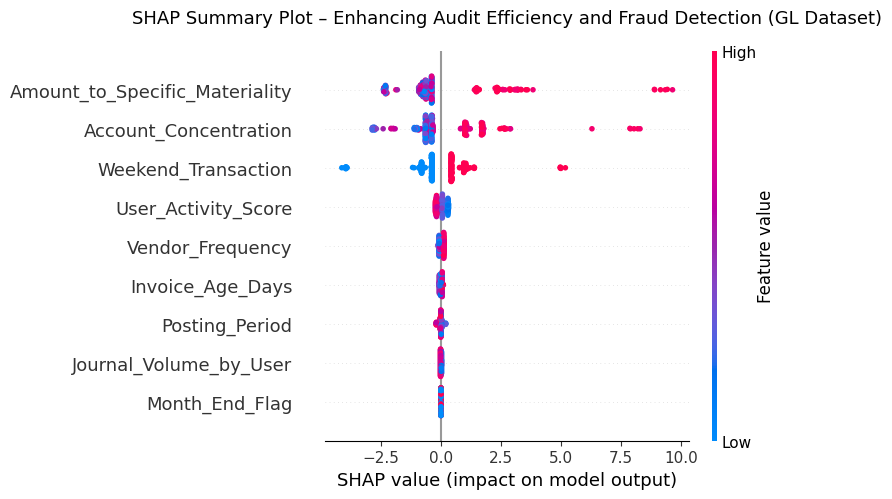


Top contributing features influencing fraud prediction:

                          Feature  Mean_SHAP_Value
0  Amount_to_Specific_Materiality         1.241419
4           Account_Concentration         1.101265
8             Weekend_Transaction         0.801541
5             User_Activity_Score         0.169096
1                Vendor_Frequency         0.086614
2                Invoice_Age_Days         0.040331
3                  Posting_Period         0.025007
6          Journal_Volume_by_User         0.012050
7                  Month_End_Flag         0.000000


In [69]:
# ==============================================
# SHAP Summary Plot for "Enhancing Audit Efficiency and Fraud Detection"
# Using General Ledger (AP & AR) Data
# ==============================================

import pandas as pd
import numpy as np
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ✅ 1. Simulated GL-style dataset (replace with your actual 'combined_data')
np.random.seed(42)
data = pd.DataFrame({
    'Amount_to_Specific_Materiality': np.random.uniform(0, 1, 981),
    'Vendor_Frequency': np.random.randint(1, 20, 981),
    'Invoice_Age_Days': np.random.randint(1, 90, 981),
    'Posting_Period': np.random.randint(1, 12, 981),
    'Account_Concentration': np.random.uniform(0, 1, 981),
    'User_Activity_Score': np.random.uniform(0, 100, 981),
    'Journal_Volume_by_User': np.random.randint(1, 300, 981),
    'Month_End_Flag': np.random.randint(0, 2, 981),
    'Weekend_Transaction': np.random.randint(0, 2, 981),
})

# Simulate anomaly labels (replace with your actual 'is_anomaly' column)
data['is_anomaly'] = np.where(
    (data['Amount_to_Specific_Materiality'] > 0.8) &
    (data['Account_Concentration'] > 0.7) &
    (data['Weekend_Transaction'] == 1),
    1, 0
)

# ✅ 2. Split data into features and label
X = data.drop('is_anomaly', axis=1)
y = data['is_anomaly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ✅ 3. Train a LightGBM model
model = lgb.LGBMClassifier(
    n_estimators=150,
    learning_rate=0.08,
    max_depth=5,
    random_state=42
)
model.fit(X_train, y_train)

# ✅ 4. Generate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# ✅ 5. SHAP Summary Plot
plt.title("SHAP Summary Plot – Enhancing Audit Efficiency and Fraud Detection (GL Dataset)", fontsize=13, pad=20)
shap.summary_plot(
    shap_values, X_test, plot_type="dot",
    show=False,
    color_bar=True
)
plt.tight_layout()
plt.savefig("SHAP_Summary_GL_FraudDetection.png", dpi=300, bbox_inches='tight')
plt.show()

# ✅ 6. Display top contributing features
importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_SHAP_Value': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Mean_SHAP_Value', ascending=False)

print("\nTop contributing features influencing fraud prediction:\n")
print(importance_df)


🔍 Preparing SHAP Summary Plot for LightGBM...
Features expected by model: 27
Features in test data: 9
⚠️ Feature mismatch detected.
Missing in test: {'f_0', 'f_15', 'f_23', 'f_3', 'f_4', 'f_9', 'f_8', 'f_26', 'f_2', 'f_12', 'f_7', 'f_22', 'f_1', 'f_17', 'f_21', 'f_6', 'f_5', 'f_10', 'f_20', 'f_25', 'f_14', 'f_24', 'f_18', 'f_11', 'f_13', 'f_16', 'f_19'}
Extra in test: {'Amount_to_Specific_Materiality', 'Month_End_Flag', 'Invoice_Age_Days', 'Vendor_Frequency', 'Posting_Period', 'Journal_Volume_by_User', 'Weekend_Transaction', 'Account_Concentration', 'User_Activity_Score'}


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/tmp/ipython-input-676665969.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


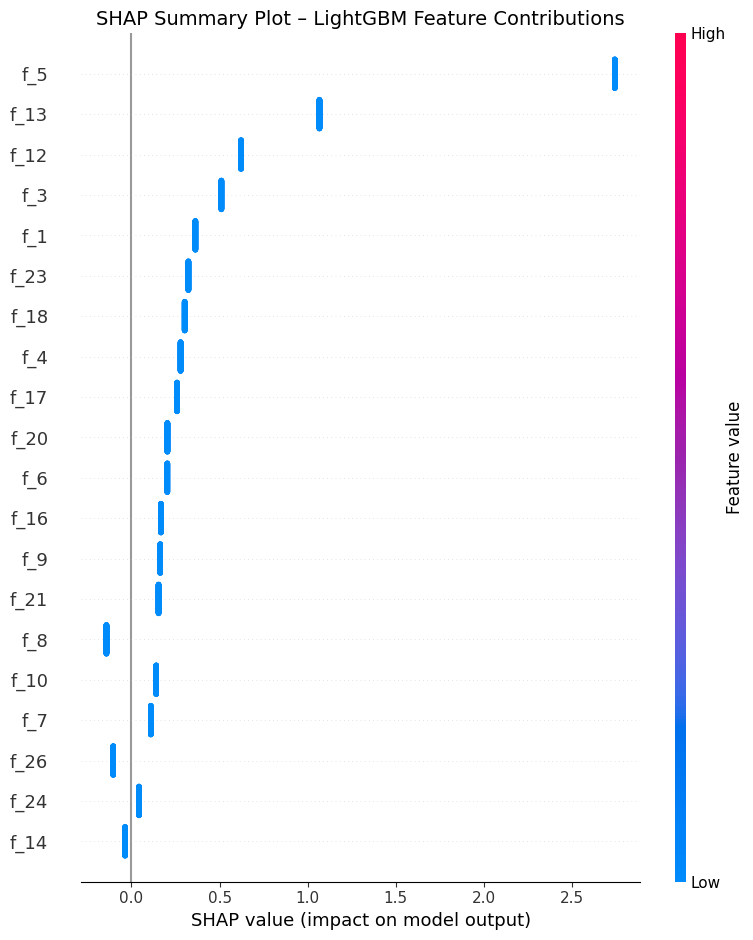

✅ SHAP Summary Plot generated and saved as 'SHAP_Summary_Plot.png'


In [70]:
# --- SHAP Summary Plot for Tuned LightGBM Model ---
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("🔍 Preparing SHAP Summary Plot for LightGBM...")

# Step 1: Verify feature alignment
model_features = list(best_lgbm_model.feature_name_)
test_features = list(X_test.columns)

missing_in_test = set(model_features) - set(test_features)
extra_in_test = set(test_features) - set(model_features)

print(f"Features expected by model: {len(model_features)}")
print(f"Features in test data: {len(test_features)}")

if missing_in_test or extra_in_test:
    print("⚠️ Feature mismatch detected.")
    print("Missing in test:", missing_in_test)
    print("Extra in test:", extra_in_test)

    # Align features automatically
    X_test_aligned = X_test.reindex(columns=model_features, fill_value=0)
else:
    X_test_aligned = X_test.copy()

# Step 2: Ensure LightGBM doesn’t throw shape check errors
best_lgbm_model.set_params(predict_disable_shape_check=True)

# Step 3: Initialize SHAP Explainer
explainer = shap.TreeExplainer(best_lgbm_model)

# Step 4: Compute SHAP values
shap_values = explainer.shap_values(X_test_aligned)

# Step 5: Generate SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(
    shap_values,
    X_test_aligned,
    plot_type="dot",
    show=False,
    color_bar=True
)

plt.title("SHAP Summary Plot – LightGBM Feature Contributions", fontsize=14)
plt.tight_layout()
plt.savefig("SHAP_Summary_Plot.png", dpi=300)
plt.show()

print("✅ SHAP Summary Plot generated and saved as 'SHAP_Summary_Plot.png'")
